# spaCy/HDBScan Feature Extraction Pipeline

### Note: it can be quite complicated to install spaCy and sense2vec, given conflicting low-level requirements, so at this point I wouldn't suggest that others try to install the libraries and run this notebook.
  
However, it is well worth scanning down to the cell titled ***Harvesting Word Features***. In the output of that cell, there are examples of 52 feature clusters harvested by this process. The ultimate output of this process will produce a dataset containing a product ID (asin), overall rating, and word feature, for each word feature found in each product review. I don't consider these feature clusters as the final product, and we should discuss.


### We can use this output for several purposes. 

1. First, we should be able to quite easily make the data available to th web interface, so that we can display the top n word features (by overall rating) associated with products returned.

2. We will want to also include the user's selected word features in our model evaluation, to enable them to "drill into" selected features and thus explore the product/feature landscape.

3. Finally, I think it would be worth training a model on a vectorized representation of the top n most highly rated features, which may give us another dimension for predicting rating based on feature combination/interaction.

In [1]:
import pandas as pd
import gzip
import random
import time
# Install a few python packages using pip

#import enchant
import html
#!conda install pytables


# PyTables will be used to create huge matrices stored on disk, via HDF
import tables
from tables import *

from common import utils
utils.require_package("wget")      # for fetching dataset

In [2]:
# Standard python helper libraries.
from __future__ import print_function
from __future__ import division
import os, sys, time
import collections
from collections import Counter
import itertools

# Numerical manipulation libraries.
import numpy as np

import pickle 

#Visualization
import matplotlib
%matplotlib inline

import spacy
#activated = spacy.prefer_gpu()

import hdbscan
import seaborn as sns
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
from spacy.tokens import Doc
import tqdm
utils.require_package("wget") 
import nltk
from nltk.corpus import stopwords

In [3]:
#%lsmagic

plotting = True
labels_words = False

language_model = 'en_core_web_md'

start = time.time()
print("Reading spaCy language model {}...".format(language_model))
nlp = spacy.load(language_model, entity=False)
print("...finished reading English language model '{}' in {} seconds.".format(language_model, time.time()-start))

from nltk.corpus import stopwords
 
stopWords = set(stopwords.words('english'))
for stop_word in stopWords:
    nlp.vocab[stop_word].is_stop = True

Reading spaCy language model en_core_web_md...
...finished reading English language model 'en_core_web_md' in 14.470937967300415 seconds.


In [4]:
debug = False

# Paths for output files
path_for_tf_metadata = './logdir/embedding_test'
path_for_tf_ckpt = path_for_tf_metadata+'/embedding_test.ckpt'

In [5]:
def display_local_time():
    localTime = time.localtime()
    print("Local time = {}:{}".format(localTime.tm_hour, format(localTime.tm_min,'02')))    


In [6]:
def parse(path):
  print('start parse')
  start_parse = time.time()
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)
  end_parse = time.time()
  print('end parse with time for parse',end_parse - start_parse)

def getDF(path):
  print('start getDF')
  start = time.time()
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  print('end getDF')
  end = time.time()
  print('time taken to load data = ',end-start)
  return pd.DataFrame.from_dict(df, orient='index')

start = time.time()
print("Reading Pandas dataframe from reviews_Toys_and_Games_5.json.gz...")
df = getDF('./data/reviews_Toys_and_Games_5.json.gz')
print("...read reviews_Toys_and_Games_5.json.gz in {} seconds.".format(time.time()-start))

Reading Pandas dataframe from reviews_Toys_and_Games_5.json.gz...
start getDF
start parse
end parse with time for parse 9.248434066772461
end getDF
time taken to load data =  9.248952150344849
...read reviews_Toys_and_Games_5.json.gz in 12.499062776565552 seconds.


In [7]:
# meta_Toys_and_Games.json.gz
print("Loading related metadata dataset:")
print()
# file = 'metadata.json.gz'
file = './data/meta_Toys_and_Games.json.gz'
start = time.time()
md = getDF(file)
print('Total time taken for loading the metadata dataset: {} minutes.'.format(np.round((time.time() - start)/60),2))
print()
print(md.columns)
print()
print("Number of records in metadata dataset: {}".format(len(md)))
print()
print(md.head(1))

Loading related metadata dataset:

start getDF
start parse
end parse with time for parse 55.42703294754028
end getDF
time taken to load data =  55.42797303199768
Total time taken for loading the metadata dataset: 1.0 minutes.

Index(['price', 'description', 'asin', 'categories', 'imUrl', 'brand', 'title',
       'salesRank', 'related'],
      dtype='object')

Number of records in metadata dataset: 336072

   price                                        description        asin  \
0  37.12  Three Dr. Suess' Puzzles: Green Eggs and Ham, ...  0000191639   

                                  categories  \
0  [[Toys & Games, Puzzles, Jigsaw Puzzles]]   

                                               imUrl      brand  \
0  http://ecx.images-amazon.com/images/I/414PLROX...  Dr. Seuss   

                                            title                 salesRank  \
0  Dr. Suess 19163 Dr. Seuss Puzzle 3 Pack Bundle  {'Toys & Games': 612379}   

  related  
0     NaN  


In [8]:
print(df.shape)
print(df.columns)
df.head(2)

(167597, 9)
Index(['reviewerName', 'reviewText', 'unixReviewTime', 'summary', 'asin',
       'reviewTime', 'helpful', 'overall', 'reviewerID'],
      dtype='object')


reviewerName                                         reviewText  \
0        Angie  I like the item pricing. My granddaughter want...   
1      Candace  Love the magnet easel... great for moving to d...   

   unixReviewTime                                            summary  \
0      1390953600                                     Magnetic board   
1      1395964800  it works pretty good for moving to different a...   

         asin   reviewTime helpful  overall      reviewerID  
0  0439893577  01 29, 2014  [0, 0]      5.0  A1VXOAVRGKGEAK  
1  0439893577  03 28, 2014  [1, 1]      4.0   A8R62G708TSCM

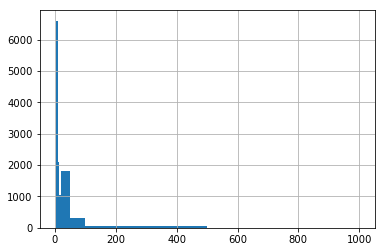

In [9]:
#Number of reviews by product
cnt_by_product = df[['asin','reviewText']].groupby('asin').agg('count')
cnt_by_product['reviewText'].hist(bins = [0,1,2,3,4,5,10,15,20,50,100,500,1000])

In [10]:
#Number of reviews by reviewer
cnt_by_reviewer = df[['reviewerID','reviewText']].groupby('reviewerID').agg('count').reset_index()

good_reviewers = cnt_by_reviewer[cnt_by_reviewer['reviewText']>4]
print(good_reviewers[:5])

good_products_by_review = cnt_by_product[cnt_by_product['reviewText']>4].reset_index()
print("good_products_by_review:\n", good_products_by_review[:5])

              reviewerID  reviewText
0  A012468118FTQAINEI0OQ           6
1   A0182108CPDLPRCXQUZQ           8
2  A026961431MGW0616BRS3           6
3  A034597326Z83X79S50FI           7
4  A04295422T2ZG087R17FX           5
good_products_by_review:
          asin  reviewText
0  0439893577          17
1  048645195X          11
2  0545496470           6
3  0615444172           6
4  0670010936          10


In [35]:
build_set = 2

product_buildset = pd.read_csv('./data/cluster_build_sets.csv', names=['asin','build_set'])

print("product_buildset:\n", product_buildset[:5])

products_in_buildset = product_buildset[product_buildset['build_set']==build_set]

print("products_in_buildset:\n", products_in_buildset[:5])

filters_merged = pd.merge(good_products_by_review, products_in_buildset[['asin','build_set']], on='asin')

print("filters_merged({}):\n".format(len(filters_merged)), filters_merged[:5])

df_merged = pd.merge(df[['asin','overall','reviewText']], filters_merged[['asin','build_set']], on='asin')
print("df_merged({}):\n".format(len(df_merged)), df_merged[:5])


product_buildset:
          asin  build_set
0  B002HWRQ9W          5
1  B00CUORE4Y          3
2  B007BFRTJM          6
3  B00EYN8QPA          7
4  B00B1JDB32          7
products_in_buildset:
           asin  build_set
6   B008BHIKPG          2
7   B000OZ6HJE          2
12  B000GLW0ZQ          2
15  B00604WAI0          2
16  B00008KGT6          2
filters_merged(3243):
          asin  reviewText  build_set
0  048645195X          11          2
1  0963679600          28          2
2  1570545340           8          2
3  1592923356           7          2
4  1603801286           6          2
df_merged(40699):
          asin  overall                                         reviewText  \
0  048645195X      5.0  This is my absolute favorite design book. The ...   
1  048645195X      4.0  Working with Mandala type coloring books can t...   
2  048645195X      5.0  This book contains 30 full page designs that a...   
3  048645195X      5.0  Prepare to be swept away by the beauty of the ...   
4  

In [36]:
vectors_filepath = './data/vectors_each.{}.pytab'.format(build_set)
metadata_filepath = './data/metadata_each.{}.tsv'.format(build_set)

In [37]:
# Preprocess the reviews by HTML unescaping them

df_merged = df_merged.groupby(['asin','overall'], as_index=True)['reviewText'].apply(' '.join).apply(html.unescape).reset_index()
print("cleaned df columns:", list(df))


cleaned df columns: ['reviewerName', 'reviewText', 'unixReviewTime', 'summary', 'asin', 'reviewTime', 'helpful', 'overall', 'reviewerID']


In [38]:
print("Cleaned DF", df_merged[:5])
print("...{} records".format(len(df_merged)))

Cleaned DF          asin  overall                                         reviewText
0  048645195X      3.0  The pictures in this book are very detailed an...
1  048645195X      4.0  Working with Mandala type coloring books can t...
2  048645195X      5.0  This is my absolute favorite design book. The ...
3  0963679600      1.0  thought this was a book with pages to illustra...
4  0963679600      4.0  I thought this product would be a wonderful id...
...9203 records


In [39]:
def remove_file(file_path):
    if os.path.isfile(file_path):
        print("Removing file '{}'...".format(file_path))
        os.remove(file_path)

In [40]:
from string import punctuation

IGNORED_LEMMAS = ['-PRON-', 'PRON', 'i']
IGNORED_POS = ['PUNCT', 'DET']
MAX_FEATURES_PER_REVIEW = 10

def check_embedded_punctuation(input_str):
    """ Check for 2 sequential punctuation characters in a string """
    from string import punctuation
    
    punct_count = 0
    
    for char in input_str:
        if char in punctuation:
            punct_count += 1
            if punct_count == 2:
                return True
        else:
            punct_count = 0
            
    return False
        

def get_lemmatized_chunk(chunk):
    """ Filter a noun chunk to exclude IGNORED_LEMMAS and return the remaining text and a computed word vector. """
    processed_text = []
    vector = np.zeros(300)
    stop_count = 0
    non_stop_count = 0
    doc = chunk
    for token in doc:
        if (token.lemma_ not in IGNORED_LEMMAS) and (token.pos_ not in IGNORED_POS):            
            this_text = token.text.strip()
            
            # check if this token contains 2 or more sequential punctuation characters
            if check_embedded_punctuation(this_text):
                stop_count += 1
                continue
            else:  
                non_stop_count += 1
                vector = vector + token.vector

            if this_text != token.text:
                processed_text.append(this_text)
            else:
                processed_text.append(token.lemma_.lower())   
        
    if (non_stop_count > 0) and (stop_count > 0):
        vector = np.divide(vector, non_stop_count)
    
    return " ".join(processed_text), vector


def get_vectors(text, nlp):
    """ <generator> Get embedding word vectors from a given text object. 
    Args
    ----------
    text (string)            text to be parsed, tokenized, and vectorized
    nlp (spaCy pipeline)     pipeline to use for processing the input text
    
    Generates:
    ----------
    processed text (string) 
    phrase vector (numpy.ndarray)
    """          
    # first, strip out the stop words and lowercase the words
    text = ' '.join([word.lower() for word in text.split() if not word in stopWords])
    
    doc = nlp(text)
    #####
    # Next, iterate through the sentences and within those the noun chunks.
    # These noun chunks will be lemmatized and collected as potential features.
    #####
    
    collected_terms = []
    term_vector_map = {}
    
    for sent in doc.sents:
        for chunk in sent.noun_chunks:
            #yield chunk.text, chunk.vector
            lemmatized_text, vect = get_lemmatized_chunk(chunk)
            if len(lemmatized_text) >0:
                collected_terms.append(lemmatized_text)
                term_vector_map[lemmatized_text] = vect
                
    term_rank = Counter(collected_terms)
    
    for ranked_term in term_rank.most_common(MAX_FEATURES_PER_REVIEW):
        term = ranked_term[0]
        yield term, term_vector_map[term]

In [41]:
def write_vectors(word_vects, out_m, product, rating, processed_text, concept_vec):
    """Write product, rating, phrase and sense vector to metadata and vectors files"""
    phrase = processed_text
    sense_vector = concept_vec
    print('\t'.join([product, str(rating),phrase]), file=out_m)
    word_vects.append([sense_vector])


In [42]:
# The following boolean controls whether the index list and the output np matrix are build by the vectorizing process.
# This can be used if appropriate for small datasets, but the repeated stacking of numpy arrays is expensive.
# Otherwise, these item are already written out to the files in metadata_filepath and vectors_filepath, using PyTables.
build_vects = False

remove_file(vectors_filepath)
remove_file(metadata_filepath)

# Create a sample vector, to determine the word vect dimension of a single entry
sample_vect = [vec for vec in get_vectors("example", nlp)][0][1]
vect_dim = sample_vect.shape
print("Sample vect[{}]".format(vect_dim))
index = []
output = None
vectors_count = 0

total_start = time.time()

#good_reviews = df[df['reviewerID'].isin(good_reviewers['reviewerID'])][df['asin'].isin(good_products['asin'])]
#good_reviews = df[df['asin'].isin(good_products['asin']) & df['asin'].isin(products_in_buildset)]
good_reviews = df_merged

#print("There are {} total reviews for reviewers with at least 5 reviews each and products with at least 5 reviews each".format(len(good_reviews)))
print("There are {} total reviews for products with at least 5 reviews each".format(len(good_reviews)))

start_ind = 0
iteration_size = 1000
iter_limit = len(good_reviews)
#iter_limit = 10000


print("\nCollecting word concept vectors for {} product/rating/reviews...".format(iter_limit))
display_local_time()

with open_file(vectors_filepath, mode="w", title="Word Vectors") as out_v:
    
    atom = tables.Float32Atom(vect_dim[0])
    shape = (0,)
    filters = tables.Filters(complevel=5, complib='zlib')
    word_vect = out_v.create_earray(out_v.root, 'vector', atom, shape, filters=filters)

with open(metadata_filepath, 'a') as out_m, open_file(vectors_filepath, mode="a", title="Word Vectors") as out_v:
    
    print("Word Vectors: ", out_v)
    
    for iteration in range(int(iter_limit/iteration_size)+1):

        print("Starting iteration over reviews {}-{}...".format(start_ind + iteration*iteration_size,
                                                                start_ind + (iteration+1)*iteration_size-1))
        
        iter_start_time = time.time()
        
        processed_records = iteration*iteration_size
        
        this_iteration_size = min(iteration_size, len(good_reviews)-processed_records)
        
        for iter_ind in range(this_iteration_size):
    
            review_ind = start_ind + iteration*iteration_size + iter_ind
        
            #reviewer = good_reviews['reviewerID'].iloc[review_ind]
            product = good_reviews['asin'].iloc[review_ind]
            rating = good_reviews['overall'].iloc[review_ind]
            review = good_reviews['reviewText'].iloc[review_ind]
    
            #print(review)
            for processed_text, concept_vec in get_vectors(review, nlp):
            
                # If there were no non-stop words in a given noun chunk, we will not add it to the vectors and metadata
                if (len(processed_text)>0):

                    write_vectors(out_v.root.vector, out_m, product, rating, processed_text, concept_vec)
                    vectors_count += 1
                    
                    # If this run is not just writing to disk, but should also build the vectors
                    if build_vects:                    
                        # Append data to a list and a numpy array
                        index.append([product, rating, processed_text])
        
                        if output is None:
                            # Create an np.array with the first row as the retrieved word vector
                            output = np.array([concept_vec])
                        else:
                            # Append the next vector to the end of the vectors array
                            output = np.append(output, [concept_vec], axis=0)            

        print("...completed processing {} reviews in {} seconds.".format(this_iteration_size, time.time()-iter_start_time))
    
print("...processed {} reviews in {} seconds, producing {} word vectors.".format(iteration*iteration_size+this_iteration_size, time.time()-total_start, vectors_count))


Removing file './data/vectors_each.2.pytab'...
Removing file './data/metadata_each.2.tsv'...
Sample vect[(300,)]
There are 9203 total reviews for products with at least 5 reviews each

Local time = 20:49
Word Vectors:  ./data/vectors_each.2.pytab (File) 'Word Vectors'
Last modif.: 'Sat Jul  6 20:49:46 2019'
Object Tree: 
/ (RootGroup) 'Word Vectors'
/vector (EArray(0,), shuffle, zlib(5)) ''

Starting iteration over reviews 0-999...
...completed processing 1000 reviews in 62.012526988983154 seconds.
Starting iteration over reviews 1000-1999...
...completed processing 1000 reviews in 62.8333899974823 seconds.
Starting iteration over reviews 2000-2999...
...completed processing 1000 reviews in 54.73404312133789 seconds.
Starting iteration over reviews 3000-3999...
...completed processing 1000 reviews in 58.17462515830994 seconds.
Starting iteration over reviews 4000-4999...
...completed processing 1000 reviews in 69.71607303619385 seconds.
Starting iteration over reviews 5000-5999...
...c

In [46]:
phrases = []
with open(metadata_filepath, 'r') as in_m:
    for line in in_m:
        phrase = line.split('\t')[2]
        phrases.append(phrase.strip())
        
phrase_count = Counter(phrases)

print("Here are the top {} phrases and their counts...".format(MAX_FEATURES_PER_REVIEW))

for counted_phrase in phrase_count.most_common(MAX_FEATURES_PER_REVIEW):
        phrase = counted_phrase[0]
        print(counted_phrase)


Here are the top 10 phrases and their counts...
('daughter', 1816)
('kid', 1457)
('doll', 1224)
('toy', 1137)
('son', 942)
('child', 735)
('thing', 611)
('girl', 534)
('christma', 501)
('something', 496)


In [47]:
# Fit an HDBScan model using the sampled sense vectors

HDBSCAN_METRIC = 'manhattan'

with open_file(vectors_filepath, mode="r", title="Word Vectors") as word_vectors:

    print("word_vectors: ", word_vectors)
    
    start = time.time()
    print("Creating word clusters from word vectors...")
    display_local_time()
    hdbscanner = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, 
                                 metric=HDBSCAN_METRIC, gen_min_span_tree=True, prediction_data=True)
    hdbscanner.fit(word_vectors.root.vector)
    print("...completed clustering in {} seconds.".format(time.time()-start))

word_vectors:  ./data/vectors_each.2.pytab (File) 'Word Vectors'
Last modif.: 'Sat Jul  6 21:00:15 2019'
Object Tree: 
/ (RootGroup) 'Word Vectors'
/vector (EArray(81924,), shuffle, zlib(5)) ''

Creating word clusters from word vectors...
Local time = 22:35
...completed clustering in 4331.7811160087585 seconds.


In [48]:
with open_file(vectors_filepath, mode="r", title="Word Vectors") as word_vectors:
    vdim = len(word_vectors.root.vector)
    print("word-vectors{}: ".format(vdim), word_vectors.root.vector)
# Save the HDBScan model with a name indicating the number of word vectors clustered
    with open('./data/hdbscanner.{}.pickle'.format(build_set), 'wb') as pickle_file:
        pickle.dump(hdbscanner, pickle_file)

word-vectors81924:  /vector (EArray(81924,), shuffle, zlib(5)) ''


Condensing the linkage tree and then plotting...
...plotted condensed tree in 43.99805998802185 seconds.
Found 1084 clusters


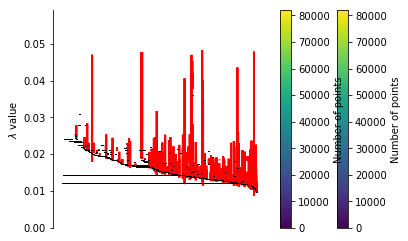

In [49]:
# Plot the condensed cluster tree


if plotting:
	start = time.time()
	print("Condensing the linkage tree and then plotting...")
	#hdbscanner.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
	hdbscanner.condensed_tree_.plot()
	hdbscanner.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
	print("...plotted condensed tree in {} seconds.".format(time.time()-start))
	tree = hdbscanner.condensed_tree_
	print("Found {} clusters".format(len(tree._select_clusters())))
	matplotlib.pyplot.show()

In [50]:
display_local_time()
print("Saving the CondensedTree to disk...")
start = time.time()
np.save("./data/condensedTree.{}.npy".format(build_set), tree)
print("...finished saving the CondensedTree in {} seconds.".format(time.time()-start))

Local time = 0:06
Saving the CondensedTree to disk...
...finished saving the CondensedTree in 0.09572005271911621 seconds.


In [51]:
print("Saving spacy language model to disk...")
display_local_time()
start = time.time()
nlp.to_disk("./data/spacy.language.model.nlp")
print("...finished saving spacy language model in {} seconds.".format(time.time()-start))

Saving spacy language model to disk...
Local time = 0:06
...finished saving spacy language model in 25.637959003448486 seconds.


In [52]:
def get_exemplars(cluster_id, condensed_tree):
    """ Collect and return the exemplar words for each cluster. """
    raw_tree = condensed_tree._raw_tree
    # Just the cluster elements of the tree, excluding singleton points
    cluster_tree = raw_tree[raw_tree['child_size'] > 1]
    # Get the leaf cluster nodes under the cluster we are considering
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster_id)
    # Now collect up the last remaining points of each leaf cluster (the heart of the leaf)
    result = np.array([])
    for leaf in leaves:
        max_lambda = raw_tree['lambda_val'][raw_tree['parent'] == leaf].max()
        points = raw_tree['child'][(raw_tree['parent'] == leaf) & 
                                   (raw_tree['lambda_val'] == max_lambda)]
        result = np.hstack((result, points))
    return result.astype(np.int)

In [53]:
with open(metadata_filepath, 'r') as in_m, open("data/metadata_ouch.tsv", 'w') as out_m:
    item = 0
    for line in in_m:
        fields = line.split('\t')
        if len(fields) > 1:
            print("Fields: ", fields)
            phrase = fields[2]
            phrase = phrase[0:-1:2]
            print("Phrase: ", phrase.split())
            fields[:2]=phrase[:len(phrase)-1]
            out_line = '\t'.join(fields)
            print("Out line: ", out_line)
            item += 1
            if item == 10:
                break

Fields:  ['048645195X', '3.0', 'color pencil\n']
Phrase:  ['clrpni']
Out line:  c	l	r	p	n	color pencil

Fields:  ['048645195X', '3.0', 'product\n']
Phrase:  ['pout']
Out line:  p	o	u	product

Fields:  ['048645195X', '3.0', 'crayon\n']
Phrase:  ['cao']
Out line:  c	a	crayon

Fields:  ['048645195X', '3.0', 'effectively due small space good deal design\n']
Phrase:  ['efcieydesalsaego', 'eldsg']
Out line:  e	f	c	i	e	y	d	e	s	a	l	s	a	e	g	o	 	e	l	d	s	effectively due small space good deal design

Fields:  ['048645195X', '3.0', 'all definitely good old child adult\n']
Phrase:  ['aldfntl', 'ododcidaut']
Out line:  a	l	d	f	n	t	l	 	o	d	o	d	c	i	d	a	u	all definitely good old child adult

Fields:  ['048645195X', '3.0', 'picture book\n']
Phrase:  ['pcuebo']
Out line:  p	c	u	e	b	picture book

Fields:  ['048645195X', '3.0', 'ability use marker\n']
Phrase:  ['aiiyuemre']
Out line:  a	i	i	y	u	e	m	r	ability use marker

Fields:  ['048645195X', '3.0', 'page\n']
Phrase:  ['pg']
Out line:  p	page

Fields:  ['0

In [54]:
tree = hdbscanner.condensed_tree_

#print('Index, for reference:')
#for ind, entry in enumerate(index):
#    print("cluster: {}, ind: {}, entry: {}".format(hdbscanner.labels_[ind], ind, entry))

start = time.time()
print("Selecting clusters in tree...")
clusters = tree._select_clusters()
print("...finished selecting clusters in {} seconds.".format(time.time()-start))

initial_cluster_count = len(clusters)
print("Found {} clusters".format(initial_cluster_count))

index = []
all_points = []
labels = []

# iterate through the input metadata once, to collect all words and the word labels for the sampled points
with open(metadata_filepath, 'r') as in_m:
	mdim = None
	curr_line = 0
	for line in in_m:
		if mdim is None:
			mdim = line.count('\t')+1
			print('File {} contains index entries of of dimension {}'.format(metadata_filepath, vdim))
		if line.endswith('\n'):
			line = line[:-1]
		all_points.append(line.split('\t'))
		sample_this_row = True
		if sample_this_row:
			meta_line = line.split('\t')
			index.append(meta_line)
			if labels_words:
				labels.append(meta_line[2])
		curr_line += 1

print("All Points({}, {}): {}".format(len(all_points), len(all_points[0]), all_points[:5]))

# then, iterate through the input metadata again, to apply the cluster labels, if labels_words is False
with open(metadata_filepath, 'r') as in_m:
	mdim = None
	curr_line = 0
	curr_sample = 0

	for line in in_m:
		if mdim is None:
			mdim = line.count('\t')+1
			print('File {} contains {} index entries.'.format(metadata_filepath, vdim))
		if line.endswith('\n'):
			line = line[:-1]
		sample_this_row = True
		if sample_this_row:
			index.append(line.split('\t'))
			if not labels_words:
				labels.append("-")
			curr_sample += 1
		curr_line += 1


Selecting clusters in tree...
...finished selecting clusters in 1.1638481616973877 seconds.
Found 1084 clusters
File ./data/metadata_each.2.tsv contains index entries of of dimension 81924
All Points(81924, 3): [['048645195X', '3.0', 'color pencil'], ['048645195X', '3.0', 'product'], ['048645195X', '3.0', 'crayon'], ['048645195X', '3.0', 'effectively due small space good deal design'], ['048645195X', '3.0', 'all definitely good old child adult']]
File ./data/metadata_each.2.tsv contains 81924 index entries.


In [55]:
print(hdbscanner.exemplars_)

[array([[-0.17893, -0.55322,  0.40544, ...,  0.99653, -0.36175,  0.23882],
       [-0.17893, -0.55322,  0.40544, ...,  0.99653, -0.36175,  0.23882],
       [-0.17893, -0.55322,  0.40544, ...,  0.99653, -0.36175,  0.23882],
       ...,
       [-0.17893, -0.55322,  0.40544, ...,  0.99653, -0.36175,  0.23882],
       [-0.17893, -0.55322,  0.40544, ...,  0.99653, -0.36175,  0.23882],
       [-0.17893, -0.55322,  0.40544, ...,  0.99653, -0.36175,  0.23882]],
      dtype=float32), array([[-0.085597  , -0.64524   ,  0.6724812 , ...,  0.24909401,
        -0.085425  ,  0.44596   ],
       [-0.085597  , -0.64524   ,  0.6724812 , ...,  0.24909401,
        -0.085425  ,  0.44596   ],
       [-0.085597  , -0.64524   ,  0.6724812 , ...,  0.24909401,
        -0.085425  ,  0.44596   ],
       ...,
       [-0.085597  , -0.64524   ,  0.6724812 , ...,  0.24909401,
        -0.085425  ,  0.44596   ],
       [-0.085597  , -0.64524   ,  0.6724812 , ...,  0.24909401,
        -0.085425  ,  0.44596   ],
       [

In [56]:
print(nlp.vocab.vectors.most_similar(hdbscanner.exemplars_[1]))

(array([15685477373649546968, 15685477373649546968, 15685477373649546968,
       15685477373649546968, 15685477373649546968, 15685477373649546968,
       15685477373649546968, 15685477373649546968, 15685477373649546968,
       15685477373649546968, 15685477373649546968, 15685477373649546968,
       15685477373649546968, 15685477373649546968], dtype=uint64), array([3221, 3221, 3221, 3221, 3221, 3221, 3221, 3221, 3221, 3221, 3221,
       3221, 3221, 3221], dtype=int32), array([0.7756083, 0.7756083, 0.7756083, 0.7756083, 0.7756083, 0.7756083,
       0.7756083, 0.7756083, 0.7756083, 0.7756083, 0.7756083, 0.7756083,
       0.7756083, 0.7756083], dtype=float32))


In [57]:
selected_clusters = []
cluster_map = {}
cluster_exemplar_map = {}

for i, c in enumerate(clusters):
    c_exemplars = get_exemplars(c, tree)

    point_label = None
    cluster_exemplars = set()
    for ind, ex_ind in enumerate(c_exemplars):
        #print("Exemplar -- {} : {}".format(index[ex_ind][0], index[ex_ind][2]))
        cluster_exemplars.add(index[ex_ind][2])
        if point_label is None:
            point_label = index[ex_ind][2]
    
    members = set()
    for label_ind, label in np.ndenumerate(hdbscanner.labels_):
        if label == i:
            members.add(index[label_ind[0]][2])
            if not labels_words:
                labels[label_ind[0]] = point_label
            
            #print("Member: {} : {}".format(index[label_ind[0]][0], index[label_ind[0]][2]))
    
    exemplars_len = float(len(cluster_exemplars))
    members_len = float(len(members))
    
    # Look for clusters where the members outnumber the exemplars by 2 times
    if ((exemplars_len>0) and (len(members)>(2.0*exemplars_len))):
    
        example_cluster_exemplars = "|".join(cluster_exemplars)
        example_cluster_members = "|".join(members)
        
        selected_clusters.append((example_cluster_exemplars, example_cluster_members))
        # with the index of the cluster (treated as label by hdbscanner) as a key, store the index into selected_clusters
        cluster_map[str(i)] = len(selected_clusters)-1
        cluster_exemplar_map[str(i)] = cluster_exemplars

selected_cluster_count = len(selected_clusters)
if (selected_cluster_count>0):
    with open("./data/clusters.{}.txt".format(build_set), "w") as cluster_report:
        print("\nFound {} clusters ({}% of initially collected):".
          format(len(selected_clusters), 100.0*float(selected_cluster_count)/float(initial_cluster_count)), file=cluster_report)
        for example in selected_clusters:
            print("\nExemplars: {}".format(example[0]), file=cluster_report)
            print("Members: {}".format(example[1]), file=cluster_report)

with open(path_for_tf_metadata+'/metadata.{}.tsv'.format(build_set), 'w') as out_tf_meta:
    for label in labels:
        out_tf_meta.write(str(label)+'\n')
                                                                    
noise_count = sum([1 for label in hdbscanner.labels_ if label == -1])
print("\nThere were {} words that were considered noise.".format(noise_count))

np.save('./data/selected_clusters.{}.npy'.format(build_set), selected_clusters)



There were 36106 words that were considered noise.


In [58]:
print(hdbscanner.labels_)

[ -1 995 641 ...  -1  -1 758]


In [59]:
def get_scored_exemplars(phrase, cluster_id):
    """ TODO -- Given a phase and a cluster_id (the label from hdbscanner for the phrase) return a set of scored exemplars.
    
    Note that this function doesn't yet return the results it should. The cell below does produce the right results though, and should be used instead.
    """
    scored_exemplars = {}
    exemplars = cluster_exemplar_map.get(str(cluster_id))
    if exemplars is None:
        return None
        exemplars = get_exemplars(cluster_id, hdbscanner.condensed_tree_)
        cluster_exemplars[str(cluster_id)]=exemplars
        
    phrase_doc = nlp(phrase)
    for exemplar in exemplars:
        exemp_doc = nlp(exemplar)
        scored_exemplars[exemplar]=phrase_doc.similarity(exemp_doc)
        
    return scored_exemplars

clustered_labels = [labels for labels, _ in cluster_exemplar_map.items()]

for ind, label in enumerate(hdbscanner.labels_):
    product = index[ind][0]
    phrase = index[ind][2]
    cluster_id = label
    
    if (cluster_id >= 0) and (cluster_id in clustered_labels):
        
        print("Product: {}, phrase: '{}', scored_exemplars: {}".format(product, phrase, 
                                                                       get_scored_exemplars(phrase, cluster_id,)))

In [60]:
print("selected_clusters:", selected_clusters[:5])
print("cluster_map:", [item for item in cluster_map.items()][:5])

def get_score(exem_tuple):
    return -exem_tuple[1]

with open('./data/product_features.{}.csv'.format(build_set), 'w') as prod_features_file:
    
    # create an empty dict in which to hold phrases we've already seen associated with a product
    visited_product_phrases = {}
    
    for ind, cluster_ind in enumerate(hdbscanner.labels_):
        # A non-negative hdbscanner label for a point indicates assignment to a cluster
        if cluster_ind >= 0:
            cluster_detail_ind = cluster_map.get(str(cluster_ind))
            if cluster_detail_ind is None:
                continue
            else:
                print("Found detail for cluster {} : {}".format(cluster_ind, cluster_detail_ind))
            cluster_detail = selected_clusters[cluster_detail_ind]
            product = index[ind][0]
            rating = index[ind][1]
            phrase = index[ind][2]
            
            # see if we've already seen this phrase in this product, if so skip it
            already_visited_list = visited_product_phrases.get(product)
            if already_visited_list is None:
                visited_product_phrases[product]=[phrase]
            else:
                if phrase in already_visited_list:
                    continue
                else:
                    already_visited_list.append(phrase)
                    visited_product_phrases[product] = already_visited_list
                    
            phrase_doc = nlp(phrase)

            exemplars = cluster_detail[0]
            scored_exemplars = []
            for exemp in exemplars.split("|"):
                exemp_doc = nlp(exemp)
                ex_similarity = phrase_doc.similarity(exemp_doc)
                scored_exemplars.append((exemp, ex_similarity))
            scored_exemplars = sorted(scored_exemplars, key=get_score)
        
            print("product:{}, rating:{}, phrase:'{}', cluster:{}, exemplars:{}".format(product, rating, phrase, cluster_ind, scored_exemplars))
            print("{}, {}, {}, '{}', {}".format(product, rating, cluster_ind, scored_exemplars[0][0], scored_exemplars), file=prod_features_file)

selected_clusters: [('posability|theplayskool weeble|weeble', 'great posability|stair weeble|new weeble|2 weeble|thing weeble|great articulation posability|weeble|fine 2 weeble|additional weeble|great likeness posability|theplayskool weeble|posability'), ('minecraft|jango', 'minecraft town|minecraft limit|minecraft diamond|minecraft cake|minecraft stuff|minecraft|minecraft enthusiast|jango'), ('regular spectra|aware spectra|spectra', 'aware spectra|spectra abby|spectra light|spectra cupid|spectra|regular spectra|overall spectra'), ('fabric marker|washable marker', 'first really washable marker|fabric marker|washable.since non washable marker|non washable marker|washable marker'), ('megatron|transformer|dinobot|rotf|autobot', 'rotf prime|cybertron figure|different transformer|actual transformer|someone transformer|particular megatron|prime transformer|good transformer|lot transformer|fun transformer|much transformer|autobot ark|autobot|little transformer|fan transformer|complicated tran

product:B00000IV3V, rating:3.0, phrase:'comment', cluster:709, exemplars:[('comment', 1.0)]
Found detail for cluster 242 : 104
product:B00000IV4K, rating:5.0, phrase:'fantastic shipping', cluster:242, exemplars:[('great fast shipping', 0.871378208693626), ('fast shipping', 0.8052216136854347), ('still fast shipping', 0.7881055277161134)]
Found detail for cluster 234 : 102
product:B00000IV4K, rating:5.0, phrase:'cheap plastic', cluster:234, exemplars:[('plastic cheap', 1.0000000084608924), ('cheap plastic', 1.0)]
Found detail for cluster 890 : 335
product:B00000IW3G, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 765 : 296
product:B00000IW3G, rating:4.0, phrase:'fun toy', cluster:765, exemplars:[('fun toy', 1.0)]
Found detail for cluster 738 : 287
product:B00000IW3I, rating:3.0, phrase:'case',

product:B00000J0SC, rating:4.0, phrase:'chalk', cluster:614, exemplars:[('easel', 1.000000094229246), ('fingerpaint', 1.000000094229246), ('m&d easel', 1.000000094229246), ('well.the chalk', 1.000000094229246), ('crayola 3ct', 1.000000094229246), ('chalkboard', 1.000000094229246), ('crayola', 1.000000094229246), ('chalk', 1.0)]
Found detail for cluster 890 : 335
product:B00000J0SC, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 971 : 357
product:B00000J0SC, rating:5.0, phrase:'color', cluster:971, exemplars:[('playedlearn color', 1.0000000919069165), ('color', 1.0)]
Found detail for cluster 614 : 240
product:B00000J0SC, rating:5.0, phrase:'big chalk', cluster:614, exemplars:[('easel', 0.8027055632910127), ('fingerpaint', 0.8027055632910127), ('m&d easel', 0.8027055632910127), ('well.the chalk

product:B00004U31Z, rating:5.0, phrase:'pencil', cluster:641, exemplars:[('pencil', 1.0), ('crayon', 0.9999999560379277), ('iwako eraser', 0.9999999560379277), ('eraser', 0.9999999560379277), ('filana crayon', 0.9999999560379277), ('sharpie', 0.9999999560379277), ('edushape crayon', 0.9999999560379277), ('crayola', 0.6060827654093023)]
Found detail for cluster 72 : 27
product:B00004U31Z, rating:5.0, phrase:'3 four year old', cluster:72, exemplars:[('3 year old', 0.9595989625732936), ('4 year old', 0.9551217448491373), ('6 3 year old', 0.9352076699146039), ('3 6 year old', 0.9352076699146039), ('3 & 5 year old', 0.9348433599800391), ('5 & 6 year old', 0.9226538952520148), ('7 year old', 0.9209819759694604), ('9 year old', 0.9158439734249468), ('10 year old', 0.9128428115545485)]
Found detail for cluster 284 : 119
product:B00004U327, rating:4.0, phrase:'large table', cluster:284, exemplars:[('table', 0.851196377550833)]
Found detail for cluster 903 : 339
product:B00004U327, rating:4.0, p

product:B00004UBH3, rating:3.0, phrase:'nice bright color', cluster:289, exemplars:[('nice bright color', 1.0), ('pretty bright color', 0.9683932763864913), ('great bright color', 0.965304357146865), ('bright color', 0.9469178775712312)]
Found detail for cluster 530 : 204
product:B00004UBH3, rating:3.0, phrase:'4 year old grandson', cluster:530, exemplars:[('4 year old nephew', 1.0000000423708564), ('4 year old grandson', 1.0)]
Found detail for cluster 614 : 240
product:B00004UBH3, rating:4.0, phrase:'crayola', cluster:614, exemplars:[('easel', 1.000000094229246), ('fingerpaint', 1.000000094229246), ('m&d easel', 1.000000094229246), ('well.the chalk', 1.000000094229246), ('chalk', 1.000000094229246), ('crayola 3ct', 1.000000094229246), ('chalkboard', 1.000000094229246), ('crayola', 1.0)]
Found detail for cluster 213 : 93
product:B00004UBH3, rating:4.0, phrase:'fit bottle', cluster:213, exemplars:[('bottle', 0.8375677476874108), ('dropper', 0.8375677476874108)]
Found detail for cluster 

product:B00004YTJE, rating:4.0, phrase:'crayon', cluster:641, exemplars:[('crayon', 1.0), ('pencil', 0.9999999560379277), ('iwako eraser', 0.9999999560379277), ('eraser', 0.9999999560379277), ('filana crayon', 0.9999999560379277), ('sharpie', 0.9999999560379277), ('edushape crayon', 0.9999999560379277), ('crayola', 0.6060827654093023)]
Found detail for cluster 641 : 254
product:B00004YTJE, rating:4.0, phrase:'pencil', cluster:641, exemplars:[('pencil', 1.0), ('crayon', 0.9999999560379277), ('iwako eraser', 0.9999999560379277), ('eraser', 0.9999999560379277), ('filana crayon', 0.9999999560379277), ('sharpie', 0.9999999560379277), ('edushape crayon', 0.9999999560379277), ('crayola', 0.6060827654093023)]
Found detail for cluster 971 : 357
product:B00004YTJE, rating:4.0, phrase:'color', cluster:971, exemplars:[('playedlearn color', 1.0000000919069165), ('color', 1.0)]
Found detail for cluster 144 : 66
product:B00004YTJE, rating:4.0, phrase:'color pencil', cluster:144, exemplars:[('color pe

product:B00005R179, rating:4.0, phrase:'many little people', cluster:847, exemplars:[('little people', 0.9634554857842625)]
Found detail for cluster 99 : 41
product:B00005R179, rating:4.0, phrase:'toy christma', cluster:99, exemplars:[('toy christma', 1.0), ('toy christmas', 0.8463228898154144)]
Found detail for cluster 847 : 323
Found detail for cluster 890 : 335
Found detail for cluster 330 : 135
product:B00005R17A, rating:4.0, phrase:'train', cluster:330, exemplars:[('train', 1.0)]
Found detail for cluster 847 : 323
product:B00005R17A, rating:5.0, phrase:'little people', cluster:847, exemplars:[('little people', 1.0)]
Found detail for cluster 330 : 135
Found detail for cluster 555 : 214
product:B00005R5QN, rating:1.0, phrase:'young son', cluster:555, exemplars:[('8.5-year old daughter', 0.7964838350681315), ('old daughter', 0.7964837748665775), ('old grandson', 0.7607627616970452), ('old niece', 0.7102105965268474), ('old granddaughter', 0.7102105965268474), ('old sister', 0.7017741

product:B00006IFJ5, rating:1.0, phrase:'bad crayon', cluster:641, exemplars:[('pencil', 0.8176805299606273), ('crayon', 0.8176805299606273), ('iwako eraser', 0.8176805299606273), ('eraser', 0.8176805299606273), ('filana crayon', 0.8176805299606273), ('sharpie', 0.8176805299606273), ('edushape crayon', 0.8176805299606273), ('crayola', 0.5491836373133586)]
Found detail for cluster 964 : 354
product:B00006IFJ5, rating:1.0, phrase:'paper', cluster:964, exemplars:[('paper', 1.0), ('paper machet', 0.9999999135991271), ('aremade paper', 0.9999999135991271)]
Found detail for cluster 971 : 357
product:B00006IFJ5, rating:1.0, phrase:'color', cluster:971, exemplars:[('playedlearn color', 1.0000000919069165), ('color', 1.0)]
Found detail for cluster 971 : 357
Found detail for cluster 794 : 307
product:B00006IFJ5, rating:4.0, phrase:'description', cluster:794, exemplars:[('description', 1.0), ('description clear.i', 0.9999999589396535)]
Found detail for cluster 890 : 335
product:B00006IFJ5, rating:

product:B00008PVZB, rating:5.0, phrase:'people', cluster:942, exemplars:[('people', 1.0), ('charge people', 0.805815858012178)]
Found detail for cluster 847 : 323
product:B00008PVZG, rating:3.0, phrase:'little people', cluster:847, exemplars:[('little people', 1.0)]
Found detail for cluster 207 : 91
product:B00008PVZG, rating:3.0, phrase:'car', cluster:207, exemplars:[('car', 1.0)]
Found detail for cluster 594 : 231
product:B00008PVZG, rating:3.0, phrase:'toy parent', cluster:594, exemplars:[('toy kid', 0.8201943858252068)]
Found detail for cluster 890 : 335
product:B00008PVZG, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 152 : 70
product:B00008PVZG, rating:4.0, phrase:'fisher price', cluster:152, exemplars:[('fisher price', 1.0)]
Found detail for cluster 654 : 259
product:B00008PVZG, ratin

product:B000096NYJ, rating:5.0, phrase:'amazon', cluster:724, exemplars:[('amazone', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 792 : 305
product:B000096NYJ, rating:5.0, phrase:'hanger', cluster:792, exemplars:[('hanger', 1.0)]
Found detail for cluster 741 : 289
product:B000096PNA, rating:1.0, phrase:'much money', cluster:741, exemplars:[('much money', 1.0), ('clothing.too much money', 0.999999936441016), ('enough money', 0.9489264057752081)]
Found detail for cluster 762 : 295
product:B000096PNA, rating:1.0, phrase:'life', cluster:762, exemplars:[('life', 1.0), ('so life', 0.8997660849846905)]
Found detail for cluster 543 : 210
product:B000096PNA, rating:4.0, phrase:'alot space', cluster:543, exemplars:[('lot space', 0.906447645992986), ('much space', 0.8913514643311302), ('enough space', 0.8561379092013393)]
Found detail for cluster 207 : 91
product:B000096PNA, rating:5.0, phrase:'car', cluster:207, exemplars:[('car', 1.0)]
Found detail for cluster 890 : 335
produc

product:B000099ZDL, rating:4.0, phrase:'color', cluster:971, exemplars:[('playedlearn color', 1.0000000919069165), ('color', 1.0)]
Found detail for cluster 226 : 100
product:B000099ZDL, rating:4.0, phrase:'ink', cluster:226, exemplars:[('ink', 1.0), ('stencil', 0.9999999804509566)]
Found detail for cluster 389 : 158
Found detail for cluster 45 : 17
product:B000099ZDL, rating:5.0, phrase:'paint brush', cluster:45, exemplars:[('brush paint', 1.0000000616518407), ('paint brush', 1.0)]
Found detail for cluster 711 : 275
product:B00009AVLZ, rating:4.0, phrase:'house', cluster:711, exemplars:[('house fix.it', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 478 : 186
product:B00009AVLZ, rating:4.0, phrase:'item', cluster:478, exemplars:[('item', 1.0), ('schleich item', 0.9999999838617295)]
Found detail for cluster 645 : 256
product:B00009AVLZ, rating:4.0, phrase:'baby', cluster:645, exemplars:[('baby', 1.0)]
Found detail for cluster 990 : 363
product:B00009AVLZ, rating:4.0, phras

product:B0001206C4, rating:5.0, phrase:'case', cluster:738, exemplars:[('case', 1.0)]
Found detail for cluster 614 : 240
product:B0001DKIKI, rating:3.0, phrase:'easel', cluster:614, exemplars:[('fingerpaint', 1.000000094229246), ('m&d easel', 1.000000094229246), ('well.the chalk', 1.000000094229246), ('chalk', 1.000000094229246), ('crayola 3ct', 1.000000094229246), ('chalkboard', 1.000000094229246), ('crayola', 1.000000094229246), ('easel', 1.0)]
Found detail for cluster 328 : 134
product:B0001DKIKI, rating:3.0, phrase:'package', cluster:328, exemplars:[('package', 1.0)]
Found detail for cluster 614 : 240
product:B0001DKIKI, rating:3.0, phrase:'chalkboard', cluster:614, exemplars:[('easel', 1.000000094229246), ('fingerpaint', 1.000000094229246), ('m&d easel', 1.000000094229246), ('well.the chalk', 1.000000094229246), ('chalk', 1.000000094229246), ('crayola 3ct', 1.000000094229246), ('crayola', 1.000000094229246), ('chalkboard', 1.0)]
Found detail for cluster 614 : 240
Found detail for 

product:B0001VV8PY, rating:4.0, phrase:'straight screen', cluster:314, exemplars:[('screen', 0.8376390755912376), ('part screen', 0.792007665806246)]
Found detail for cluster 495 : 194
product:B0001VV8PY, rating:4.0, phrase:'4 yr old sister', cluster:495, exemplars:[('3 yr old daughter', 0.9746856388319358), ('3 yr old granddaughter', 0.9720023582489298), ('2 yr old granddaughter', 0.9687510133779007), ('5 yr old daughter', 0.9687041472288187), ('5 yr old niece', 0.96760652298391), ('4 yr old grandson', 0.9563541995519843), ('3 yr old grandson', 0.9522521629823727), ('5 yr old grandson', 0.9488014829991588), ('6 yr old grandson', 0.9477203079870805), ('6 yr old nephew', 0.9477203079870805)]
Found detail for cluster 493 : 192
product:B0001VV8PY, rating:4.0, phrase:'daughter doll', cluster:493, exemplars:[('daughter doll', 1.0), ('doll daughter', 0.9999999815204977), ('dollhouse daughter', 0.9999999815204977)]
Found detail for cluster 454 : 181
product:B0001VV8PY, rating:5.0, phrase:'bat

product:B0001ZVBZM, rating:3.0, phrase:'castle', cluster:105, exemplars:[('castle', 1.0), ('abbey', 0.9999999837565894), ('imaginext castle', 0.9999999837565894), ('ghoulia abbey', 0.9999999837565894)]
Found detail for cluster 105 : 46
product:B0001ZVBZM, rating:3.0, phrase:'castle fun', cluster:105, exemplars:[('abbey', 0.8225905469141667), ('imaginext castle', 0.8225905469141667), ('ghoulia abbey', 0.8225905469141667), ('castle', 0.8225905469141667)]
Found detail for cluster 36 : 13
product:B0001ZVBZM, rating:4.0, phrase:'three disk', cluster:36, exemplars:[('disc humungousaur', 0.6583127758393649), ('disc', 0.6583127758393649), ('disc are:1.i', 0.6583127758393649)]
Found detail for cluster 741 : 289
product:B0001ZVBZM, rating:4.0, phrase:'much money', cluster:741, exemplars:[('much money', 1.0), ('clothing.too much money', 0.999999936441016), ('enough money', 0.9489264057752081)]
Found detail for cluster 448 : 179
product:B00020V58O, rating:5.0, phrase:'first bed', cluster:448, exem

product:B00026ZEDK, rating:3.0, phrase:'instruction', cluster:360, exemplars:[('instruction', 1.0), ('instuction', 0.0)]
Found detail for cluster 974 : 358
product:B00026ZEDK, rating:4.0, phrase:'time', cluster:974, exemplars:[('time', 1.0), ('time described!thank', 0.9999999477097302)]
Found detail for cluster 971 : 357
Found detail for cluster 479 : 187
product:B00026ZEDK, rating:5.0, phrase:'item', cluster:479, exemplars:[('item', 1.0), ('great.this item', 0.9999999838617295)]
Found detail for cluster 971 : 357
Found detail for cluster 727 : 283
product:B00026ZEDK, rating:5.0, phrase:'play', cluster:727, exemplars:[('play', 1.0), ('scissors- play', 0.9999999523308906), ('imaginext play', 0.9999999523308906)]
Found detail for cluster 837 : 321
product:B0002717BW, rating:3.0, phrase:'person', cluster:837, exemplars:[('person', 1.0)]
Found detail for cluster 501 : 195
product:B0002717EE, rating:2.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown h

product:B0002BSTY6, rating:3.0, phrase:'small child', cluster:854, exemplars:[('small child', 1.0)]
Found detail for cluster 890 : 335
product:B0002BSTY6, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 218 : 95
Found detail for cluster 0 : 0
Found detail for cluster 925 : 342
product:B0002BSTY6, rating:4.0, phrase:'great toy', cluster:925, exemplars:[('great toy', 1.0), ('pose.overall great toy', 0.9999999848072918), ('fun!what great toy', 0.9999999848072918)]
Found detail for cluster 523 : 203
product:B0002BSTY6, rating:5.0, phrase:'3 year old son', cluster:523, exemplars:[('3 year old son', 1.0)]
Found detail for cluster 847 : 323
product:B0002D0FDM, rating:1.0, phrase:'little people', cluster:847, exemplars:[('little people', 1.0)]
Found detail for cluster 55 : 20
product:B0002D0FDM, ratin

product:B0002KVKFM, rating:5.0, phrase:'jasmine figure', cluster:161, exemplars:[('daisy', 0.5973664860762585), ('decoration', 0.5973664860762585), ('flower', 0.5973664860762585), ('bouquet', 0.5097437603836421)]
Found detail for cluster 847 : 323
product:B0002L9HQU, rating:3.0, phrase:'little people', cluster:847, exemplars:[('little people', 1.0)]
Found detail for cluster 0 : 0
product:B0002L9HQU, rating:5.0, phrase:'weeble', cluster:0, exemplars:[('weeble', 1.0), ('theplayskool weeble', 0.9999999578466214), ('posability', 0.26646125983395386)]
Found detail for cluster 633 : 250
product:B0002L9HQU, rating:5.0, phrase:'slide', cluster:633, exemplars:[('slide', 1.0)]
Found detail for cluster 199 : 89
product:B0002L9J2C, rating:3.0, phrase:'hyper jet', cluster:199, exemplars:[('plane', 0.5376793243864787)]
Found detail for cluster 199 : 89
product:B0002L9J2C, rating:4.0, phrase:'jet', cluster:199, exemplars:[('plane', 0.6525462973761911)]
Found detail for cluster 890 : 335
product:B0002

product:B0002YDPY2, rating:3.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 81 : 31
product:B0002YDPY2, rating:3.0, phrase:'press lever', cluster:81, exemplars:[('lever', 0.8434536711123041), ('just lever', 0.8121799126810129), ('tiny lever', 0.7225001093718553)]
Found detail for cluster 81 : 31
product:B0002YDPY2, rating:4.0, phrase:'lever', cluster:81, exemplars:[('lever', 1.0), ('just lever', 0.8559128524211415), ('tiny lever', 0.792589897708832)]
Found detail for cluster 711 : 275
product:B0002YDPY2, rating:4.0, phrase:'house', cluster:711, exemplars:[('house fix.it', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 890 : 335
Found detail for cluster 890 : 335
Found detail for cluster 797 : 308
Found detail for cluster 77 : 30
product:B0002YDQ6O, rating:5.0, phrase:'water', cluster:77,

product:B00068S82I, rating:1.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 501 : 195
Found detail for cluster 700 : 271
product:B00068S82I, rating:4.0, phrase:'good condition', cluster:700, exemplars:[('good condition', 1.0), ('great condition', 0.9515802875930737)]
Found detail for cluster 165 : 77
product:B00068S82I, rating:4.0, phrase:'durability', cluster:165, exemplars:[('durability', 1.0), ('durablity', 0.9999999717760785), ('it.lot playability', 0.9999999717760785), ('playability', 0.9999999717760785), ('sturdiness', 0.9999999717760785)]
Found detail for cluster 141 : 63
product:B00068S82I, rating:4.0, phrase:'sparkle face', cluster:141, exemplars:[('sparkle', 0.830516836716953), ('glitter', 0.830516836716953), ('embellishment', 0.830516836716953), ('tinsel', 0.830516836716953), ('tinsel denile', 0.500724796966569), ('swirl', 0.4561760

product:B0006NGVOU, rating:3.0, phrase:'beadwork', cluster:186, exemplars:[('bead', 0.9999999878497046), ('strand', 0.9999999878497046)]
Found detail for cluster 186 : 82
product:B0006NGVOU, rating:3.0, phrase:'bead', cluster:186, exemplars:[('bead', 1.0), ('strand', 0.9999999878497046)]
Found detail for cluster 186 : 82
Found detail for cluster 494 : 193
product:B0006NGVOU, rating:4.0, phrase:'5yr old daughter', cluster:494, exemplars:[('7yr old daughter', 1.0000000345474498), ('6-year old daughter', 1.0000000345474498), ('8-year old daughter', 1.0000000345474498), ('5-yr old daughter', 1.0000000345474498), ('3yr old daughter', 1.0000000345474498), ('5yr old daughter', 1.0)]
Found detail for cluster 186 : 82
Found detail for cluster 186 : 82
product:B0006NGVOU, rating:5.0, phrase:'enough bead', cluster:186, exemplars:[('bead', 0.8668345286846584), ('strand', 0.8668345286846584)]
Found detail for cluster 389 : 158
product:B0006OFXSE, rating:1.0, phrase:'pens.it dot', cluster:389, exemp

product:B0007QJ7ZG, rating:5.0, phrase:'lid bottom', cluster:307, exemplars:[('lid getlost', 0.9062542777046786), ('lid', 0.9062542777046786)]
Found detail for cluster 560 : 217
product:B0007QJ7ZG, rating:5.0, phrase:'size', cluster:560, exemplars:[('size', 1.0)]
Found detail for cluster 837 : 321
product:B0007TZX6A, rating:1.0, phrase:'person', cluster:837, exemplars:[('person', 1.0)]
Found detail for cluster 837 : 321
product:B0007TZX6A, rating:4.0, phrase:'good person', cluster:837, exemplars:[('person', 0.8821762506623214)]
Found detail for cluster 253 : 108
product:B0007UB5YI, rating:4.0, phrase:'furniture', cluster:253, exemplars:[('set.if furniture', 1.000000000749552), ('furniture', 1.0)]
Found detail for cluster 953 : 352
product:B0007UB5YI, rating:4.0, phrase:'move', cluster:953, exemplars:[('move', 1.0)]
Found detail for cluster 495 : 194
product:B0007UB5YI, rating:4.0, phrase:'1 yr old sister', cluster:495, exemplars:[('3 yr old daughter', 0.9662598042512622), ('2 yr old gr

product:B0007XIZ1G, rating:1.0, phrase:'tanbrown hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0000000175777581), ('tanbrown hair', 1.0)]
Found detail for cluster 859 : 329
product:B0007XIZ1G, rating:2.0, phrase:'little girl', cluster:859, exemplars:[('little girl', 1.0)]
Found detail for cluster 101 : 43
product:B0007XIZ1G, rating:5.0, phrase:'mask', cluster:101, exemplars:[('mask', 1.0)]
Found detail for cluster 1033 : 366
product:B0007XIZ1Q, rating:2.0, phrase:'1 outfit.meygan', cluster:1033, exemplars:[('3', 0.844914067657773), ('3 modes.mode', 0.844914067657773), ('3 yrs.old', 0.844914067657773), ('3 star:1', 0.844914067657773), ('4 lifethis nevra456.i', 0.8139884518740034), ('4', 0.8139884340817383), ('4 u.she', 0.8139884340817383), ('4 lalaloopsie', 0.8139884340817383), ('2 grandaughter', 0.5355295901492907)]
Found detail for cluster 942 : 345
product:B0007XIZ1Q, rating:5.0, phrase:'people', cluster:942, exemplar

product:B00092A7HK, rating:5.0, phrase:'instruction', cluster:360, exemplars:[('instruction', 1.0), ('instuction', 0.0)]
Found detail for cluster 985 : 360
product:B00092A7HK, rating:5.0, phrase:'month', cluster:985, exemplars:[('month', 1.0)]
Found detail for cluster 594 : 231
product:B00092A7HK, rating:5.0, phrase:'toy kid', cluster:594, exemplars:[('toy kid', 1.0)]
Found detail for cluster 614 : 240
product:B0009DPQUM, rating:4.0, phrase:'easel', cluster:614, exemplars:[('fingerpaint', 1.000000094229246), ('m&d easel', 1.000000094229246), ('well.the chalk', 1.000000094229246), ('chalk', 1.000000094229246), ('crayola 3ct', 1.000000094229246), ('chalkboard', 1.000000094229246), ('crayola', 1.000000094229246), ('easel', 1.0)]
Found detail for cluster 614 : 240
product:B0009DPQUM, rating:5.0, phrase:'chalk', cluster:614, exemplars:[('easel', 1.000000094229246), ('fingerpaint', 1.000000094229246), ('m&d easel', 1.000000094229246), ('well.the chalk', 1.000000094229246), ('crayola 3ct', 1.

product:B0009P5YXO, rating:3.0, phrase:'description', cluster:794, exemplars:[('description', 1.0), ('description clear.i', 0.9999999589396535)]
Found detail for cluster 890 : 335
product:B0009P5YXO, rating:3.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 753 : 293
product:B0009P5YXO, rating:3.0, phrase:'light', cluster:753, exemplars:[('light', 1.0)]
Found detail for cluster 753 : 293
Found detail for cluster 297 : 123
product:B0009P5YXO, rating:4.0, phrase:'screwdriver', cluster:297, exemplars:[('shim', 0.6301402310446463), ('screw', 0.5822752260455554), ('clamp', 0.32820389931960253), ('rivet', 0.2901385705869316)]
Found detail for cluster 338 : 138
Found detail for cluster 191 : 86
product:B0009P5YXO, rating:5.0, phrase:'cap', cluster:191, exemplars:[('cap', 1.0), ('well cap', 0.8576106449617633)]

product:B000B6531O, rating:5.0, phrase:'light skin', cluster:89, exemplars:[('complexion', 0.8687694037971674), ('skin', 0.8687694037971674), ('wrinkle', 0.5556001751995773)]
Found detail for cluster 807 : 313
product:B000B6531Y, rating:4.0, phrase:'love', cluster:807, exemplars:[('love', 1.0), ('love it.think', 0.9999999781721122), ('goodness.again love', 0.9999999781721122), ('love lalaloopsy', 0.9999999781721122), ('way.i love jinafire', 0.9999999535148153)]
Found detail for cluster 654 : 259
product:B000B6531Y, rating:5.0, phrase:'collection', cluster:654, exemplars:[('collection future.enjoy', 1.0000000500065978), ('colection', 1.0000000500065978), ('pinypon collection', 1.0000000500065978), ('telepod collection', 1.0000000500065978), ('collection', 1.0)]
Found detail for cluster 847 : 323
product:B000B6MLWI, rating:4.0, phrase:'little people', cluster:847, exemplars:[('little people', 1.0)]
Found detail for cluster 493 : 192
product:B000B6MLWI, rating:4.0, phrase:'dollhouse daugh

product:B000BNC90A, rating:5.0, phrase:'almost-3-year old son', cluster:555, exemplars:[('old daughter', 0.9273346732512976), ('8.5-year old daughter', 0.9273345852390159), ('old grandson', 0.9095428967804137), ('old niece', 0.8587509843590002), ('old granddaughter', 0.8587509843590002), ('old sister', 0.8539449267117445)]
Found detail for cluster 890 : 335
product:B000BNC9P0, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 543 : 210
product:B000BNC9P0, rating:5.0, phrase:'space', cluster:543, exemplars:[('enough space', 0.8865388323676965), ('much space', 0.8773554127781489), ('lot space', 0.868849522527615)]
Found detail for cluster 930 : 343
product:B000BNC9P0, rating:5.0, phrase:'help', cluster:930, exemplars:[('help', 1.0)]
Found detail for cluster 89 : 37
product:B000BNC9P0, rating:5.0, 

product:B000C26AH8, rating:5.0, phrase:'reviewer', cluster:580, exemplars:[('reviewer', 1.0), ('wrong.like reviewer', 0.9999999714674337), ('sets.other reviewer', 0.9999999714674337)]
Found detail for cluster 219 : 96
product:B000C26AH8, rating:5.0, phrase:'nursery', cluster:219, exemplars:[('nursery', 1.0), ('highchair', 0.9999999858722611), ('stroller', 0.9999999858722611), ('cribs', 0.9999999858722611), ('cradle', 0.9999999858722611), ('crib', 0.9999999858722611)]
Found detail for cluster 852 : 325
product:B000C26AH8, rating:5.0, phrase:'parent', cluster:852, exemplars:[('parent', 1.0)]
Found detail for cluster 711 : 275
product:B000CBSNRY, rating:4.0, phrase:'house', cluster:711, exemplars:[('house fix.it', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 711 : 275
Found detail for cluster 608 : 235
product:B000CBSNRY, rating:5.0, phrase:'age', cluster:608, exemplars:[('age', 1.0)]
Found detail for cluster 890 : 335
product:B000CBSNRY, rating:5.0, phrase:'son', cluster:

product:B000ELIXBS, rating:5.0, phrase:'house time', cluster:711, exemplars:[('house fix.it', 0.8667122580464475), ('house', 0.8667122580464475)]
Found detail for cluster 711 : 275
Found detail for cluster 753 : 293
product:B000ELIXRW, rating:2.0, phrase:'light', cluster:753, exemplars:[('light', 1.0)]
Found detail for cluster 974 : 358
product:B000ELIXRW, rating:4.0, phrase:'time', cluster:974, exemplars:[('time', 1.0), ('time described!thank', 0.9999999477097302)]
Found detail for cluster 875 : 332
product:B000ELIXRW, rating:5.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail for cluster 593 : 230
product:B000ELIXRW, rating:5.0, phrase:'boy girl', cluster:593, exemplars:[('young girl', 0.9133717337853894), ('young boy', 0.8994917918887378), ('old sistersyour girl', 0.8872616299159324), ('old girl', 0.8872615923638995), ('even young girl', 0.8732190360846388)]
Found detail for cluster 338 : 138
product:B000ELIXRW, rating:5.0, phrase:'doctor', cluster:338, exempla

product:B000EQGSZQ, rating:2.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 163 : 76
product:B000EQGSZQ, rating:2.0, phrase:'superglue', cluster:163, exemplars:[('glueing', 1.0000000421033937), ('adhesive', 1.0000000421033937), ('glue everyhole', 1.0000000421033937), ('putty', 1.0000000421033937), ('glue', 1.0000000421033937), ('superglue', 1.0)]
Found detail for cluster 678 : 266
product:B000EQGSZQ, rating:2.0, phrase:'excitement', cluster:678, exemplars:[('excitement', 1.0), ('newness', 0.9999999769717122), ('thrill', 0.7676265618232796), ('anticipation', 0.74116473375144)]
Found detail for cluster 977 : 359
product:B000EQGSZQ, rating:2.0, phrase:'day', cluster:977, exemplars:[('day', 1.0)]
Found detail for cluster 968 : 356
product:B000EQGSZQ, rating:2.0, phrase:'little brother', cluster:968, exemp

product:B000ETRDMA, rating:3.0, phrase:'item', cluster:479, exemplars:[('item', 1.0), ('great.this item', 0.9999999838617295)]
Found detail for cluster 222 : 97
product:B000ETRDMA, rating:4.0, phrase:'wheel', cluster:222, exemplars:[('wheel', 1.0)]
Found detail for cluster 724 : 281
product:B000ETRDMA, rating:4.0, phrase:'amazon', cluster:724, exemplars:[('amazone', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 738 : 287
product:B000ETRDMA, rating:5.0, phrase:'case', cluster:738, exemplars:[('case', 1.0)]
Found detail for cluster 378 : 153
product:B000ETRF3W, rating:4.0, phrase:'quality item', cluster:378, exemplars:[('quality item', 1.0), ('amazon.very good quality item', 0.9450409187705855)]
Found detail for cluster 360 : 147
product:B000ETRF3W, rating:5.0, phrase:'instruction', cluster:360, exemplars:[('instruction', 1.0), ('instuction', 0.0)]
Found detail for cluster 890 : 335
product:B000ETRF3W, rating:5.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('tog

product:B000F5SF52, rating:3.0, phrase:'fact item', cluster:479, exemplars:[('item', 0.8427173445897133), ('great.this item', 0.8427173445897133)]
Found detail for cluster 12 : 3
product:B000F5SF52, rating:4.0, phrase:'non washable marker', cluster:12, exemplars:[('washable marker', 0.9015422768789113), ('fabric marker', 0.7830942676716297)]
Found detail for cluster 587 : 228
product:B000F5SF52, rating:4.0, phrase:'cyo587712)conical tip', cluster:587, exemplars:[('cyo587712)conical tip', 1.0), ('tip', 0.9999999937247128)]
Found detail for cluster 12 : 3
product:B000F5SF52, rating:4.0, phrase:'washable marker', cluster:12, exemplars:[('washable marker', 1.0), ('fabric marker', 0.8674351584780939)]
Found detail for cluster 12 : 3
product:B000F5SF52, rating:4.0, phrase:'washable.since non washable marker', cluster:12, exemplars:[('washable marker', 0.9015422112168175), ('fabric marker', 0.783094298231078)]
Found detail for cluster 971 : 357
product:B000F5SF52, rating:5.0, phrase:'color', 

product:B000FPDYOO, rating:3.0, phrase:'grand daughter', cluster:263, exemplars:[('grand daughter', 1.0), ('with.my grand daughter', 0.9999999871186491)]
Found detail for cluster 645 : 256
product:B000FPDYOO, rating:5.0, phrase:'baby', cluster:645, exemplars:[('baby', 1.0)]
Found detail for cluster 493 : 192
product:B000FPDYOO, rating:5.0, phrase:'daughter first tidoo doll', cluster:493, exemplars:[('doll daughter', 0.941805084717338), ('daughter doll', 0.941805084717338), ('dollhouse daughter', 0.941805084717338)]
Found detail for cluster 541 : 209
product:B000FSIJ0K, rating:2.0, phrase:'company', cluster:541, exemplars:[('company', 1.0), ('inspiration!great company', 0.9999999520291755)]
Found detail for cluster 189 : 84
product:B000FSIJ0K, rating:2.0, phrase:'what pain', cluster:189, exemplars:[('pain', 0.8949142024813059)]
Found detail for cluster 634 : 251
product:B000FSIJ0K, rating:4.0, phrase:'complaint', cluster:634, exemplars:[('complaint', 1.0)]
Found detail for cluster 645 :

product:B000GCNDOM, rating:5.0, phrase:'crayon', cluster:641, exemplars:[('crayon', 1.0), ('pencil', 0.9999999560379277), ('iwako eraser', 0.9999999560379277), ('eraser', 0.9999999560379277), ('filana crayon', 0.9999999560379277), ('sharpie', 0.9999999560379277), ('edushape crayon', 0.9999999560379277), ('crayola', 0.6060827654093023)]
Found detail for cluster 641 : 254
Found detail for cluster 431 : 172
product:B000GDGWWQ, rating:4.0, phrase:'battle', cluster:431, exemplars:[('battle', 1.0)]
Found detail for cluster 851 : 324
product:B000GDGWWQ, rating:4.0, phrase:'long time', cluster:851, exemplars:[('long time', 1.0)]
Found detail for cluster 126 : 58
product:B000GDGWWQ, rating:4.0, phrase:'8 year old son christma', cluster:126, exemplars:[('7 year old daughter christma', 0.966264462442859), ('4 year old daughter christma', 0.9549389232960231), ('2 year old daughter christma', 0.9433816636092431), ('7 year old granddaughter christma', 0.9395830965689906), ('6 year old granddaughter 

product:B000GKU0TA, rating:5.0, phrase:'papo', cluster:82, exemplars:[('papo', 1.0), ('papo schleich', 0.9999999857494867), ('papo styracosaurus', 0.9999999857494867), ('papo pachyrhinosaurus', 0.9999999857494867), ('cutre', 0.9999999857494867)]
Found detail for cluster 632 : 249
product:B000GKU0TA, rating:5.0, phrase:'arm', cluster:632, exemplars:[('arm', 1.0)]
Found detail for cluster 762 : 295
product:B000GKU0TA, rating:5.0, phrase:'iv'e many pachycephalosaurus life', cluster:762, exemplars:[('so life', 0.9032984302969121), ('life', 0.8856718263448217)]
Found detail for cluster 82 : 32
product:B000GKW4GM, rating:2.0, phrase:'papo', cluster:82, exemplars:[('papo', 1.0), ('papo schleich', 0.9999999857494867), ('papo styracosaurus', 0.9999999857494867), ('papo pachyrhinosaurus', 0.9999999857494867), ('cutre', 0.9999999857494867)]
Found detail for cluster 446 : 177
product:B000GKW4GM, rating:2.0, phrase:'different pose', cluster:446, exemplars:[('pose', 0.8283582108125659)]
Found detail

product:B000GYSYSU, rating:5.0, phrase:'doll house', cluster:474, exemplars:[('barbie house', 1.0000000092021648), ('doll house', 1.0)]
Found detail for cluster 974 : 358
product:B000GYSYSU, rating:5.0, phrase:'time', cluster:974, exemplars:[('time', 1.0), ('time described!thank', 0.9999999477097302)]
Found detail for cluster 627 : 246
product:B000GYSYSU, rating:5.0, phrase:'fun child', cluster:627, exemplars:[('fun child', 1.0), ('fun kid', 0.8777294358516886)]
Found detail for cluster 478 : 186
product:B000GYSYTE, rating:2.0, phrase:'item', cluster:478, exemplars:[('item', 1.0), ('schleich item', 0.9999999838617295)]
Found detail for cluster 718 : 278
product:B000GYSYTE, rating:2.0, phrase:'poor quality', cluster:718, exemplars:[('poor quality', 1.0)]
Found detail for cluster 942 : 345
product:B000GYSYTE, rating:2.0, phrase:'people', cluster:942, exemplars:[('people', 1.0), ('charge people', 0.805815858012178)]
Found detail for cluster 165 : 77
product:B000GYSYTE, rating:3.0, phrase:

product:B000GZCBFG, rating:5.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 577 : 223
product:B000GZCBFG, rating:5.0, phrase:'painting', cluster:577, exemplars:[('watercolor', 1.0000000818826356), ('painting', 1.0)]
Found detail for cluster 578 : 224
product:B000GZCBFG, rating:5.0, phrase:'art', cluster:578, exemplars:[('collage', 1.000000037780635), ('art', 1.0)]
Found detail for cluster 875 : 332
product:B000GZCBFG, rating:5.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail for cluster 632 : 249
product:B000H44MD0, rating:5.0, phrase:'arm', cluster:632, exemplars:[('arm', 1.0)]
Found detail for cluster 361 : 148
product:B000H44MD0, rating:5.0, phrase:'america', cluster:361, exemplars:[('usa', 0.7406450087533194)]
Found detail for cluster 307 : 125
product:B000H6FMAA, rating:1.0

product:B000H8WGB6, rating:4.0, phrase:'time', cluster:974, exemplars:[('time', 1.0), ('time described!thank', 0.9999999477097302)]
Found detail for cluster 552 : 213
product:B000H8WGB6, rating:4.0, phrase:'shoe', cluster:552, exemplars:[('shoe', 1.0), ('pack.the shoe', 0.9999999643929384), ('footwear', 0.8660316376411934)]
Found detail for cluster 297 : 123
product:B000H8WGB6, rating:5.0, phrase:'easy fastener', cluster:297, exemplars:[('shim', 0.8313999529280051), ('screw', 0.7670073897525573), ('clamp', 0.6074662449890177), ('rivet', 0.44498073355709866)]
Found detail for cluster 974 : 358
product:B000HBXWMA, rating:2.0, phrase:'time', cluster:974, exemplars:[('time', 1.0), ('time described!thank', 0.9999999477097302)]
Found detail for cluster 890 : 335
product:B000HBXWMA, rating:2.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202

product:B000HZE76Q, rating:4.0, phrase:'action', cluster:570, exemplars:[('action', 1.0)]
Found detail for cluster 478 : 186
product:B000I00BJC, rating:1.0, phrase:'one item', cluster:478, exemplars:[('item', 0.8763080770613881), ('schleich item', 0.8763080770613881)]
Found detail for cluster 478 : 186
product:B000I00BJC, rating:3.0, phrase:'item', cluster:478, exemplars:[('item', 1.0), ('schleich item', 0.9999999838617295)]
Found detail for cluster 678 : 266
product:B000I00BJC, rating:3.0, phrase:'excitement', cluster:678, exemplars:[('excitement', 1.0), ('newness', 0.9999999769717122), ('thrill', 0.7676265618232796), ('anticipation', 0.74116473375144)]
Found detail for cluster 891 : 336
product:B000I0RPTG, rating:4.0, phrase:'option', cluster:891, exemplars:[('option', 1.0)]
Found detail for cluster 310 : 126
product:B000I0RPTG, rating:5.0, phrase:'mail', cluster:310, exemplars:[('mail', 1.0)]
Found detail for cluster 113 : 50
product:B000I3JAAU, rating:3.0, phrase:'regular coloring 

product:B000IMYZHE, rating:5.0, phrase:'mess', cluster:785, exemplars:[('mess', 1.0), ('durable- mess', 0.9999999504970716), ('disgusting.1 mess', 0.9999999504970716)]
Found detail for cluster 113 : 50
product:B000IMYZHE, rating:5.0, phrase:'20pg color book', cluster:113, exemplars:[('color book', 1.0000000138540301)]
Found detail for cluster 727 : 283
product:B000IUYPZI, rating:4.0, phrase:'play', cluster:727, exemplars:[('play', 1.0), ('scissors- play', 0.9999999523308906), ('imaginext play', 0.9999999523308906)]
Found detail for cluster 609 : 236
product:B000IUYPZI, rating:5.0, phrase:'age', cluster:609, exemplars:[('age', 1.0)]
Found detail for cluster 86 : 34
product:B000IUYPZI, rating:5.0, phrase:'playdoh', cluster:86, exemplars:[('playdoh', 1.0)]
Found detail for cluster 116 : 51
product:B000IUYPZI, rating:5.0, phrase:'mold', cluster:116, exemplars:[('molding', 1.0000000793270714), ('mold', 1.0)]
Found detail for cluster 344 : 143
product:B000IUYPZI, rating:5.0, phrase:'food', c

product:B000KGAFTU, rating:5.0, phrase:'reviewer', cluster:580, exemplars:[('reviewer', 1.0), ('wrong.like reviewer', 0.9999999714674337), ('sets.other reviewer', 0.9999999714674337)]
Found detail for cluster 360 : 147
product:B000KGAFTU, rating:5.0, phrase:'instruction', cluster:360, exemplars:[('instruction', 1.0), ('instuction', 0.0)]
Found detail for cluster 641 : 254
product:B000KIC9K6, rating:1.0, phrase:'impressed crayon', cluster:641, exemplars:[('pencil', 0.8304034678567864), ('crayon', 0.8304034678567864), ('iwako eraser', 0.8304034678567864), ('eraser', 0.8304034678567864), ('filana crayon', 0.8304034678567864), ('sharpie', 0.8304034678567864), ('edushape crayon', 0.8304034678567864), ('crayola', 0.5370625922563763)]
Found detail for cluster 578 : 224
product:B000KIC9K6, rating:2.0, phrase:'art', cluster:578, exemplars:[('collage', 1.000000037780635), ('art', 1.0)]
Found detail for cluster 971 : 357
product:B000KIC9K6, rating:3.0, phrase:'color', cluster:971, exemplars:[('pl

product:B000LQO5YK, rating:2.0, phrase:'little excitement', cluster:678, exemplars:[('excitement', 0.8617496751920384), ('newness', 0.8617496751920384), ('anticipation', 0.6773926857713121), ('thrill', 0.668813671855448)]
Found detail for cluster 535 : 207
product:B000LQO5YK, rating:4.0, phrase:'6 year old daughter', cluster:535, exemplars:[('6 year old daughter', 1.0)]
Found detail for cluster 484 : 189
product:B000LSZVI2, rating:4.0, phrase:'diego', cluster:484, exemplars:[('rv', 0.7550376113669552), ('phoenix', 0.7154201330384081), ('boulder', 0.7097017232056683)]
Found detail for cluster 890 : 335
product:B000LSZVI2, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 484 : 189
Found detail for cluster 263 : 113
product:B000LT2IGE, rating:4.0, phrase:'grand daughter', cluster:263, exemplars:[(

product:B000M6B61E, rating:2.0, phrase:'vehicle mode', cluster:85, exemplars:[('vehicle mode', 1.0)]
Found detail for cluster 617 : 243
product:B000M6B61E, rating:4.0, phrase:'word', cluster:617, exemplars:[('stable.in word', 1.0000000045446764), ('word', 1.0)]
Found detail for cluster 632 : 249
product:B000M6B61E, rating:5.0, phrase:'arm', cluster:632, exemplars:[('arm', 1.0)]
Found detail for cluster 13 : 4
product:B000M6B61E, rating:5.0, phrase:'transformer', cluster:13, exemplars:[('megatron', 1.000000007119518), ('rotf', 1.000000007119518), ('autobot', 1.000000007119518), ('transformer', 1.0), ('dinobot', 0.06833236480855309)]
Found detail for cluster 122 : 55
product:B000M6D0Y0, rating:3.0, phrase:'overall robot mode', cluster:122, exemplars:[('robot mode', 0.89204392194063)]
Found detail for cluster 729 : 284
product:B000M6D0Y0, rating:4.0, phrase:'leg', cluster:729, exemplars:[('leg', 1.0), ('truck.the leg', 0.9999999758881141)]
Found detail for cluster 939 : 344
product:B000M6

product:B000MUQ2FU, rating:2.0, phrase:'paper', cluster:964, exemplars:[('paper', 1.0), ('paper machet', 0.9999999135991271), ('aremade paper', 0.9999999135991271)]
Found detail for cluster 479 : 187
product:B000MUQ2FU, rating:2.0, phrase:'item', cluster:479, exemplars:[('item', 1.0), ('great.this item', 0.9999999838617295)]
Found detail for cluster 930 : 343
product:B000MUQ2FU, rating:3.0, phrase:'help', cluster:930, exemplars:[('help', 1.0)]
Found detail for cluster 964 : 354
Found detail for cluster 199 : 89
Found detail for cluster 1061 : 372
product:B000MUQ2FU, rating:3.0, phrase:'good one', cluster:1061, exemplars:[('one thing', 0.9018295581201748)]
Found detail for cluster 609 : 236
product:B000MUQ2FU, rating:3.0, phrase:'whatev age', cluster:609, exemplars:[('age', 0.7976217196243447)]
Found detail for cluster 964 : 354
Found detail for cluster 199 : 89
product:B000MUQ2FU, rating:4.0, phrase:'airplane', cluster:199, exemplars:[('plane', 0.7987292495512336)]
Found detail for clu

product:B000NDOP7I, rating:3.0, phrase:'home', cluster:711, exemplars:[('house fix.it', 0.7388624863367955), ('house', 0.7388624863367955)]
Found detail for cluster 87 : 35
product:B000NDOP7I, rating:3.0, phrase:'pokemon fan', cluster:87, exemplars:[('pokemon', 0.8271518884142426), ('half pokemon', 0.7815584837624412), ('pokémon', 0.5313311116337032)]
Found detail for cluster 87 : 35
product:B000NDOP7I, rating:5.0, phrase:'pokemon version', cluster:87, exemplars:[('pokemon', 0.81907846441259), ('half pokemon', 0.7596606652692376), ('pokémon', 0.5047986583224693)]
Found detail for cluster 219 : 96
product:B000NGCUWM, rating:3.0, phrase:'current stroller', cluster:219, exemplars:[('nursery', 0.8022795733080401), ('highchair', 0.8022795733080401), ('stroller', 0.8022795733080401), ('cribs', 0.8022795733080401), ('cradle', 0.8022795733080401), ('crib', 0.8022795733080401)]
Found detail for cluster 738 : 287
product:B000NGCUWM, rating:3.0, phrase:'case', cluster:738, exemplars:[('case', 1.0

product:B000NV9FR0, rating:5.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 875 : 332
product:B000NV9FR0, rating:5.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail for cluster 293 : 122
product:B000NV9FR0, rating:5.0, phrase:'melissa doug', cluster:293, exemplars:[('melissa doug', 1.0)]
Found detail for cluster 725 : 282
product:B000NVBEH4, rating:3.0, phrase:'family', cluster:725, exemplars:[('family', 1.0)]
Found detail for cluster 738 : 287
product:B000NVBEH4, rating:4.0, phrase:'case', cluster:738, exemplars:[('case', 1.0)]
Found detail for cluster 194 : 88
product:B000NVBEH4, rating:4.0, phrase:'joint', cluster:194, exemplars:[('joint', 1.0)]
Found detail for cluster 725 : 282
Found detail for cluster 645 : 256
product:B000NVBEH4, rating:4.0, phrase:'baby', cluster:645, exe

product:B000NWU9NI, rating:5.0, phrase:'bike', cluster:343, exemplars:[('bike', 1.0), ('little bike', 0.8717003002378075), ('hand bike', 0.8656250285191243), ('say bike', 0.8641210277680502), ('ride', 0.7437713218318622)]
Found detail for cluster 753 : 293
product:B000NYT1M6, rating:3.0, phrase:'light', cluster:753, exemplars:[('light', 1.0)]
Found detail for cluster 530 : 204
product:B000NYT1M6, rating:3.0, phrase:'3 year old grandson', cluster:530, exemplars:[('4 year old nephew', 0.9953398845668922), ('4 year old grandson', 0.9953398845668922)]
Found detail for cluster 201 : 90
product:B000NYT1M6, rating:3.0, phrase:'truck', cluster:201, exemplars:[('truck', 1.0)]
Found detail for cluster 201 : 90
Found detail for cluster 890 : 335
product:B000NYT1M6, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for

product:B000P13OSO, rating:4.0, phrase:'christmas gift', cluster:321, exemplars:[('christmas gift', 1.0), ('gift christma', 0.8720675500052243), ('christma gift', 0.8720675500052243)]
Found detail for cluster 702 : 272
product:B000P13OSO, rating:4.0, phrase:'care', cluster:702, exemplars:[('care', 1.0)]
Found detail for cluster 552 : 213
product:B000P13OSO, rating:5.0, phrase:'shoe', cluster:552, exemplars:[('shoe', 1.0), ('pack.the shoe', 0.9999999643929384), ('footwear', 0.8660316376411934)]
Found detail for cluster 307 : 125
product:B000P66D3W, rating:3.0, phrase:'lid', cluster:307, exemplars:[('lid getlost', 1.0000000758138248), ('lid', 1.0)]
Found detail for cluster 837 : 321
product:B000P66D3W, rating:3.0, phrase:'person', cluster:837, exemplars:[('person', 1.0)]
Found detail for cluster 804 : 310
product:B000P66D3W, rating:3.0, phrase:'top', cluster:804, exemplars:[('top', 1.0)]
Found detail for cluster 307 : 125
Found detail for cluster 634 : 251
product:B000P66D3W, rating:4.0,

product:B000PXVQI2, rating:4.0, phrase:'paper', cluster:964, exemplars:[('paper', 1.0), ('paper machet', 0.9999999135991271), ('aremade paper', 0.9999999135991271)]
Found detail for cluster 246 : 107
product:B000PXVQI2, rating:4.0, phrase:'25 foot', cluster:246, exemplars:[('foot', 0.8248464803126849)]
Found detail for cluster 293 : 122
product:B000PXVQI2, rating:4.0, phrase:'melissa doug', cluster:293, exemplars:[('melissa doug', 1.0)]
Found detail for cluster 964 : 354
Found detail for cluster 614 : 240
Found detail for cluster 479 : 187
product:B000Q41VLM, rating:3.0, phrase:'item', cluster:479, exemplars:[('item', 1.0), ('great.this item', 0.9999999838617295)]
Found detail for cluster 990 : 363
product:B000Q41VLM, rating:4.0, phrase:'two piece', cluster:990, exemplars:[('many piece', 0.8837552027286146)]
Found detail for cluster 582 : 226
product:B000Q41VLM, rating:4.0, phrase:'direction', cluster:582, exemplars:[('direction', 1.0)]
Found detail for cluster 930 : 343
product:B000Q4

product:B000REI1FU, rating:3.0, phrase:'pencil', cluster:641, exemplars:[('pencil', 1.0), ('crayon', 0.9999999560379277), ('iwako eraser', 0.9999999560379277), ('eraser', 0.9999999560379277), ('filana crayon', 0.9999999560379277), ('sharpie', 0.9999999560379277), ('edushape crayon', 0.9999999560379277), ('crayola', 0.6060827654093023)]
Found detail for cluster 641 : 254
product:B000REI1FU, rating:4.0, phrase:'crayon', cluster:641, exemplars:[('crayon', 1.0), ('pencil', 0.9999999560379277), ('iwako eraser', 0.9999999560379277), ('eraser', 0.9999999560379277), ('filana crayon', 0.9999999560379277), ('sharpie', 0.9999999560379277), ('edushape crayon', 0.9999999560379277), ('crayola', 0.6060827654093023)]
Found detail for cluster 641 : 254
product:B000REI1FU, rating:4.0, phrase:'good crayon', cluster:641, exemplars:[('pencil', 0.8375093215179361), ('crayon', 0.8375093215179361), ('iwako eraser', 0.8375093215179361), ('eraser', 0.8375093215179361), ('filana crayon', 0.8375093215179361), ('s

product:B000SOZ5SA, rating:1.0, phrase:'mess', cluster:785, exemplars:[('mess', 1.0), ('durable- mess', 0.9999999504970716), ('disgusting.1 mess', 0.9999999504970716)]
Found detail for cluster 967 : 355
product:B000SOZ5SA, rating:1.0, phrase:'entire thing', cluster:967, exemplars:[('whole thing', 0.9408272328367279)]
Found detail for cluster 875 : 332
product:B000SOZ5SA, rating:1.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail for cluster 261 : 111
product:B000SOZ5SA, rating:1.0, phrase:'stick dough', cluster:261, exemplars:[('playdough', 0.8981564000650615), ('dough', 0.8981564000650615), ('parchment', 0.8981564000650615)]
Found detail for cluster 86 : 34
product:B000SOZ5SA, rating:1.0, phrase:'playdoh', cluster:86, exemplars:[('playdoh', 1.0)]
Found detail for cluster 261 : 111
product:B000SOZ5SA, rating:2.0, phrase:'playdough', cluster:261, exemplars:[('playdough', 1.0), ('dough', 0.9999999734145023), ('parchment', 0.9999999734145023)]
Found detail for cluste

product:B000ULOATQ, rating:5.0, phrase:'even adult', cluster:673, exemplars:[('even adult', 1.0)]
Found detail for cluster 645 : 256
product:B000UOGDVQ, rating:3.0, phrase:'baby', cluster:645, exemplars:[('baby', 1.0)]
Found detail for cluster 711 : 275
product:B000UOGDVQ, rating:4.0, phrase:'house', cluster:711, exemplars:[('house fix.it', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 724 : 281
product:B000UOGDVQ, rating:4.0, phrase:'amazon', cluster:724, exemplars:[('amazone', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 725 : 282
product:B000UOGDVQ, rating:4.0, phrase:'family', cluster:725, exemplars:[('family', 1.0)]
Found detail for cluster 645 : 256
Found detail for cluster 727 : 283
product:B000UOGDVQ, rating:5.0, phrase:'play time', cluster:727, exemplars:[('scissors- play', 0.8878449969963725), ('play', 0.8878449969963725), ('imaginext play', 0.8878449969963725)]
Found detail for cluster 771 : 299
product:B000UPUPA0, rating:4.0, phrase:'room', 

product:B000VO3GQU, rating:4.0, phrase:'house', cluster:711, exemplars:[('house fix.it', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 97 : 40
product:B000VO3GQU, rating:4.0, phrase:'customer service', cluster:97, exemplars:[('customer service', 1.0)]
Found detail for cluster 789 : 304
product:B000VO3GQU, rating:4.0, phrase:'3 day', cluster:789, exemplars:[('15 month', 0.7433396668222833), ('13 month', 0.7424457214050137), ('16 month', 0.7281439481959218), ('18 month', 0.7118648825069809), ('27 month', 0.6937062040266043)]
Found detail for cluster 641 : 254
product:B000VO3HCS, rating:4.0, phrase:'pencil', cluster:641, exemplars:[('pencil', 1.0), ('crayon', 0.9999999560379277), ('iwako eraser', 0.9999999560379277), ('eraser', 0.9999999560379277), ('filana crayon', 0.9999999560379277), ('sharpie', 0.9999999560379277), ('edushape crayon', 0.9999999560379277), ('crayola', 0.6060827654093023)]
Found detail for cluster 226 : 100
product:B000VO3HCS, rating:4.0, phrase:'stencil 

product:B000WWM6QM, rating:2.0, phrase:'case', cluster:738, exemplars:[('case', 1.0)]
Found detail for cluster 943 : 346
product:B000WWM6QM, rating:5.0, phrase:'bit', cluster:943, exemplars:[('bit', 1.0)]
Found detail for cluster 642 : 255
product:B000WZNMQM, rating:1.0, phrase:'crayon', cluster:642, exemplars:[('crayon', 1.0), ('pencil', 0.9999999560379277), ('eraser', 0.9999999560379277), ('sharpie', 0.9999999560379277)]
Found detail for cluster 642 : 255
product:B000WZNMQM, rating:1.0, phrase:'regular crayon', cluster:642, exemplars:[('pencil', 0.8345006345779369), ('eraser', 0.8345006345779369), ('crayon', 0.8345006345779369), ('sharpie', 0.8345006345779369)]
Found detail for cluster 609 : 236
product:B000WZNMQM, rating:4.0, phrase:'precisely age', cluster:609, exemplars:[('age', 0.8465856171372104)]
Found detail for cluster 641 : 254
Found detail for cluster 875 : 332
product:B000WZNMQM, rating:4.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail for cluster 4

product:B000ZDME7Y, rating:5.0, phrase:'colour', cluster:971, exemplars:[('color', 0.8483636759346901), ('playedlearn color', 0.8483636759346901)]
Found detail for cluster 67 : 25
product:B000ZDME7Y, rating:5.0, phrase:'tv', cluster:67, exemplars:[('tv', 1.0), ('t.v', 0.9999999875174143)]
Found detail for cluster 811 : 314
product:B000ZKOTDE, rating:4.0, phrase:'stick', cluster:811, exemplars:[('stick', 1.0), ('stix', 0.835706426316879)]
Found detail for cluster 360 : 147
product:B000ZKOTDE, rating:5.0, phrase:'instruction', cluster:360, exemplars:[('instruction', 1.0), ('instuction', 0.0)]
Found detail for cluster 550 : 212
product:B000ZKOTDE, rating:5.0, phrase:'six year old trouble', cluster:550, exemplars:[('10 year old girl', 0.8530031661679034), ('5 year old girl', 0.8477692619519751), ('4 year old girl', 0.8462076671953941), ('3 year old girl', 0.8440628064888023)]
Found detail for cluster 636 : 252
product:B000ZL7EIU, rating:2.0, phrase:'stamp', cluster:636, exemplars:[('stamp'

product:B001113U1I, rating:3.0, phrase:'sleeve', cluster:217, exemplars:[('sleeve', 1.0), ('hem', 0.8241475661380087), ('pleat', 0.8241475661380087)]
Found detail for cluster 609 : 236
product:B001113U1I, rating:3.0, phrase:'age', cluster:609, exemplars:[('age', 1.0)]
Found detail for cluster 223 : 98
product:B001113U1I, rating:4.0, phrase:'elastic hand', cluster:223, exemplars:[('velcro', 0.8779109906673894), ('elastic', 0.8779109906673894), ('strap', 0.8097093882415375)]
Found detail for cluster 88 : 36
product:B001113U1I, rating:5.0, phrase:'movement', cluster:88, exemplars:[('movement', 1.0)]
Found detail for cluster 890 : 335
product:B00112ASYO, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 608 : 235
product:B00112ASYO, rating:5.0, phrase:'age', cluster:608, exemplars:[('age', 1.0)]
Fou

product:B0012BQ60O, rating:5.0, phrase:'break', cluster:829, exemplars:[('break', 1.0)]
Found detail for cluster 974 : 358
product:B0012BQ60O, rating:5.0, phrase:'first time', cluster:974, exemplars:[('time described!thank', 0.9011787865779949), ('time', 0.9011787865779949)]
Found detail for cluster 569 : 220
product:B0012BQ622, rating:5.0, phrase:'quality product', cluster:569, exemplars:[('refill.other product quality', 1.0000000548696184), ('product quality', 1.0000000244557685), ('quality product', 1.0)]
Found detail for cluster 40 : 14
product:B0012BSNJG, rating:5.0, phrase:'calico critter', cluster:40, exemplars:[('calico critter', 1.0)]
Found detail for cluster 532 : 206
product:B0012BSNJG, rating:5.0, phrase:'3 year old grandaughter', cluster:532, exemplars:[('4 year old granddaughter', 0.99531444569258), ('4 year old niece', 0.99531444569258)]
Found detail for cluster 875 : 332
product:B0012BSNJG, rating:5.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail

product:B0013EP1CO, rating:4.0, phrase:'stamp', cluster:636, exemplars:[('stamp', 1.0), ('stamper', 0.9999999052432154)]
Found detail for cluster 636 : 252
Found detail for cluster 569 : 220
product:B0013EP1CO, rating:5.0, phrase:'good quality product', cluster:569, exemplars:[('product quality', 0.9546396549806035), ('quality product', 0.9546396549806035), ('refill.other product quality', 0.9546396543974367)]
Found detail for cluster 427 : 168
product:B0013GRW1K, rating:4.0, phrase:'gift child', cluster:427, exemplars:[('gift child', 1.0)]
Found detail for cluster 974 : 358
product:B0013GRW1K, rating:4.0, phrase:'time', cluster:974, exemplars:[('time', 1.0), ('time described!thank', 0.9999999477097302)]
Found detail for cluster 163 : 76
product:B0013GRW1K, rating:5.0, phrase:'glue stick', cluster:163, exemplars:[('superglue', 0.9052172089414044), ('glueing', 0.9052172089414044), ('adhesive', 0.9052172089414044), ('glue everyhole', 0.9052172089414044), ('putty', 0.9052172089414044), ('

product:B00146K0K4, rating:4.0, phrase:'happy color book', cluster:113, exemplars:[('color book', 0.9261840911048774)]
Found detail for cluster 113 : 50
product:B00146K0K4, rating:5.0, phrase:'color book', cluster:113, exemplars:[('color book', 1.0)]
Found detail for cluster 472 : 184
product:B00146K0K4, rating:5.0, phrase:'page', cluster:472, exemplars:[('page', 1.0)]
Found detail for cluster 641 : 254
product:B00146K0K4, rating:5.0, phrase:'crayon', cluster:641, exemplars:[('crayon', 1.0), ('pencil', 0.9999999560379277), ('iwako eraser', 0.9999999560379277), ('eraser', 0.9999999560379277), ('filana crayon', 0.9999999560379277), ('sharpie', 0.9999999560379277), ('edushape crayon', 0.9999999560379277), ('crayola', 0.6060827654093023)]
Found detail for cluster 263 : 113
product:B00146K0K4, rating:5.0, phrase:'grand daughter', cluster:263, exemplars:[('grand daughter', 1.0), ('with.my grand daughter', 0.9999999871186491)]
Found detail for cluster 541 : 209
product:B00146K0KE, rating:1.0,

product:B0015FPLUI, rating:4.0, phrase:'light', cluster:906, exemplars:[('light', 1.0)]
Found detail for cluster 484 : 189
product:B0015FPLUI, rating:4.0, phrase:'phoenix', cluster:484, exemplars:[('phoenix', 1.0), ('rv', 0.790395676903209), ('boulder', 0.7086107653982345)]
Found detail for cluster 816 : 315
product:B0015FPLUI, rating:5.0, phrase:'not detail', cluster:816, exemplars:[('well.the detail', 0.8589610079154019), ('detail', 0.8589610079154019)]
Found detail for cluster 676 : 264
product:B0015FRC2I, rating:3.0, phrase:'good value', cluster:676, exemplars:[('good value', 1.0)]
Found detail for cluster 724 : 281
product:B0015FRC2I, rating:4.0, phrase:'amazon', cluster:724, exemplars:[('amazone', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 890 : 335
product:B0015FRC32, rating:5.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo so

product:B0015R6UXI, rating:1.0, phrase:'really something', cluster:1060, exemplars:[('really something', 1.0), ('really anything', 0.9732840758374679), ('really nothing', 0.9640649581554415)]
Found detail for cluster 1061 : 372
product:B0015R6UXI, rating:1.0, phrase:'one thing', cluster:1061, exemplars:[('one thing', 1.0)]
Found detail for cluster 13 : 4
product:B0015R6UXI, rating:1.0, phrase:'transformer', cluster:13, exemplars:[('megatron', 1.000000007119518), ('rotf', 1.000000007119518), ('autobot', 1.000000007119518), ('transformer', 1.0), ('dinobot', 0.06833236480855309)]
Found detail for cluster 753 : 293
product:B0015R6UXI, rating:2.0, phrase:'light', cluster:753, exemplars:[('light', 1.0)]
Found detail for cluster 201 : 90
product:B0015R6UXI, rating:2.0, phrase:'truck', cluster:201, exemplars:[('truck', 1.0)]
Found detail for cluster 447 : 178
product:B0015R6UXI, rating:2.0, phrase:'video', cluster:447, exemplars:[('clip', 0.709096655536071)]
Found detail for cluster 727 : 283


product:B00164THOY, rating:5.0, phrase:'little sister', cluster:968, exemplars:[('little sister', 1.0)]
Found detail for cluster 912 : 341
product:B00164THOY, rating:5.0, phrase:'chance', cluster:912, exemplars:[('chance', 1.0)]
Found detail for cluster 785 : 303
product:B0016A7O3E, rating:2.0, phrase:'mess', cluster:785, exemplars:[('mess', 1.0), ('durable- mess', 0.9999999504970716), ('disgusting.1 mess', 0.9999999504970716)]
Found detail for cluster 116 : 51
product:B0016A7O3E, rating:4.0, phrase:'mold', cluster:116, exemplars:[('molding', 1.0000000793270714), ('mold', 1.0)]
Found detail for cluster 466 : 182
product:B0016A7O3E, rating:4.0, phrase:'sand', cluster:466, exemplars:[('sand', 1.0)]
Found detail for cluster 678 : 266
product:B0016A7O3E, rating:4.0, phrase:'joy', cluster:678, exemplars:[('excitement', 0.6965571710524932), ('newness', 0.6965571710524932), ('thrill', 0.5920682974937594), ('anticipation', 0.5462548087074968)]
Found detail for cluster 105 : 46
product:B0016A7O

product:B00172VQV2, rating:3.0, phrase:'quality item', cluster:378, exemplars:[('quality item', 1.0), ('amazon.very good quality item', 0.9450409187705855)]
Found detail for cluster 890 : 335
product:B00172VQV2, rating:3.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 890 : 335
product:B00172XS72, rating:3.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 925 : 342
product:B00172XS72, rating:4.0, phrase:'great toy', cluster:925, exemplars:[('great toy', 1.0), ('pose.overall great toy', 0.9999999848072918), ('fun!what great toy', 0.9999999848072918)]
Found detail for cluster 199 : 89
product:B00172XS72, rating:4.0, phrase

product:B0017L3SPU, rating:5.0, phrase:'know glue', cluster:163, exemplars:[('superglue', 0.8514146012013706), ('glueing', 0.8514146012013706), ('adhesive', 0.8514146012013706), ('glue everyhole', 0.8514146012013706), ('putty', 0.8514146012013706), ('glue', 0.8514146012013706)]
Found detail for cluster 865 : 330
product:B0017OKZV2, rating:3.0, phrase:'several girl', cluster:865, exemplars:[('two girl', 0.9385521297721313)]
Found detail for cluster 974 : 358
product:B0017OKZV2, rating:4.0, phrase:'time', cluster:974, exemplars:[('time', 1.0), ('time described!thank', 0.9999999477097302)]
Found detail for cluster 829 : 319
product:B0017OKZV2, rating:5.0, phrase:'break', cluster:829, exemplars:[('break', 1.0)]
Found detail for cluster 612 : 238
product:B0017OKZV2, rating:5.0, phrase:'great wall', cluster:612, exemplars:[('wall', 0.8464246192783432), ('wall aquadoodle', 0.8464246192783432)]
Found detail for cluster 977 : 359
product:B0017QDVTI, rating:5.0, phrase:'day', cluster:977, exempl

product:B0019665DK, rating:5.0, phrase:'color', cluster:971, exemplars:[('playedlearn color', 1.0000000919069165), ('color', 1.0)]
Found detail for cluster 890 : 335
product:B00196D4NY, rating:3.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 113 : 50
product:B00196D4NY, rating:3.0, phrase:'really color book', cluster:113, exemplars:[('color book', 0.9450792245519504)]
Found detail for cluster 389 : 158
product:B00196D4NY, rating:3.0, phrase:'dot', cluster:389, exemplars:[('dot', 1.0), ('pens.it dot', 0.9999999958149044)]
Found detail for cluster 501 : 195
product:B00196YXW0, rating:1.0, phrase:'hair catch', cluster:501, exemplars:[('luvly hair', 0.846773833337257), ('tanbrown hair', 0.846773833337257), ('2nd- hair', 0.846773833337257), ('hair', 0.846773833337257)]
Found detail for cluster 645 : 256
pr

product:B001AMXZMM, rating:5.0, phrase:'foot', cluster:246, exemplars:[('foot', 1.0)]
Found detail for cluster 521 : 202
product:B001AMXZMM, rating:5.0, phrase:'four year old daughter', cluster:521, exemplars:[('four year old daughter', 1.0)]
Found detail for cluster 165 : 77
product:B001AMXZMM, rating:5.0, phrase:'durability', cluster:165, exemplars:[('durability', 1.0), ('durablity', 0.9999999717760785), ('it.lot playability', 0.9999999717760785), ('playability', 0.9999999717760785), ('sturdiness', 0.9999999717760785)]
Found detail for cluster 739 : 288
product:B001AMXZMM, rating:5.0, phrase:'plastic one', cluster:739, exemplars:[('plastic', 0.8925817670033787), ('worsethe plastic', 0.8925817670033787), ('plasic', 0.8925817670033787), ('flimy plastic', 0.8925817670033787)]
Found detail for cluster 594 : 231
product:B001AOKAR8, rating:2.0, phrase:'toy kid', cluster:594, exemplars:[('toy kid', 1.0)]
Found detail for cluster 725 : 282
product:B001AOKAR8, rating:2.0, phrase:'family', clu

product:B001BO30Y2, rating:5.0, phrase:'great toy kid', cluster:594, exemplars:[('toy kid', 0.9379589926120505)]
Found detail for cluster 366 : 150
product:B001BO30Y2, rating:5.0, phrase:'gun', cluster:366, exemplars:[('dohvinci gun', 1.0000000548969044), ('gun', 1.0)]
Found detail for cluster 340 : 140
product:B001BSBYAU, rating:3.0, phrase:'tray middle', cluster:340, exemplars:[('tray', 0.8394592915243254)]
Found detail for cluster 187 : 83
product:B001BSBYAU, rating:4.0, phrase:'magnet', cluster:187, exemplars:[('magnet', 1.0), ('keychain', 0.2883683415052705)]
Found detail for cluster 890 : 335
product:B001BSBYAU, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 614 : 240
product:B001BSBYAU, rating:4.0, phrase:'easel', cluster:614, exemplars:[('fingerpaint', 1.000000094229246), ('m&d easel'

product:B001DN8I0M, rating:5.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 949 : 349
product:B001DN8I0M, rating:5.0, phrase:'little one', cluster:949, exemplars:[('little one', 1.0)]
Found detail for cluster 645 : 256
product:B001DZMITW, rating:5.0, phrase:'baby', cluster:645, exemplars:[('baby', 1.0)]
Found detail for cluster 126 : 58
product:B001DZMITW, rating:5.0, phrase:'2 year old granddaughter christma', cluster:126, exemplars:[('2 year old granddaughter christma', 1.0), ('4 year old niece christma', 0.9905235536526508), ('6 year old granddaughter christma', 0.9786143608593196), ('2 year old daughter christma', 0.9758228888107707), ('4 year old daughter christma', 0.967543517137665), ('7 year old granddaughter christma', 0.9661429397263162), ('7 year old daughter christma', 0.942844223765538)]


product:B001ENISX8, rating:4.0, phrase:'day', cluster:977, exemplars:[('day', 1.0)]
Found detail for cluster 137 : 61
product:B001ENISX8, rating:4.0, phrase:'party', cluster:137, exemplars:[('party', 1.0)]
Found detail for cluster 265 : 115
product:B001ENISX8, rating:4.0, phrase:'jewel', cluster:265, exemplars:[('jewel', 1.0), ('gem', 0.9999999874107698), ('trinket', 0.0694395714004532)]
Found detail for cluster 949 : 349
product:B001ENISXS, rating:1.0, phrase:'little one', cluster:949, exemplars:[('little one', 1.0)]
Found detail for cluster 947 : 348
product:B001ENISXS, rating:4.0, phrase:'great little hand', cluster:947, exemplars:[('little hand', 0.9455912320461218)]
Found detail for cluster 641 : 254
product:B001F5YD52, rating:5.0, phrase:'pencil', cluster:641, exemplars:[('pencil', 1.0), ('crayon', 0.9999999560379277), ('iwako eraser', 0.9999999560379277), ('eraser', 0.9999999560379277), ('filana crayon', 0.9999999560379277), ('sharpie', 0.9999999560379277), ('edushape crayon', 0

product:B001IF10V4, rating:2.0, phrase:'fisher price', cluster:152, exemplars:[('fisher price', 1.0)]
Found detail for cluster 218 : 95
product:B001IF10V4, rating:5.0, phrase:'barn', cluster:218, exemplars:[('barn', 1.0)]
Found detail for cluster 890 : 335
product:B001IIMZ60, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 717 : 277
product:B001JD8H2A, rating:2.0, phrase:'play doh', cluster:717, exemplars:[('play doh', 1.0)]
Found detail for cluster 738 : 287
product:B001JD8H2A, rating:2.0, phrase:'case', cluster:738, exemplars:[('case', 1.0)]
Found detail for cluster 727 : 283
product:B001JD8H2A, rating:3.0, phrase:'play', cluster:727, exemplars:[('play', 1.0), ('scissors- play', 0.9999999523308906), ('imaginext play', 0.9999999523308906)]
Found detail for cluster 636 : 252
product:B001JD8H2A

product:B001JYEWH8, rating:2.0, phrase:'letter number', cluster:419, exemplars:[('letter', 0.8414530264043044)]
Found detail for cluster 780 : 302
product:B001JYEWH8, rating:2.0, phrase:'purchase', cluster:780, exemplars:[('one.great purchase', 1.000000000353449), ('purchase zipbin', 1.000000000353449), ('purchase', 1.0)]
Found detail for cluster 636 : 252
product:B001JYEWH8, rating:2.0, phrase:'stamp', cluster:636, exemplars:[('stamp', 1.0), ('stamper', 0.9999999052432154)]
Found detail for cluster 742 : 290
product:B001JYEWH8, rating:2.0, phrase:'sort order', cluster:742, exemplars:[('order', 0.8647991362184109), ('ends.in order', 0.8647991362184109)]
Found detail for cluster 947 : 348
product:B001JYEWH8, rating:2.0, phrase:'little one hand', cluster:947, exemplars:[('little hand', 0.9652356860422541)]
Found detail for cluster 419 : 165
product:B001JYEWH8, rating:2.0, phrase:'experience number letter', cluster:419, exemplars:[('letter', 0.7120008368711417)]
Found detail for cluster 4

product:B001KW063S, rating:3.0, phrase:'three star', cluster:172, exemplars:[('three star', 1.0), ('four star', 0.9920428672116736), ('five star', 0.9848795454888045)]
Found detail for cluster 971 : 357
product:B001KW063S, rating:4.0, phrase:'color', cluster:971, exemplars:[('playedlearn color', 1.0000000919069165), ('color', 1.0)]
Found detail for cluster 614 : 240
Found detail for cluster 614 : 240
product:B001KW063S, rating:4.0, phrase:'different chalk', cluster:614, exemplars:[('easel', 0.8076065954897056), ('fingerpaint', 0.8076065954897056), ('m&d easel', 0.8076065954897056), ('well.the chalk', 0.8076065954897056), ('chalk', 0.8076065954897056), ('crayola 3ct', 0.8076065954897056), ('chalkboard', 0.8076065954897056), ('crayola', 0.8076065954897056)]
Found detail for cluster 614 : 240
Found detail for cluster 971 : 357
Found detail for cluster 890 : 335
product:B001KW063S, rating:5.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('am

product:B001OBO6V8, rating:5.0, phrase:'14 month old son christma', cluster:126, exemplars:[('7 year old daughter christma', 0.9371639970646121), ('4 year old daughter christma', 0.9192908271641421), ('7 year old granddaughter christma', 0.9081941024644946), ('2 year old daughter christma', 0.9080155940199662), ('6 year old granddaughter christma', 0.9011210162207022), ('4 year old niece christma', 0.8870812753039263), ('2 year old granddaughter christma', 0.8752050295685695)]
Found detail for cluster 253 : 108
product:B001OBO6V8, rating:5.0, phrase:'furniture', cluster:253, exemplars:[('set.if furniture', 1.000000000749552), ('furniture', 1.0)]
Found detail for cluster 360 : 147
product:B001OXRTX8, rating:1.0, phrase:'instruction', cluster:360, exemplars:[('instruction', 1.0), ('instuction', 0.0)]
Found detail for cluster 360 : 147
Found detail for cluster 432 : 173
product:B001OXRTX8, rating:2.0, phrase:'lot supply', cluster:432, exemplars:[('supply', 0.8234132149987189)]
Found detai

product:B001PIJEBM, rating:4.0, phrase:'papo', cluster:82, exemplars:[('papo', 1.0), ('papo schleich', 0.9999999857494867), ('papo styracosaurus', 0.9999999857494867), ('papo pachyrhinosaurus', 0.9999999857494867), ('cutre', 0.9999999857494867)]
Found detail for cluster 82 : 32
product:B001PIJEBW, rating:5.0, phrase:'papo figure', cluster:82, exemplars:[('papo schleich', 0.7939683008060008), ('papo', 0.7939683008060008), ('papo styracosaurus', 0.7939683008060008), ('papo pachyrhinosaurus', 0.7939683008060008), ('cutre', 0.7939683008060008)]
Found detail for cluster 367 : 151
product:B001PIJEBW, rating:5.0, phrase:'weapon', cluster:367, exemplars:[('wreacker weapon', 1.0000000261840016), ('weapon', 1.0)]
Found detail for cluster 105 : 46
product:B001PMV5H4, rating:4.0, phrase:'castle', cluster:105, exemplars:[('castle', 1.0), ('abbey', 0.9999999837565894), ('imaginext castle', 0.9999999837565894), ('ghoulia abbey', 0.9999999837565894)]
Found detail for cluster 555 : 214
product:B001PMV5

product:B001RB23EC, rating:5.0, phrase:'durability', cluster:165, exemplars:[('durability', 1.0), ('durablity', 0.9999999717760785), ('it.lot playability', 0.9999999717760785), ('playability', 0.9999999717760785), ('sturdiness', 0.9999999717760785)]
Found detail for cluster 609 : 236
product:B001RDA9RI, rating:3.0, phrase:'age', cluster:609, exemplars:[('age', 1.0)]
Found detail for cluster 265 : 115
product:B001RDA9RI, rating:3.0, phrase:'stick jewel', cluster:265, exemplars:[('gem', 0.7883103566679354), ('jewel', 0.7883103566679354), ('trinket', 0.09128816269536084)]
Found detail for cluster 433 : 174
product:B001RDA9RI, rating:3.0, phrase:'back seller', cluster:433, exemplars:[('seller', 0.8251448366470745)]
Found detail for cluster 990 : 363
product:B001RDA9RI, rating:3.0, phrase:'many piece', cluster:990, exemplars:[('many piece', 1.0)]
Found detail for cluster 708 : 273
product:B001RDA9RI, rating:5.0, phrase:'number', cluster:708, exemplars:[('number', 1.0)]
Found detail for clus

product:B001THZ2HE, rating:2.0, phrase:'different jewel', cluster:265, exemplars:[('gem', 0.8108023374083324), ('jewel', 0.8108023374083324), ('trinket', 0.07565560473346179)]
Found detail for cluster 141 : 63
product:B001THZ2HE, rating:2.0, phrase:'sparkle', cluster:141, exemplars:[('sparkle', 1.0), ('glitter', 0.9999999574472606), ('embellishment', 0.9999999574472606), ('tinsel', 0.9999999574472606), ('tinsel denile', 0.6803472740642775), ('sequin', 0.49150241606340533), ('swirl', 0.4323438058657794)]
Found detail for cluster 597 : 233
product:B001THZ2HE, rating:2.0, phrase:'enough extra', cluster:597, exemplars:[('extra', 0.9162820751163913)]
Found detail for cluster 711 : 275
product:B001THZ2HE, rating:4.0, phrase:'house', cluster:711, exemplars:[('house fix.it', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 535 : 207
product:B001THZ2HE, rating:5.0, phrase:'8 year old daughter', cluster:535, exemplars:[('6 year old daughter', 0.9953421580683067)]
Found detail for clu

product:B001TK3LS8, rating:4.0, phrase:'transformer', cluster:13, exemplars:[('megatron', 1.000000007119518), ('rotf', 1.000000007119518), ('autobot', 1.000000007119518), ('transformer', 1.0), ('dinobot', 0.06833236480855309)]
Found detail for cluster 13 : 4
Found detail for cluster 582 : 226
product:B001TK3LS8, rating:5.0, phrase:'direction', cluster:582, exemplars:[('direction', 1.0)]
Found detail for cluster 942 : 345
product:B001TK3LS8, rating:5.0, phrase:'people', cluster:942, exemplars:[('people', 1.0), ('charge people', 0.805815858012178)]
Found detail for cluster 201 : 90
product:B001TK3LS8, rating:5.0, phrase:'truck', cluster:201, exemplars:[('truck', 1.0)]
Found detail for cluster 632 : 249
product:B001TK3LS8, rating:5.0, phrase:'arm', cluster:632, exemplars:[('arm', 1.0)]
Found detail for cluster 222 : 97
product:B001TK3LSI, rating:3.0, phrase:'poor.his wheel', cluster:222, exemplars:[('wheel', 0.9999999490327611)]
Found detail for cluster 85 : 33
product:B001TK3LSI, rating:

product:B001TM5X28, rating:3.0, phrase:'look screen', cluster:314, exemplars:[('screen', 0.8726830540611784), ('part screen', 0.8342833568156928)]
Found detail for cluster 258 : 109
product:B001TM5X28, rating:3.0, phrase:'voice bit', cluster:258, exemplars:[('voice', 0.858559016367475)]
Found detail for cluster 711 : 275
product:B001TM5X28, rating:3.0, phrase:'house', cluster:711, exemplars:[('house fix.it', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 315 : 129
product:B001TM5X28, rating:3.0, phrase:'display', cluster:315, exemplars:[('display', 1.0)]
Found detail for cluster 13 : 4
product:B001TM5X28, rating:4.0, phrase:'transformer', cluster:13, exemplars:[('megatron', 1.000000007119518), ('rotf', 1.000000007119518), ('autobot', 1.000000007119518), ('transformer', 1.0), ('dinobot', 0.06833236480855309)]
Found detail for cluster 122 : 55
product:B001TM5X28, rating:4.0, phrase:'robot mode', cluster:122, exemplars:[('robot mode', 1.0)]
Found detail for cluster 134 : 60


product:B001V7RL30, rating:5.0, phrase:'direction', cluster:582, exemplars:[('direction', 1.0)]
Found detail for cluster 820 : 317
product:B001V9K94Q, rating:2.0, phrase:'interest', cluster:820, exemplars:[('interest', 1.0), ('interest quickly.my', 0.9999999875925788)]
Found detail for cluster 875 : 332
product:B001V9K94Q, rating:4.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail for cluster 641 : 254
product:B001VDRGO8, rating:2.0, phrase:'pencil', cluster:641, exemplars:[('pencil', 1.0), ('crayon', 0.9999999560379277), ('iwako eraser', 0.9999999560379277), ('eraser', 0.9999999560379277), ('filana crayon', 0.9999999560379277), ('sharpie', 0.9999999560379277), ('edushape crayon', 0.9999999560379277), ('crayola', 0.6060827654093023)]
Found detail for cluster 641 : 254
Found detail for cluster 641 : 254
Found detail for cluster 76 : 29
product:B001VDRGO8, rating:4.0, phrase:'individual tube', cluster:76, exemplars:[('tube', 0.8123156639742481)]
Found detail for clu

product:B001XCXARE, rating:3.0, phrase:'character', cluster:383, exemplars:[('character', 1.0)]
Found detail for cluster 383 : 155
Found detail for cluster 771 : 299
product:B001XCXARE, rating:4.0, phrase:'room', cluster:771, exemplars:[('room', 1.0)]
Found detail for cluster 478 : 186
product:B001XCXARE, rating:5.0, phrase:'item', cluster:478, exemplars:[('item', 1.0), ('schleich item', 0.9999999838617295)]
Found detail for cluster 485 : 190
product:B001XOZPEI, rating:2.0, phrase:'santa', cluster:485, exemplars:[('santa', 1.0)]
Found detail for cluster 630 : 248
product:B001XOZPEI, rating:2.0, phrase:'even elevator', cluster:630, exemplars:[('escalator', 0.8514525156231582), ('elevator', 0.8514525156231582)]
Found detail for cluster 711 : 275
product:B001XOZPEI, rating:3.0, phrase:'house', cluster:711, exemplars:[('house fix.it', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 582 : 226
product:B001XOZPEI, rating:3.0, phrase:'direction', cluster:582, exemplars:[('directio

product:B0021EWY4S, rating:5.0, phrase:'style', cluster:566, exemplars:[('style', 1.0)]
Found detail for cluster 789 : 304
product:B0021OH77C, rating:1.0, phrase:'enough 2 day', cluster:789, exemplars:[('15 month', 0.6837289827697155), ('16 month', 0.6625214427251974), ('13 month', 0.659027434047452), ('18 month', 0.6475285621518945), ('27 month', 0.6183098643021091)]
Found detail for cluster 906 : 340
product:B0021OH77C, rating:3.0, phrase:'light', cluster:906, exemplars:[('light', 1.0)]
Found detail for cluster 765 : 296
product:B0021OH77C, rating:3.0, phrase:'last week!this fun toy', cluster:765, exemplars:[('fun toy', 0.9327657893684094)]
Found detail for cluster 314 : 128
product:B0021OH77C, rating:3.0, phrase:'bottom screen', cluster:314, exemplars:[('screen', 0.8591463470043804), ('part screen', 0.8185377010838373)]
Found detail for cluster 28 : 11
product:B0021OH77C, rating:5.0, phrase:'3 aa battery', cluster:28, exemplars:[('3 aa battery', 1.0), ('4 aa battery', 0.993685728978

product:B0024FQD8C, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 360 : 147
product:B0024FQD8C, rating:4.0, phrase:'instruction', cluster:360, exemplars:[('instruction', 1.0), ('instuction', 0.0)]
Found detail for cluster 479 : 187
product:B0024FQD8C, rating:5.0, phrase:'item', cluster:479, exemplars:[('item', 1.0), ('great.this item', 0.9999999838617295)]
Found detail for cluster 264 : 114
product:B0024FQD8C, rating:5.0, phrase:'grand child', cluster:264, exemplars:[('grand kid', 0.8651145137068466)]
Found detail for cluster 321 : 132
product:B0024FQD8C, rating:5.0, phrase:'christmas gift', cluster:321, exemplars:[('christmas gift', 1.0), ('gift christma', 0.8720675500052243), ('christma gift', 0.8720675500052243)]
Found detail for cluster 859 : 329
product:B0025X444S, rating:3.0, phrase:'l

product:B00261N28I, rating:3.0, phrase:'soldier', cluster:722, exemplars:[('force', 0.43254841079753503)]
Found detail for cluster 890 : 335
product:B00261N28I, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 366 : 150
product:B00261N28I, rating:4.0, phrase:'one gun', cluster:366, exemplars:[('dohvinci gun', 0.8963805659545115), ('gun', 0.8963805659545115)]
Found detail for cluster 617 : 243
product:B00261N28I, rating:4.0, phrase:'word', cluster:617, exemplars:[('stable.in word', 1.0000000045446764), ('word', 1.0)]
Found detail for cluster 722 : 280
Found detail for cluster 289 : 121
product:B00261N28I, rating:5.0, phrase:'color green', cluster:289, exemplars:[('bright color', 0.8883653863622795), ('nice bright color', 0.8418815876116262), ('great bright color', 0.8414617005259037), ('pretty b

product:B0027VROWC, rating:5.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 614 : 240
product:B0027VROWC, rating:5.0, phrase:'crayola', cluster:614, exemplars:[('easel', 1.000000094229246), ('fingerpaint', 1.000000094229246), ('m&d easel', 1.000000094229246), ('well.the chalk', 1.000000094229246), ('chalk', 1.000000094229246), ('crayola 3ct', 1.000000094229246), ('chalkboard', 1.000000094229246), ('crayola', 1.0)]
Found detail for cluster 234 : 102
product:B0027YRSFC, rating:4.0, phrase:'cheap plastic', cluster:234, exemplars:[('plastic cheap', 1.0000000084608924), ('cheap plastic', 1.0)]
Found detail for cluster 974 : 358
product:B0027YRSFC, rating:4.0, phrase:'time', cluster:974, exemplars:[('time', 1.0), ('time described!thank', 0.9999999477097302)]
Found detail for cluster 263 : 113
product:B0027Y

product:B002AHOY94, rating:5.0, phrase:'ella', cluster:82, exemplars:[('papo schleich', 0.7549028494180239), ('papo', 0.7549028494180239), ('papo styracosaurus', 0.7549028494180239), ('papo pachyrhinosaurus', 0.7549028494180239), ('cutre', 0.7549028494180239)]
Found detail for cluster 673 : 263
product:B002AMVYQ0, rating:3.0, phrase:'even adult', cluster:673, exemplars:[('even adult', 1.0)]
Found detail for cluster 930 : 343
product:B002AMVYQ0, rating:3.0, phrase:'help', cluster:930, exemplars:[('help', 1.0)]
Found detail for cluster 116 : 51
product:B002AMVYQ0, rating:3.0, phrase:'mold', cluster:116, exemplars:[('molding', 1.0000000793270714), ('mold', 1.0)]
Found detail for cluster 875 : 332
product:B002AMVYQ0, rating:4.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail for cluster 971 : 357
product:B002AMVYQ0, rating:4.0, phrase:'color', cluster:971, exemplars:[('playedlearn color', 1.0000000919069165), ('color', 1.0)]
Found detail for cluster 942 : 345
product:

product:B002BY2C4U, rating:5.0, phrase:'page', cluster:472, exemplars:[('page', 1.0)]
Found detail for cluster 264 : 114
product:B002BY2C4U, rating:5.0, phrase:'grand kid', cluster:264, exemplars:[('grand kid', 1.0)]
Found detail for cluster 971 : 357
product:B002BZX5EK, rating:3.0, phrase:'color', cluster:971, exemplars:[('playedlearn color', 1.0000000919069165), ('color', 1.0)]
Found detail for cluster 711 : 275
product:B002BZX5EK, rating:3.0, phrase:'house', cluster:711, exemplars:[('house fix.it', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 105 : 46
product:B002BZX5EK, rating:4.0, phrase:'castle', cluster:105, exemplars:[('castle', 1.0), ('abbey', 0.9999999837565894), ('imaginext castle', 0.9999999837565894), ('ghoulia abbey', 0.9999999837565894)]
Found detail for cluster 762 : 295
product:B002BZX5EK, rating:4.0, phrase:'life', cluster:762, exemplars:[('life', 1.0), ('so life', 0.8997660849846905)]
Found detail for cluster 137 : 61
product:B002BZX5EK, rating:5.0, p

product:B002KIOPEC, rating:4.0, phrase:'monster', cluster:515, exemplars:[('monster', 1.0)]
Found detail for cluster 82 : 32
product:B002KIOPEC, rating:4.0, phrase:'y', cluster:82, exemplars:[('papo schleich', 0.4305867402117605), ('papo', 0.4305867402117605), ('papo styracosaurus', 0.4305867402117605), ('papo pachyrhinosaurus', 0.4305867402117605), ('cutre', 0.4305867402117605)]
Found detail for cluster 82 : 32
product:B002KIOPEC, rating:5.0, phrase:'papo', cluster:82, exemplars:[('papo', 1.0), ('papo schleich', 0.9999999857494867), ('papo styracosaurus', 0.9999999857494867), ('papo pachyrhinosaurus', 0.9999999857494867), ('cutre', 0.9999999857494867)]
Found detail for cluster 804 : 310
product:B002KYRXNG, rating:3.0, phrase:'one top', cluster:804, exemplars:[('top', 0.8998919794530913)]
Found detail for cluster 262 : 112
product:B002KYRXNG, rating:3.0, phrase:'pattern', cluster:262, exemplars:[('pattern', 1.0)]
Found detail for cluster 990 : 363
product:B002KYRXNG, rating:4.0, phrase

product:B002LNHJIU, rating:2.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 479 : 187
product:B002LNHJIU, rating:3.0, phrase:'item', cluster:479, exemplars:[('item', 1.0), ('great.this item', 0.9999999838617295)]
Found detail for cluster 627 : 246
product:B002LNHJIU, rating:3.0, phrase:'fun girl', cluster:627, exemplars:[('fun kid', 0.8826344251230084), ('fun child', 0.8329374491715115)]
Found detail for cluster 608 : 235
product:B002LNHJIU, rating:3.0, phrase:'age', cluster:608, exemplars:[('age', 1.0)]
Found detail for cluster 193 : 87
product:B002LNHJIU, rating:4.0, phrase:'iron', cluster:193, exemplars:[('iron man', 0.8234650542441599)]
Found detail for cluster 807 : 313
product:B002LNHJIU, rating:4.0, phrase:'love', cluster:807, exemplars:[('love', 1.0), ('love it.think', 0.9999999781721122), ('goodness.again love', 0.9999999781721122), (

product:B002N4KK7O, rating:5.0, phrase:'thank', cluster:766, exemplars:[('thank', 1.0)]
Found detail for cluster 121 : 54
product:B002N4KK7O, rating:5.0, phrase:'fit loom', cluster:121, exemplars:[('loom', 0.8339177214034675)]
Found detail for cluster 767 : 298
product:B002NGDR0O, rating:5.0, phrase:'tail', cluster:767, exemplars:[('swishs tail', 1.000000018946123), ('tail', 1.0)]
Found detail for cluster 817 : 316
product:B002NGDR0O, rating:5.0, phrase:'great detail', cluster:817, exemplars:[('great detail', 1.0)]
Found detail for cluster 854 : 327
product:B002NGDR0O, rating:5.0, phrase:'small child', cluster:854, exemplars:[('small child', 1.0)]
Found detail for cluster 263 : 113
product:B002O9JLEG, rating:5.0, phrase:'with.my grand daughter', cluster:263, exemplars:[('with.my grand daughter', 1.0), ('grand daughter', 0.9999999871186491)]
Found detail for cluster 875 : 332
product:B002O9JLEG, rating:5.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail for cluster

product:B002QBDOJA, rating:4.0, phrase:'small piece', cluster:903, exemplars:[('small piece', 1.0)]
Found detail for cluster 513 : 199
product:B002QBDOJA, rating:5.0, phrase:'critter', cluster:513, exemplars:[('critter', 1.0), ('creature', 0.3784875524498122)]
Found detail for cluster 478 : 186
product:B002QBDOJA, rating:5.0, phrase:'many item', cluster:478, exemplars:[('item', 0.8111813866719477), ('schleich item', 0.8111813866719477)]
Found detail for cluster 40 : 14
product:B002QBDPTY, rating:4.0, phrase:'calico critter', cluster:40, exemplars:[('calico critter', 1.0)]
Found detail for cluster 513 : 199
product:B002QBDPTY, rating:4.0, phrase:'critter', cluster:513, exemplars:[('critter', 1.0), ('creature', 0.3784875524498122)]
Found detail for cluster 40 : 14
product:B002QBDPTY, rating:5.0, phrase:'calico critter collection', cluster:40, exemplars:[('calico critter', 0.8943386283958424)]
Found detail for cluster 219 : 96
product:B002QBDPTY, rating:5.0, phrase:'nursery set', cluster:

product:B002SNIK4U, rating:4.0, phrase:'new furniture', cluster:253, exemplars:[('set.if furniture', 0.870939758267213), ('furniture', 0.870939758267213)]
Found detail for cluster 157 : 73
product:B002SNIK4U, rating:4.0, phrase:'old model', cluster:157, exemplars:[('model kraang', 0.837157396617976), ('model', 0.837157396617976), ('well.but model', 0.837157396617976)]
Found detail for cluster 711 : 275
product:B002SNIK4U, rating:5.0, phrase:'house', cluster:711, exemplars:[('house fix.it', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 555 : 214
product:B002SNIK4U, rating:5.0, phrase:'old auntie', cluster:555, exemplars:[('old niece', 0.9381436610759238), ('old granddaughter', 0.9381436610759238), ('old sister', 0.9368643606170036), ('old daughter', 0.9005491241459739), ('8.5-year old daughter', 0.9005489965778223), ('old grandson', 0.8781678986293857)]
Found detail for cluster 590 : 229
product:B002SNIK4U, rating:5.0, phrase:'two yr', cluster:590, exemplars:[('6 yr', 0.7

product:B002VC2T5O, rating:5.0, phrase:'little card', cluster:153, exemplars:[('card', 0.8571129091289486)]
Found detail for cluster 76 : 29
product:B002VEC862, rating:1.0, phrase:'press tube', cluster:76, exemplars:[('tube', 0.7984356913582301)]
Found detail for cluster 116 : 51
product:B002VEC862, rating:3.0, phrase:'mold piece', cluster:116, exemplars:[('molding', 0.8481129492976739), ('mold', 0.8481129492976739)]
Found detail for cluster 727 : 283
product:B002VEC862, rating:4.0, phrase:'play', cluster:727, exemplars:[('play', 1.0), ('scissors- play', 0.9999999523308906), ('imaginext play', 0.9999999523308906)]
Found detail for cluster 611 : 237
product:B002VEC862, rating:4.0, phrase:'fun play', cluster:611, exemplars:[('fun play', 1.0)]
Found detail for cluster 603 : 234
product:B002VEC862, rating:4.0, phrase:'young kid', cluster:603, exemplars:[('young kid', 1.0)]
Found detail for cluster 385 : 156
product:B002VEC862, rating:4.0, phrase:'gummy bear', cluster:385, exemplars:[('cake

product:B002XDQISU, rating:5.0, phrase:'christma gift', cluster:321, exemplars:[('christma gift', 1.0), ('gift christma', 0.9999999883454577), ('christmas gift', 0.8720675500052243)]
Found detail for cluster 711 : 275
product:B002XQ7QJW, rating:3.0, phrase:'house', cluster:711, exemplars:[('house fix.it', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 717 : 277
product:B002XQ7QJW, rating:4.0, phrase:'play doh', cluster:717, exemplars:[('play doh', 1.0)]
Found detail for cluster 717 : 277
Found detail for cluster 890 : 335
product:B002Y29UIK, rating:3.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 383 : 155
product:B002Y29UIK, rating:3.0, phrase:'one character', cluster:383, exemplars:[('character', 0.8996205912712724)]
Found detail for cluster 310 : 126
product:B002Y29UIK, rating:3.0, ph

product:B002YQU0SK, rating:3.0, phrase:'people', cluster:942, exemplars:[('people', 1.0), ('charge people', 0.805815858012178)]
Found detail for cluster 330 : 135
product:B002YQU0SK, rating:3.0, phrase:'train', cluster:330, exemplars:[('train', 1.0)]
Found detail for cluster 727 : 283
product:B002YQU0SK, rating:4.0, phrase:'play', cluster:727, exemplars:[('play', 1.0), ('scissors- play', 0.9999999523308906), ('imaginext play', 0.9999999523308906)]
Found detail for cluster 977 : 359
product:B002YQU0SK, rating:4.0, phrase:'day', cluster:977, exemplars:[('day', 1.0)]
Found detail for cluster 613 : 239
product:B002YQU0SK, rating:4.0, phrase:'wish list', cluster:613, exemplars:[('list', 0.8565094580665401)]
Found detail for cluster 890 : 335
Found detail for cluster 330 : 135
Found detail for cluster 724 : 281
product:B002YQU0SK, rating:5.0, phrase:'amazon', cluster:724, exemplars:[('amazone', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 338 : 138
product:B002YX011E, ratin

product:B0030E7N12, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 974 : 358
Found detail for cluster 383 : 155
product:B0030E7N12, rating:4.0, phrase:'character', cluster:383, exemplars:[('character', 1.0)]
Found detail for cluster 890 : 335
Found detail for cluster 550 : 212
product:B0030IG0C6, rating:4.0, phrase:'4 year old girl', cluster:550, exemplars:[('4 year old girl', 1.0), ('3 year old girl', 0.9958472305566457), ('5 year old girl', 0.9923185909453972), ('10 year old girl', 0.97274763348408)]
Found detail for cluster 890 : 335
product:B0030IG0C6, rating:5.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for clus

product:B0031QDJKS, rating:3.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 560 : 217
product:B0031QDJKS, rating:3.0, phrase:'size', cluster:560, exemplars:[('size', 1.0)]
Found detail for cluster 134 : 60
product:B0031QDJKS, rating:3.0, phrase:'small bowser', cluster:134, exemplars:[('hasbro', 0.5066580327473511), ('joke- hasbro', 0.5066580327473511)]
Found detail for cluster 479 : 187
product:B0031QDJKS, rating:4.0, phrase:'item', cluster:479, exemplars:[('item', 1.0), ('great.this item', 0.9999999838617295)]
Found detail for cluster 724 : 281
product:B0031QDJKS, rating:4.0, phrase:'look amazon', cluster:724, exemplars:[('amazone', 0.8138917798684752), ('amazon', 0.8138917798684752)]
Found detail for cluster 134 : 60
Found detail for cluster 890 : 335
Found detail for cluster 875 : 332
product:B0031

product:B0033BM3K8, rating:4.0, phrase:'woody 's will', cluster:16, exemplars:[('woody course', 0.7583397174917919), ('nice woody', 0.710979832450146), ('woody', 0.6650158214031023)]
Found detail for cluster 890 : 335
Found detail for cluster 55 : 20
product:B0033BM3K8, rating:5.0, phrase:'pull string', cluster:55, exemplars:[('string', 0.8802541642558167)]
Found detail for cluster 977 : 359
product:B0033BM3K8, rating:5.0, phrase:'day', cluster:977, exemplars:[('day', 1.0)]
Found detail for cluster 859 : 329
product:B0033BM3K8, rating:5.0, phrase:'little girl', cluster:859, exemplars:[('little girl', 1.0)]
Found detail for cluster 89 : 37
product:B0033RVDVC, rating:2.0, phrase:'skin', cluster:89, exemplars:[('skin', 1.0), ('complexion', 0.9999999871233264), ('wrinkle', 0.6186519368565496)]
Found detail for cluster 727 : 283
product:B0033RVDVC, rating:3.0, phrase:'play', cluster:727, exemplars:[('play', 1.0), ('scissors- play', 0.9999999523308906), ('imaginext play', 0.9999999523308906)

product:B00358EOI8, rating:5.0, phrase:'iwako eraser', cluster:641, exemplars:[('iwako eraser', 1.0), ('pencil', 0.9999999560379277), ('crayon', 0.9999999560379277), ('eraser', 0.9999999560379277), ('filana crayon', 0.9999999560379277), ('sharpie', 0.9999999560379277), ('edushape crayon', 0.9999999560379277), ('crayola', 0.6060827654093023)]
Found detail for cluster 637 : 253
product:B00358EOI8, rating:5.0, phrase:'school', cluster:637, exemplars:[('school', 1.0)]
Found detail for cluster 925 : 342
product:B0035CCDPU, rating:4.0, phrase:'great toy', cluster:925, exemplars:[('great toy', 1.0), ('pose.overall great toy', 0.9999999848072918), ('fun!what great toy', 0.9999999848072918)]
Found detail for cluster 521 : 202
product:B0035CCDPU, rating:4.0, phrase:'six year old daughter', cluster:521, exemplars:[('four year old daughter', 0.9959754507206726)]
Found detail for cluster 419 : 165
product:B0035FWBG8, rating:2.0, phrase:'letter', cluster:419, exemplars:[('letter', 1.0)]
Found detail

product:B00365OLU6, rating:4.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail for cluster 642 : 255
product:B00365OLU6, rating:5.0, phrase:'crayon', cluster:642, exemplars:[('crayon', 1.0), ('pencil', 0.9999999560379277), ('eraser', 0.9999999560379277), ('sharpie', 0.9999999560379277)]
Found detail for cluster 614 : 240
product:B00365OLU6, rating:5.0, phrase:'2 easel', cluster:614, exemplars:[('easel', 0.7737859938105102), ('fingerpaint', 0.7737859938105102), ('m&d easel', 0.7737859938105102), ('well.the chalk', 0.7737859938105102), ('chalk', 0.7737859938105102), ('crayola 3ct', 0.7737859938105102), ('chalkboard', 0.7737859938105102), ('crayola', 0.7737859938105102)]
Found detail for cluster 964 : 354
product:B00365OLU6, rating:5.0, phrase:'paper', cluster:964, exemplars:[('paper', 1.0), ('paper machet', 0.9999999135991271), ('aremade paper', 0.9999999135991271)]
Found detail for cluster 811 : 314
product:B00365OLU6, rating:5.0, phrase:'if stick', cluster:811, ex

product:B0037UP9MY, rating:2.0, phrase:'mail', cluster:310, exemplars:[('mail', 1.0)]
Found detail for cluster 493 : 192
product:B0037UP9MY, rating:3.0, phrase:'daughter interested doll', cluster:493, exemplars:[('doll daughter', 0.9248306353594287), ('daughter doll', 0.9248306353594287), ('dollhouse daughter', 0.9248306353594287)]
Found detail for cluster 645 : 256
product:B0037UP9MY, rating:4.0, phrase:'baby', cluster:645, exemplars:[('baby', 1.0)]
Found detail for cluster 974 : 358
product:B0037UP9MY, rating:4.0, phrase:'time', cluster:974, exemplars:[('time', 1.0), ('time described!thank', 0.9999999477097302)]
Found detail for cluster 645 : 256
Found detail for cluster 142 : 64
product:B0037UP9MY, rating:5.0, phrase:'pacifier', cluster:142, exemplars:[('pacifier', 1.0), ('diaper', 0.9999999993959918)]
Found detail for cluster 560 : 217
product:B0037UP9MY, rating:5.0, phrase:'size', cluster:560, exemplars:[('size', 1.0)]
Found detail for cluster 890 : 335
product:B0037UP9MY, rating:

product:B0037UT20E, rating:5.0, phrase:'castle', cluster:105, exemplars:[('castle', 1.0), ('abbey', 0.9999999837565894), ('imaginext castle', 0.9999999837565894), ('ghoulia abbey', 0.9999999837565894)]
Found detail for cluster 479 : 187
product:B0037UT20E, rating:5.0, phrase:'item', cluster:479, exemplars:[('item', 1.0), ('great.this item', 0.9999999838617295)]
Found detail for cluster 766 : 297
product:B0037UT20E, rating:5.0, phrase:'thank', cluster:766, exemplars:[('thank', 1.0)]
Found detail for cluster 213 : 93
product:B0037UT2CC, rating:3.0, phrase:'bottle', cluster:213, exemplars:[('bottle', 1.0), ('dropper', 0.9999999896552185)]
Found detail for cluster 77 : 30
product:B0037UT2CC, rating:3.0, phrase:'water', cluster:77, exemplars:[('water', 1.0)]
Found detail for cluster 1006 : 364
product:B0037UT2CC, rating:3.0, phrase:'but doll', cluster:1006, exemplars:[('great doll', 0.8983503013236332), ('great barbie', 0.8983503013236332)]
Found detail for cluster 77 : 30
Found detail for 

product:B0037UWO5Y, rating:4.0, phrase:'grand daughter', cluster:263, exemplars:[('grand daughter', 1.0), ('with.my grand daughter', 0.9999999871186491)]
Found detail for cluster 505 : 197
product:B0037UWO5Y, rating:4.0, phrase:'big hit', cluster:505, exemplars:[('huge hit', 0.9557634906904091)]
Found detail for cluster 711 : 275
product:B0037UWO5Y, rating:5.0, phrase:'house', cluster:711, exemplars:[('house fix.it', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 560 : 217
product:B0037UWPM6, rating:4.0, phrase:'size', cluster:560, exemplars:[('size', 1.0)]
Found detail for cluster 729 : 284
product:B0037V0PDG, rating:1.0, phrase:'leg', cluster:729, exemplars:[('leg', 1.0), ('truck.the leg', 0.9999999758881141)]
Found detail for cluster 223 : 98
product:B0037V0PDG, rating:1.0, phrase:'elastic broke', cluster:223, exemplars:[('velcro', 0.8471073977306887), ('elastic', 0.8471073977306887), ('strap', 0.7515101351608608)]
Found detail for cluster 990 : 363
product:B0037V0PDG,

product:B0038LYVVM, rating:3.0, phrase:'stamp', cluster:636, exemplars:[('stamp', 1.0), ('stamper', 0.9999999052432154)]
Found detail for cluster 226 : 100
product:B0038LYVVM, rating:3.0, phrase:'ink', cluster:226, exemplars:[('ink', 1.0), ('stencil', 0.9999999804509566)]
Found detail for cluster 693 : 270
product:B0038LYVVM, rating:4.0, phrase:'replace', cluster:693, exemplars:[('replacement', 0.733974154335367), ('replacement wall.update', 0.733974154335367)]
Found detail for cluster 137 : 61
product:B0038LYVVM, rating:4.0, phrase:'party', cluster:137, exemplars:[('party', 1.0)]
Found detail for cluster 930 : 343
product:B0038LYVVM, rating:4.0, phrase:'help', cluster:930, exemplars:[('help', 1.0)]
Found detail for cluster 137 : 61
product:B0038LYVVM, rating:4.0, phrase:'box party', cluster:137, exemplars:[('party', 0.8221216167578486)]
Found detail for cluster 641 : 254
product:B0038LYVVM, rating:5.0, phrase:'crayon', cluster:641, exemplars:[('crayon', 1.0), ('pencil', 0.999999956037

product:B0038ZOVMC, rating:5.0, phrase:'instruction', cluster:360, exemplars:[('instruction', 1.0), ('instuction', 0.0)]
Found detail for cluster 582 : 226
product:B0038ZPM70, rating:5.0, phrase:'direction', cluster:582, exemplars:[('direction', 1.0)]
Found detail for cluster 418 : 164
product:B0038ZUMC0, rating:4.0, phrase:'sheet', cluster:418, exemplars:[('sheet', 1.0), ('project.s sheet', 0.9999999714879196)]
Found detail for cluster 708 : 273
product:B0038ZUMC0, rating:4.0, phrase:'number', cluster:708, exemplars:[('number', 1.0)]
Found detail for cluster 418 : 164
product:B0038ZUMC0, rating:4.0, phrase:'two sheet', cluster:418, exemplars:[('project.s sheet', 0.8342391028913999), ('sheet', 0.8342391028913999)]
Found detail for cluster 930 : 343
product:B00393JTQG, rating:5.0, phrase:'help', cluster:930, exemplars:[('help', 1.0)]
Found detail for cluster 645 : 256
product:B0039FXH0I, rating:5.0, phrase:'baby', cluster:645, exemplars:[('baby', 1.0)]
Found detail for cluster 732 : 285

product:B003A6AOOS, rating:4.0, phrase:'age', cluster:609, exemplars:[('age', 1.0)]
Found detail for cluster 930 : 343
product:B003A6AOOS, rating:5.0, phrase:'help', cluster:930, exemplars:[('help', 1.0)]
Found detail for cluster 729 : 284
product:B003A6CJB4, rating:5.0, phrase:'leg', cluster:729, exemplars:[('leg', 1.0), ('truck.the leg', 0.9999999758881141)]
Found detail for cluster 775 : 301
product:B003A6CJB4, rating:5.0, phrase:'shoulder', cluster:775, exemplars:[('shoulder', 1.0)]
Found detail for cluster 199 : 89
product:B003A6CJB4, rating:5.0, phrase:'front jet', cluster:199, exemplars:[('plane', 0.6461208397909467)]
Found detail for cluster 199 : 89
product:B003A6CJB4, rating:5.0, phrase:'jet', cluster:199, exemplars:[('plane', 0.6525462973761911)]
Found detail for cluster 85 : 33
product:B003A6CJB4, rating:5.0, phrase:'vehicle mode', cluster:85, exemplars:[('vehicle mode', 1.0)]
Found detail for cluster 244 : 106
product:B003A6EKX4, rating:1.0, phrase:'computer', cluster:244,

product:B003AIM54I, rating:5.0, phrase:'age', cluster:608, exemplars:[('age', 1.0)]
Found detail for cluster 261 : 111
product:B003AJ7PGA, rating:1.0, phrase:'dough', cluster:261, exemplars:[('dough', 1.0), ('playdough', 0.9999999734145023), ('parchment', 0.9999999734145023)]
Found detail for cluster 116 : 51
product:B003AJ7PGA, rating:1.0, phrase:'mold', cluster:116, exemplars:[('molding', 1.0000000793270714), ('mold', 1.0)]
Found detail for cluster 360 : 147
product:B003AJ7PGA, rating:1.0, phrase:'instruction', cluster:360, exemplars:[('instruction', 1.0), ('instuction', 0.0)]
Found detail for cluster 717 : 277
product:B003AJ7PGA, rating:1.0, phrase:'play doh', cluster:717, exemplars:[('play doh', 1.0)]
Found detail for cluster 261 : 111
Found detail for cluster 875 : 332
product:B003AJ7PGA, rating:2.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail for cluster 261 : 111
product:B003AJ7PGA, rating:2.0, phrase:'playdough', cluster:261, exemplars:[('playdough', 1.

product:B003AP4JPE, rating:3.0, phrase:'manufacturer', cluster:469, exemplars:[('manufacturer', 1.0), ('01-e manufacturer', 0.9999999489812585)]
Found detail for cluster 971 : 357
product:B003AP4JPE, rating:4.0, phrase:'color', cluster:971, exemplars:[('playedlearn color', 1.0000000919069165), ('color', 1.0)]
Found detail for cluster 543 : 210
product:B003AP4JPE, rating:4.0, phrase:'right space', cluster:543, exemplars:[('enough space', 0.8924850965996014), ('much space', 0.878991351608002), ('lot space', 0.8605946127222521)]
Found detail for cluster 971 : 357
Found detail for cluster 890 : 335
Found detail for cluster 890 : 335
product:B003AQBW9E, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 535 : 207
product:B003AQBW9E, rating:4.0, phrase:'6 year old daughter', cluster:535, exemplars:[('6

product:B003AY5TMC, rating:3.0, phrase:'mold', cluster:116, exemplars:[('molding', 1.0000000793270714), ('mold', 1.0)]
Found detail for cluster 785 : 303
product:B003AY5TMC, rating:3.0, phrase:'whether mess', cluster:785, exemplars:[('durable- mess', 0.8354034544753118), ('mess', 0.8354034544753118), ('disgusting.1 mess', 0.8354034544753118)]
Found detail for cluster 539 : 208
product:B003AY5TMC, rating:4.0, phrase:'sale', cluster:539, exemplars:[('sale', 1.0)]
Found detail for cluster 974 : 358
product:B003AY5TMC, rating:5.0, phrase:'time', cluster:974, exemplars:[('time', 1.0), ('time described!thank', 0.9999999477097302)]
Found detail for cluster 261 : 111
product:B003AY5TMC, rating:5.0, phrase:'dough', cluster:261, exemplars:[('dough', 1.0), ('playdough', 0.9999999734145023), ('parchment', 0.9999999734145023)]
Found detail for cluster 143 : 65
product:B003B111MQ, rating:4.0, phrase:'tree', cluster:143, exemplars:[('tree', 1.0)]
Found detail for cluster 479 : 187
product:B003B111MQ,

product:B003CRK5KI, rating:2.0, phrase:'cheap plastic break', cluster:234, exemplars:[('plastic cheap', 0.936472871188206), ('cheap plastic', 0.936472871188206)]
Found detail for cluster 595 : 232
product:B003CRK5KI, rating:2.0, phrase:'young child', cluster:595, exemplars:[('young child', 1.0)]
Found detail for cluster 0 : 0
Found detail for cluster 651 : 258
Found detail for cluster 651 : 258
product:B003CRK5KI, rating:4.0, phrase:'spinner', cluster:651, exemplars:[('spin', 0.7538031469206316)]
Found detail for cluster 651 : 258
product:B003CRK5KI, rating:4.0, phrase:'spinner work', cluster:651, exemplars:[('spin', 0.6706816198710058)]
Found detail for cluster 0 : 0
Found detail for cluster 0 : 0
Found detail for cluster 890 : 335
product:B003CRK5KI, rating:5.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for c

product:B003EMXFV2, rating:3.0, phrase:'movie character', cluster:74, exemplars:[('character movie', 1.0000000933835882), ('movie character', 1.0)]
Found detail for cluster 583 : 227
product:B003EMXFV2, rating:5.0, phrase:'big buzz', cluster:583, exemplars:[('buzz', 0.8387888665247916)]
Found detail for cluster 583 : 227
product:B003EMXFV2, rating:5.0, phrase:'little buzz', cluster:583, exemplars:[('buzz', 0.836373005345697)]
Found detail for cluster 953 : 352
product:B003EMXFV2, rating:5.0, phrase:'move', cluster:953, exemplars:[('move', 1.0)]
Found detail for cluster 521 : 202
product:B003ESKIJI, rating:4.0, phrase:'nine year old daughter', cluster:521, exemplars:[('four year old daughter', 0.9886237916988931)]
Found detail for cluster 737 : 286
product:B003ESKIJI, rating:4.0, phrase:'creativity', cluster:737, exemplars:[('creativity', 1.0)]
Found detail for cluster 321 : 132
product:B003ESKIKC, rating:4.0, phrase:'christmas gift', cluster:321, exemplars:[('christmas gift', 1.0), ('g

product:B003FZAADY, rating:3.0, phrase:'move', cluster:953, exemplars:[('move', 1.0)]
Found detail for cluster 67 : 25
product:B003FZAADY, rating:4.0, phrase:'dvd', cluster:67, exemplars:[('t.v', 0.6246152685258369), ('tv', 0.6246152685258369)]
Found detail for cluster 479 : 187
product:B003FZAAFM, rating:1.0, phrase:'item', cluster:479, exemplars:[('item', 1.0), ('great.this item', 0.9999999838617295)]
Found detail for cluster 263 : 113
product:B003FZAAFM, rating:1.0, phrase:'grand daughter', cluster:263, exemplars:[('grand daughter', 1.0), ('with.my grand daughter', 0.9999999871186491)]
Found detail for cluster 627 : 246
product:B003FZAAFM, rating:2.0, phrase:'fun girl', cluster:627, exemplars:[('fun kid', 0.8826344251230084), ('fun child', 0.8329374491715115)]
Found detail for cluster 105 : 46
product:B003FZAAFM, rating:3.0, phrase:'palace', cluster:105, exemplars:[('abbey', 0.6430807046800734), ('imaginext castle', 0.6430807046800734), ('ghoulia abbey', 0.6430807046800734), ('castl

product:B003I4L9PK, rating:3.0, phrase:'good thing', cluster:1057, exemplars:[('good thing', 1.0)]
Found detail for cluster 134 : 60
product:B003I4L9PK, rating:4.0, phrase:'bowser', cluster:134, exemplars:[('hasbro', 0.564534455199144), ('joke- hasbro', 0.564534455199144)]
Found detail for cluster 430 : 171
product:B003I4L9PK, rating:4.0, phrase:'gift son', cluster:430, exemplars:[('gift niece', 0.8591462214570413), ('gift granddaughter', 0.8591462214570413)]
Found detail for cluster 134 : 60
product:B003I4L9PK, rating:4.0, phrase:'luigi', cluster:134, exemplars:[('hasbro', 0.564534455199144), ('joke- hasbro', 0.564534455199144)]
Found detail for cluster 890 : 335
product:B003I4L9PK, rating:5.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 949 : 349
product:B003I85UYM, rating:4.0, phrase:'little one', 

product:B003JDNZCU, rating:5.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail for cluster 472 : 184
product:B003JDNZCU, rating:5.0, phrase:'page', cluster:472, exemplars:[('page', 1.0)]
Found detail for cluster 207 : 91
product:B003K953UK, rating:4.0, phrase:'car', cluster:207, exemplars:[('car', 1.0)]
Found detail for cluster 132 : 59
product:B003K953UK, rating:4.0, phrase:'free shipping', cluster:132, exemplars:[('free shipping', 1.0)]
Found detail for cluster 837 : 321
product:B003K953UK, rating:4.0, phrase:'person', cluster:837, exemplars:[('person', 1.0)]
Found detail for cluster 243 : 105
product:B003K953UK, rating:4.0, phrase:'yes ship', cluster:243, exemplars:[('ship', 0.8545980615924672)]
Found detail for cluster 77 : 30
product:B003K953UK, rating:5.0, phrase:'water', cluster:77, exemplars:[('water', 1.0)]
Found detail for cluster 890 : 335
product:B003KO7IAI, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.999999990

product:B003LQVTUK, rating:4.0, phrase:'reviewer', cluster:580, exemplars:[('reviewer', 1.0), ('wrong.like reviewer', 0.9999999714674337), ('sets.other reviewer', 0.9999999714674337)]
Found detail for cluster 901 : 338
product:B003LQVTUK, rating:5.0, phrase:'tiny dollhouse', cluster:901, exemplars:[('small doll', 0.9362179140532968)]
Found detail for cluster 987 : 362
product:B003M2KPE4, rating:3.0, phrase:'kind', cluster:987, exemplars:[('type', 0.6323592293090292)]
Found detail for cluster 274 : 117
product:B003M2KPE4, rating:3.0, phrase:'far ring', cluster:274, exemplars:[('ring', 0.8552249895850662)]
Found detail for cluster 137 : 61
product:B003M2KPE4, rating:4.0, phrase:'party', cluster:137, exemplars:[('party', 1.0)]
Found detail for cluster 742 : 290
product:B003M2KPE4, rating:5.0, phrase:'order', cluster:742, exemplars:[('ends.in order', 1.0000000629156582), ('order', 1.0)]
Found detail for cluster 804 : 310
product:B003M2XTJC, rating:1.0, phrase:'top', cluster:804, exemplars:

product:B003NZQKQC, rating:5.0, phrase:'good kind', cluster:1057, exemplars:[('good thing', 0.944431041270296)]
Found detail for cluster 194 : 88
product:B003O85582, rating:5.0, phrase:'joint', cluster:194, exemplars:[('joint', 1.0)]
Found detail for cluster 16 : 7
product:B003O85582, rating:5.0, phrase:'woody', cluster:16, exemplars:[('woody', 1.0), ('nice woody', 0.8335140590329436), ('woody course', 0.8115685263074697)]
Found detail for cluster 56 : 21
product:B003O85582, rating:5.0, phrase:'rape', cluster:56, exemplars:[('abuse', 0.6153906405089187)]
Found detail for cluster 641 : 254
product:B003O85IF2, rating:3.0, phrase:'pencil', cluster:641, exemplars:[('pencil', 1.0), ('crayon', 0.9999999560379277), ('iwako eraser', 0.9999999560379277), ('eraser', 0.9999999560379277), ('filana crayon', 0.9999999560379277), ('sharpie', 0.9999999560379277), ('edushape crayon', 0.9999999560379277), ('crayola', 0.6060827654093023)]
Found detail for cluster 875 : 332
product:B003O85IF2, rating:3.0,

product:B003P8IXTY, rating:3.0, phrase:'crayon', cluster:641, exemplars:[('crayon', 1.0), ('pencil', 0.9999999560379277), ('iwako eraser', 0.9999999560379277), ('eraser', 0.9999999560379277), ('filana crayon', 0.9999999560379277), ('sharpie', 0.9999999560379277), ('edushape crayon', 0.9999999560379277), ('crayola', 0.6060827654093023)]
Found detail for cluster 469 : 183
product:B003P8IXTY, rating:3.0, phrase:'manufacturer', cluster:469, exemplars:[('manufacturer', 1.0), ('01-e manufacturer', 0.9999999489812585)]
Found detail for cluster 890 : 335
product:B003P8IXTY, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 852 : 325
product:B003P8IXTY, rating:4.0, phrase:'parent', cluster:852, exemplars:[('parent', 1.0)]
Found detail for cluster 875 : 332
Found detail for cluster 906 : 340
product:B003P

product:B003TGYD64, rating:5.0, phrase:'grand daughter', cluster:263, exemplars:[('grand daughter', 1.0), ('with.my grand daughter', 0.9999999871186491)]
Found detail for cluster 45 : 17
product:B003TGYD64, rating:5.0, phrase:'paint brush', cluster:45, exemplars:[('brush paint', 1.0000000616518407), ('paint brush', 1.0)]
Found detail for cluster 727 : 283
product:B003TL0ZQG, rating:5.0, phrase:'play', cluster:727, exemplars:[('play', 1.0), ('scissors- play', 0.9999999523308906), ('imaginext play', 0.9999999523308906)]
Found detail for cluster 352 : 146
product:B003TLATIU, rating:4.0, phrase:'zipper', cluster:352, exemplars:[('shoelace', 1.0000000272266696), ('seam', 1.0000000272266696), ('zipper', 1.0)]
Found detail for cluster 766 : 297
product:B003TLATIU, rating:5.0, phrase:'thank', cluster:766, exemplars:[('thank', 1.0)]
Found detail for cluster 552 : 213
product:B003TLATUS, rating:5.0, phrase:'shoe', cluster:552, exemplars:[('shoe', 1.0), ('pack.the shoe', 0.9999999643929384), ('fo

product:B003UNWV60, rating:1.0, phrase:'r', cluster:413, exemplars:[('r', 1.0)]
Found detail for cluster 890 : 335
Found detail for cluster 753 : 293
product:B003UNWV60, rating:2.0, phrase:'light', cluster:753, exemplars:[('light', 1.0)]
Found detail for cluster 583 : 227
product:B003UNWV60, rating:2.0, phrase:'second buzz', cluster:583, exemplars:[('buzz', 0.7765381097128976)]
Found detail for cluster 890 : 335
Found detail for cluster 583 : 227
product:B003UNWV60, rating:3.0, phrase:'buzz', cluster:583, exemplars:[('buzz', 1.0)]
Found detail for cluster 311 : 127
product:B003UNWV60, rating:3.0, phrase:'wing', cluster:311, exemplars:[('wing', 1.0), ('own.her wing', 0.9999999816050905)]
Found detail for cluster 311 : 127
Found detail for cluster 890 : 335
Found detail for cluster 906 : 340
Found detail for cluster 311 : 127
Found detail for cluster 583 : 227
Found detail for cluster 117 : 52
product:B003UNWV60, rating:5.0, phrase:'helmet', cluster:117, exemplars:[('helmet', 1.0)]
Found

product:B003VW59SM, rating:4.0, phrase:'hard plastic', cluster:712, exemplars:[('hard plastic', 1.0)]
Found detail for cluster 738 : 287
Found detail for cluster 676 : 264
product:B003VW59SM, rating:5.0, phrase:'great value', cluster:676, exemplars:[('good value', 0.9531738820202668)]
Found detail for cluster 642 : 255
product:B003WE8TRC, rating:1.0, phrase:'pencil', cluster:642, exemplars:[('pencil', 1.0), ('eraser', 0.9999999560379277), ('crayon', 0.9999999560379277), ('sharpie', 0.9999999560379277)]
Found detail for cluster 587 : 228
product:B003WE8TRC, rating:1.0, phrase:'tip', cluster:587, exemplars:[('tip', 1.0), ('cyo587712)conical tip', 0.9999999937247128)]
Found detail for cluster 685 : 268
product:B003WE8TRC, rating:1.0, phrase:'decision', cluster:685, exemplars:[('decision', 1.0), ('better decision', 0.8736427044130323)]
Found detail for cluster 642 : 255
Found detail for cluster 789 : 304
product:B003WE8TRC, rating:2.0, phrase:'24 hour', cluster:789, exemplars:[('15 month',

product:B003XRDYSM, rating:3.0, phrase:'paper', cluster:964, exemplars:[('paper', 1.0), ('paper machet', 0.9999999135991271), ('aremade paper', 0.9999999135991271)]
Found detail for cluster 890 : 335
product:B003XRDYSM, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 191 : 86
product:B003XRDYSM, rating:4.0, phrase:'cap', cluster:191, exemplars:[('cap', 1.0), ('well cap', 0.8576106449617633)]
Found detail for cluster 785 : 303
product:B003XRDYSM, rating:5.0, phrase:'mess', cluster:785, exemplars:[('mess', 1.0), ('durable- mess', 0.9999999504970716), ('disgusting.1 mess', 0.9999999504970716)]
Found detail for cluster 144 : 66
product:B003XRDYSW, rating:5.0, phrase:'color wonder pen', cluster:144, exemplars:[('color pencil', 0.8485592371864665), ('colored pencil', 0.749240162957489)]
Found detail

product:B003ZJQMDM, rating:4.0, phrase:'glitter', cluster:141, exemplars:[('glitter', 1.0), ('sparkle', 0.9999999574472606), ('embellishment', 0.9999999574472606), ('tinsel', 0.9999999574472606), ('tinsel denile', 0.6803472740642775), ('sequin', 0.49150241606340533), ('swirl', 0.4323438058657794)]
Found detail for cluster 789 : 304
product:B003ZQ41Z6, rating:4.0, phrase:'16 month', cluster:789, exemplars:[('16 month', 1.0), ('18 month', 0.9816892058182817), ('13 month', 0.9748871050527176), ('15 month', 0.9702773782345456), ('27 month', 0.9599057911474902)]
Found detail for cluster 578 : 224
product:B003ZWAS02, rating:5.0, phrase:'art', cluster:578, exemplars:[('collage', 1.000000037780635), ('art', 1.0)]
Found detail for cluster 875 : 332
product:B003ZWAS02, rating:5.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail for cluster 852 : 325
product:B00405SXQE, rating:3.0, phrase:'parent', cluster:852, exemplars:[('parent', 1.0)]
Found detail for cluster 741 : 289
pr

product:B00424GCPM, rating:4.0, phrase:'doll cousin', cluster:493, exemplars:[('doll daughter', 0.917812477118933), ('daughter doll', 0.917812477118933), ('dollhouse daughter', 0.917812477118933)]
Found detail for cluster 210 : 92
product:B00424GCPM, rating:5.0, phrase:'leg / arm', cluster:210, exemplars:[('leg arm', 0.9078971364857655), ('arm leg', 0.9078971364857655)]
Found detail for cluster 793 : 306
product:B00424GCPM, rating:5.0, phrase:'big body', cluster:793, exemplars:[('body', 0.8440707547508943), ('unfortunatelythe body', 0.8440707547508943)]
Found detail for cluster 617 : 243
product:B00424RA4E, rating:5.0, phrase:'word', cluster:617, exemplars:[('stable.in word', 1.0000000045446764), ('word', 1.0)]
Found detail for cluster 179 : 80
product:B00424RA4E, rating:5.0, phrase:'american girl', cluster:179, exemplars:[('american girl', 1.0), ('lotcheaper american girl', 0.9999999980840802)]
Found detail for cluster 766 : 297
product:B00424RA4E, rating:5.0, phrase:'thank', cluster:

product:B0042ESFQQ, rating:4.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 318 : 130
product:B0042ESFWU, rating:4.0, phrase:'small part', cluster:318, exemplars:[('small part', 1.0)]
Found detail for cluster 501 : 195
product:B0042ESG38, rating:3.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 258 : 109
product:B0042ESG38, rating:3.0, phrase:'voice', cluster:258, exemplars:[('voice', 1.0)]
Found detail for cluster 163 : 76
product:B0042ESG38, rating:3.0, phrase:'glue something', cluster:163, exemplars:[('superglue', 0.8624081245450284), ('glueing', 0.8624081245450284), ('adhesive', 0.8624081245450284), ('glue everyhole', 0.8624081245450284), ('putty', 0.8624081245450284), ('glue', 0.8624081245450284)]

product:B0042ESIUY, rating:3.0, phrase:'small space', cluster:543, exemplars:[('enough space', 0.8697988545378783), ('lot space', 0.8470326398534701), ('much space', 0.8468245972553174)]
Found detail for cluster 573 : 222
product:B0042ESIUY, rating:3.0, phrase:'shirt', cluster:573, exemplars:[('shirt', 1.0)]
Found detail for cluster 210 : 92
product:B0042ESIUY, rating:4.0, phrase:'arm leg', cluster:210, exemplars:[('arm leg', 1.0), ('leg arm', 0.9999999881661614)]
Found detail for cluster 501 : 195
Found detail for cluster 729 : 284
product:B0042ESIYA, rating:3.0, phrase:'leg', cluster:729, exemplars:[('leg', 1.0), ('truck.the leg', 0.9999999758881141)]
Found detail for cluster 381 : 154
product:B0042ESIYA, rating:3.0, phrase:'pretty cute outfit', cluster:381, exemplars:[('outfit cute', 0.9609920141716594), ('cute outfit', 0.9609920141716594)]
Found detail for cluster 263 : 113
product:B0042ESIYA, rating:5.0, phrase:'grand daughter', cluster:263, exemplars:[('grand daughter', 1.0), ('w

product:B004322XB0, rating:4.0, phrase:'family', cluster:725, exemplars:[('family', 1.0)]
Found detail for cluster 634 : 251
product:B004322XB0, rating:4.0, phrase:'complaint', cluster:634, exemplars:[('complaint', 1.0)]
Found detail for cluster 132 : 59
product:B00439HF2K, rating:4.0, phrase:'free shipping', cluster:132, exemplars:[('free shipping', 1.0)]
Found detail for cluster 478 : 186
product:B00439HF2K, rating:4.0, phrase:'item', cluster:478, exemplars:[('item', 1.0), ('schleich item', 0.9999999838617295)]
Found detail for cluster 152 : 70
product:B00439HF2K, rating:4.0, phrase:'fisher price', cluster:152, exemplars:[('fisher price', 1.0)]
Found detail for cluster 906 : 340
product:B00439HF2K, rating:5.0, phrase:'light', cluster:906, exemplars:[('light', 1.0)]
Found detail for cluster 985 : 360
product:B00439HF2K, rating:5.0, phrase:'month', cluster:985, exemplars:[('month', 1.0)]
Found detail for cluster 72 : 27
product:B00439HF2K, rating:5.0, phrase:'2 almost 4 year old', clus

product:B0043WAPJM, rating:2.0, phrase:'princess celestia', cluster:18, exemplars:[('ponyville collectionit', 0.7902923930597769), ('mlp', 0.7902923930597769), ('celestia', 0.7902923930597769), ('applejack', 0.7902923930597769), ('ponyville stuff', 0.713261789506025)]
Found detail for cluster 134 : 60
product:B0043WAPJM, rating:2.0, phrase:'hasbro', cluster:134, exemplars:[('hasbro', 1.0), ('joke- hasbro', 0.9999999465479424)]
Found detail for cluster 580 : 225
product:B0043WAPJM, rating:2.0, phrase:'reviewer', cluster:580, exemplars:[('reviewer', 1.0), ('wrong.like reviewer', 0.9999999714674337), ('sets.other reviewer', 0.9999999714674337)]
Found detail for cluster 906 : 340
product:B0043WAPJM, rating:4.0, phrase:'light', cluster:906, exemplars:[('light', 1.0)]
Found detail for cluster 495 : 194
product:B0043WAPJM, rating:4.0, phrase:'4 yr old daughter', cluster:495, exemplars:[('3 yr old daughter', 0.9960721138782679), ('5 yr old daughter', 0.9927060320871969), ('3 yr old granddaught

product:B0044D8PBK, rating:4.0, phrase:'parent', cluster:852, exemplars:[('parent', 1.0)]
Found detail for cluster 146 : 68
product:B0044D8PBK, rating:4.0, phrase:'ramp', cluster:146, exemplars:[('ramp', 1.0)]
Found detail for cluster 890 : 335
product:B0044D8PBK, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 611 : 237
product:B0044D8PBK, rating:4.0, phrase:'fun play', cluster:611, exemplars:[('fun play', 1.0)]
Found detail for cluster 925 : 342
product:B0044D8PBK, rating:5.0, phrase:'great toy', cluster:925, exemplars:[('great toy', 1.0), ('pose.overall great toy', 0.9999999848072918), ('fun!what great toy', 0.9999999848072918)]
Found detail for cluster 890 : 335
Found detail for cluster 847 : 323
product:B0044D8PBK, rating:5.0, phrase:'little people', cluster:847, exemplars:[('little peopl

product:B0045VW602, rating:3.0, phrase:'leg', cluster:729, exemplars:[('leg', 1.0), ('truck.the leg', 0.9999999758881141)]
Found detail for cluster 952 : 351
product:B0045VW602, rating:4.0, phrase:'difference', cluster:952, exemplars:[('difference', 1.0)]
Found detail for cluster 700 : 271
product:B0045VW602, rating:4.0, phrase:'good condition', cluster:700, exemplars:[('good condition', 1.0), ('great condition', 0.9515802875930737)]
Found detail for cluster 609 : 236
product:B0045VW602, rating:5.0, phrase:'age', cluster:609, exemplars:[('age', 1.0)]
Found detail for cluster 811 : 314
product:B0045WKBHQ, rating:3.0, phrase:'back stick', cluster:811, exemplars:[('stick', 0.8704406516016077), ('stix', 0.6771391848450747)]
Found detail for cluster 360 : 147
product:B0045WKBHQ, rating:3.0, phrase:'instruction', cluster:360, exemplars:[('instruction', 1.0), ('instuction', 0.0)]
Found detail for cluster 677 : 265
product:B0045WKBHQ, rating:3.0, phrase:'out+instruction transformation', cluste

product:B00468OC0Q, rating:5.0, phrase:'old girl', cluster:593, exemplars:[('old girl', 1.0), ('old sistersyour girl', 0.9999999933380783), ('young girl', 0.8678889237483115), ('even young girl', 0.8586822973074474), ('young boy', 0.8131633455977857)]
Found detail for cluster 951 : 350
product:B0046A9OOS, rating:4.0, phrase:'point', cluster:951, exemplars:[('point', 1.0)]
Found detail for cluster 986 : 361
product:B0046A9OOS, rating:4.0, phrase:'even week', cluster:986, exemplars:[('week', 0.8683737075284201)]
Found detail for cluster 145 : 67
product:B0046EEGF6, rating:5.0, phrase:'delivery', cluster:145, exemplars:[('delivery', 1.0)]
Found detail for cluster 974 : 358
product:B0046EEGOC, rating:4.0, phrase:'time', cluster:974, exemplars:[('time', 1.0), ('time described!thank', 0.9999999477097302)]
Found detail for cluster 846 : 322
product:B0046EEGOC, rating:4.0, phrase:'disappointment', cluster:846, exemplars:[('disappointment', 1.0), ('well disappointment', 0.8532738579838769)]
Fou

product:B0048EKSM4, rating:5.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 116 : 51
product:B0048EKSM4, rating:5.0, phrase:'2 mold', cluster:116, exemplars:[('molding', 0.8091751321978623), ('mold', 0.8091751321978623)]
Found detail for cluster 608 : 235
product:B0048EKSME, rating:3.0, phrase:'age', cluster:608, exemplars:[('age', 1.0)]
Found detail for cluster 890 : 335
product:B0048EKSME, rating:3.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 13 : 4
product:B0048EKSME, rating:4.0, phrase:'transformer', cluster:13, exemplars:[('megatron', 1.000000007119518), ('rotf', 1.000000007119518), ('autobot', 1.0000000071195

product:B0049MPGF4, rating:4.0, phrase:'container', cluster:388, exemplars:[('m&d container', 1.000000057885458), ('container', 1.0), ('packaging', 0.5410185213477161)]
Found detail for cluster 971 : 357
product:B004ALKLR2, rating:2.0, phrase:'color', cluster:971, exemplars:[('playedlearn color', 1.0000000919069165), ('color', 1.0)]
Found detail for cluster 746 : 291
product:B004ALKLR2, rating:2.0, phrase:'good shape', cluster:746, exemplars:[('good shape', 1.0)]
Found detail for cluster 388 : 157
product:B004ALKLR2, rating:2.0, phrase:'container', cluster:388, exemplars:[('m&d container', 1.000000057885458), ('container', 1.0), ('packaging', 0.5410185213477161)]
Found detail for cluster 785 : 303
product:B004ALKLR2, rating:2.0, phrase:'mess', cluster:785, exemplars:[('mess', 1.0), ('durable- mess', 0.9999999504970716), ('disgusting.1 mess', 0.9999999504970716)]
Found detail for cluster 971 : 357
Found detail for cluster 727 : 283
product:B004ALKLR2, rating:4.0, phrase:'play', cluster:

product:B004C3LNWK, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 890 : 335
Found detail for cluster 478 : 186
product:B004C7QNMG, rating:1.0, phrase:'item', cluster:478, exemplars:[('item', 1.0), ('schleich item', 0.9999999838617295)]
Found detail for cluster 328 : 134
product:B004C7QNMG, rating:1.0, phrase:'pretty package', cluster:328, exemplars:[('package', 0.8169769681096061)]
Found detail for cluster 234 : 102
product:B004C7QNMG, rating:1.0, phrase:'cheap plastic', cluster:234, exemplars:[('plastic cheap', 1.0000000084608924), ('cheap plastic', 1.0)]
Found detail for cluster 142 : 64
product:B004C7QNMG, rating:3.0, phrase:'diaper', cluster:142, exemplars:[('diaper', 1.0), ('pacifier', 0.9999999993959918)]
Found detail for cluster 321 : 132
product:B004C7QNMG, rating:3.0, phrase:'gift o

product:B004CM7Y6U, rating:5.0, phrase:'transformer', cluster:13, exemplars:[('megatron', 1.000000007119518), ('rotf', 1.000000007119518), ('autobot', 1.000000007119518), ('transformer', 1.0), ('dinobot', 0.06833236480855309)]
Found detail for cluster 469 : 183
product:B004CVJQJY, rating:1.0, phrase:'maker', cluster:469, exemplars:[('01-e manufacturer', 0.5880517527153603), ('manufacturer', 0.5880517527153603)]
Found detail for cluster 974 : 358
product:B004CVJQJY, rating:1.0, phrase:'quite time', cluster:974, exemplars:[('time described!thank', 0.8841745884504679), ('time', 0.8841745884504679)]
Found detail for cluster 494 : 193
product:B004CVJQJY, rating:4.0, phrase:'8-year old daughter', cluster:494, exemplars:[('7yr old daughter', 1.0000000345474498), ('5yr old daughter', 1.0000000345474498), ('6-year old daughter', 1.0000000345474498), ('5-yr old daughter', 1.0000000345474498), ('3yr old daughter', 1.0000000345474498), ('8-year old daughter', 1.0)]
Found detail for cluster 412 : 1

product:B004E9TU22, rating:3.0, phrase:'shipping box', cluster:242, exemplars:[('fast shipping', 0.7603032225741078), ('still fast shipping', 0.7294210000136739), ('great fast shipping', 0.7139939248422682)]
Found detail for cluster 62 : 24
Found detail for cluster 310 : 126
product:B004E9TU5O, rating:1.0, phrase:'mail', cluster:310, exemplars:[('mail', 1.0)]
Found detail for cluster 241 : 103
product:B004E9TU5O, rating:3.0, phrase:'dust', cluster:241, exemplars:[('dust', 1.0)]
Found detail for cluster 360 : 147
product:B004E9TU5O, rating:3.0, phrase:'good instruction', cluster:360, exemplars:[('instruction', 0.8403565380258122), ('instuction', 0.0)]
Found detail for cluster 535 : 207
product:B004E9TU5O, rating:3.0, phrase:'6 year old daughter', cluster:535, exemplars:[('6 year old daughter', 1.0)]
Found detail for cluster 820 : 317
product:B004E9TU5O, rating:4.0, phrase:'interest', cluster:820, exemplars:[('interest', 1.0), ('interest quickly.my', 0.9999999875925788)]
Found detail for

product:B004FEJ43Q, rating:4.0, phrase:'transformer', cluster:13, exemplars:[('megatron', 1.000000007119518), ('rotf', 1.000000007119518), ('autobot', 1.000000007119518), ('transformer', 1.0), ('dinobot', 0.06833236480855309)]
Found detail for cluster 742 : 290
product:B004FEJ43Q, rating:4.0, phrase:'ends.in order', cluster:742, exemplars:[('order', 1.0000000629156582), ('ends.in order', 1.0)]
Found detail for cluster 85 : 33
product:B004FEJ43Q, rating:5.0, phrase:'vehicle mode', cluster:85, exemplars:[('vehicle mode', 1.0)]
Found detail for cluster 906 : 340
product:B004FEJ43Q, rating:5.0, phrase:'light', cluster:906, exemplars:[('light', 1.0)]
Found detail for cluster 603 : 234
product:B004FEJ43Q, rating:5.0, phrase:'young kid', cluster:603, exemplars:[('young kid', 1.0)]
Found detail for cluster 13 : 4
product:B004FEL5RO, rating:3.0, phrase:'transformer', cluster:13, exemplars:[('megatron', 1.000000007119518), ('rotf', 1.000000007119518), ('autobot', 1.000000007119518), ('transforme

product:B004FNNQ7C, rating:5.0, phrase:'care', cluster:702, exemplars:[('care', 1.0)]
Found detail for cluster 634 : 251
product:B004FNNQ7C, rating:5.0, phrase:'complaint', cluster:634, exemplars:[('complaint', 1.0)]
Found detail for cluster 925 : 342
product:B004FPZ9PM, rating:3.0, phrase:'great toy', cluster:925, exemplars:[('great toy', 1.0), ('pose.overall great toy', 0.9999999848072918), ('fun!what great toy', 0.9999999848072918)]
Found detail for cluster 1033 : 366
product:B004FPZ9PM, rating:4.0, phrase:'6', cluster:1033, exemplars:[('4 lifethis nevra456.i', 0.9242653006885905), ('4', 0.9242652635893709), ('4 u.she', 0.9242652635893709), ('4 lalaloopsie', 0.9242652635893709), ('3', 0.8638026848014764), ('3 modes.mode', 0.8638026848014764), ('3 yrs.old', 0.8638026848014764), ('3 star:1', 0.8638026848014764), ('2 grandaughter', 0.5510507288289037)]
Found detail for cluster 105 : 46
product:B004FPZ9PM, rating:4.0, phrase:'castle', cluster:105, exemplars:[('castle', 1.0), ('abbey', 0

product:B004H4XLOM, rating:5.0, phrase:'ten disc', cluster:36, exemplars:[('disc humungousaur', 0.8349214730819098), ('disc', 0.8349214730819098), ('disc are:1.i', 0.8349214730819098)]
Found detail for cluster 36 : 13
product:B004H4XLOM, rating:5.0, phrase:'shoot disc', cluster:36, exemplars:[('disc humungousaur', 0.7797748532700935), ('disc', 0.7797748532700935), ('disc are:1.i', 0.7797748532700935)]
Found detail for cluster 925 : 342
product:B004H4XLOM, rating:5.0, phrase:'great toy', cluster:925, exemplars:[('great toy', 1.0), ('pose.overall great toy', 0.9999999848072918), ('fun!what great toy', 0.9999999848072918)]
Found detail for cluster 366 : 150
product:B004H4XLOM, rating:5.0, phrase:'gun', cluster:366, exemplars:[('dohvinci gun', 1.0000000548969044), ('gun', 1.0)]
Found detail for cluster 890 : 335
product:B004HAW1EM, rating:3.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son

product:B004I65430, rating:4.0, phrase:'pencil', cluster:641, exemplars:[('pencil', 1.0), ('crayon', 0.9999999560379277), ('iwako eraser', 0.9999999560379277), ('eraser', 0.9999999560379277), ('filana crayon', 0.9999999560379277), ('sharpie', 0.9999999560379277), ('edushape crayon', 0.9999999560379277), ('crayola', 0.6060827654093023)]
Found detail for cluster 144 : 66
product:B004I65430, rating:4.0, phrase:'color pencil', cluster:144, exemplars:[('color pencil', 1.0), ('colored pencil', 0.9015066624671281)]
Found detail for cluster 100 : 42
product:B004I65430, rating:5.0, phrase:'shrinky dink', cluster:100, exemplars:[('shrinky dink', 1.0)]
Found detail for cluster 163 : 76
product:B004I65430, rating:5.0, phrase:'glue', cluster:163, exemplars:[('superglue', 1.0000000421033937), ('glueing', 1.0000000421033937), ('adhesive', 1.0000000421033937), ('glue everyhole', 1.0000000421033937), ('putty', 1.0000000421033937), ('glue', 1.0)]
Found detail for cluster 641 : 254
Found detail for clust

product:B004JGUUME, rating:4.0, phrase:'parent', cluster:852, exemplars:[('parent', 1.0)]
Found detail for cluster 297 : 123
product:B004JGUUME, rating:4.0, phrase:'clamp', cluster:297, exemplars:[('clamp', 1.0), ('shim', 0.6353540237596847), ('screw', 0.5807598390987074), ('rivet', 0.35984378705663067)]
Found detail for cluster 761 : 294
product:B004JGUUME, rating:4.0, phrase:'30 minute', cluster:761, exemplars:[('30 minute', 1.0)]
Found detail for cluster 262 : 112
product:B004JGUUME, rating:4.0, phrase:'pattern', cluster:262, exemplars:[('pattern', 1.0)]
Found detail for cluster 820 : 317
product:B004JGUUME, rating:4.0, phrase:'interest', cluster:820, exemplars:[('interest', 1.0), ('interest quickly.my', 0.9999999875925788)]
Found detail for cluster 676 : 264
product:B004JGUUME, rating:4.0, phrase:'value', cluster:676, exemplars:[('good value', 0.8749207437453438)]
Found detail for cluster 428 : 169
product:B004JIL6G6, rating:4.0, phrase:'storage', cluster:428, exemplars:[('storage'

product:B004K1EZ4C, rating:4.0, phrase:'much creativity', cluster:737, exemplars:[('creativity', 0.8847373112061077)]
Found detail for cluster 651 : 258
product:B004K1EZ4C, rating:4.0, phrase:'spin work', cluster:651, exemplars:[('spin', 0.812788269620917)]
Found detail for cluster 807 : 313
product:B004K1EZ4C, rating:5.0, phrase:'love', cluster:807, exemplars:[('love', 1.0), ('love it.think', 0.9999999781721122), ('goodness.again love', 0.9999999781721122), ('love lalaloopsy', 0.9999999781721122), ('way.i love jinafire', 0.9999999535148153)]
Found detail for cluster 163 : 76
product:B004K1EZ4C, rating:5.0, phrase:'glue stick', cluster:163, exemplars:[('superglue', 0.9052172089414044), ('glueing', 0.9052172089414044), ('adhesive', 0.9052172089414044), ('glue everyhole', 0.9052172089414044), ('putty', 0.9052172089414044), ('glue', 0.9052172089414044)]
Found detail for cluster 479 : 187
product:B004K1EZ6U, rating:3.0, phrase:'item', cluster:479, exemplars:[('item', 1.0), ('great.this ite

product:B004LBGUVW, rating:3.0, phrase:'item', cluster:479, exemplars:[('item', 1.0), ('great.this item', 0.9999999838617295)]
Found detail for cluster 766 : 297
product:B004LBGUVW, rating:3.0, phrase:'thank', cluster:766, exemplars:[('thank', 1.0)]
Found detail for cluster 792 : 305
product:B004LBGUVW, rating:3.0, phrase:'hanger', cluster:792, exemplars:[('hanger', 1.0)]
Found detail for cluster 478 : 186
Found detail for cluster 179 : 80
product:B004LBGUVW, rating:5.0, phrase:'american girl', cluster:179, exemplars:[('american girl', 1.0), ('lotcheaper american girl', 0.9999999980840802)]
Found detail for cluster 654 : 259
product:B004LBGUVW, rating:5.0, phrase:'collection', cluster:654, exemplars:[('collection future.enjoy', 1.0000000500065978), ('colection', 1.0000000500065978), ('pinypon collection', 1.0000000500065978), ('telepod collection', 1.0000000500065978), ('collection', 1.0)]
Found detail for cluster 676 : 264
product:B004LBGUVW, rating:5.0, phrase:'good value', cluster:6

product:B004MOWBV6, rating:3.0, phrase:'4 year old son', cluster:523, exemplars:[('3 year old son', 0.9959122333329444)]
Found detail for cluster 51 : 18
product:B004MOWBV6, rating:3.0, phrase:'power ranger', cluster:51, exemplars:[('power ranger', 1.0)]
Found detail for cluster 501 : 195
product:B004MTGOQE, rating:4.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 501 : 195
product:B004MTGOQE, rating:4.0, phrase:'enough hair', cluster:501, exemplars:[('luvly hair', 0.8860641282706786), ('tanbrown hair', 0.8860641282706786), ('2nd- hair', 0.8860641282706786), ('hair', 0.8860641282706786)]
Found detail for cluster 535 : 207
product:B004MTGOQE, rating:4.0, phrase:'7 year old daughter', cluster:535, exemplars:[('6 year old daughter', 0.9927818452139773)]
Found detail for cluster 501 : 195
Found detail for cluster 785 : 303
product:B004MTGOQE, ratin

product:B004NDSZUC, rating:5.0, phrase:'hasbro', cluster:134, exemplars:[('hasbro', 1.0), ('joke- hasbro', 0.9999999465479424)]
Found detail for cluster 147 : 69
product:B004NDSZUC, rating:5.0, phrase:'missle', cluster:147, exemplars:[('assemble.there missile', 1.0000000727505647), ('missile', 1.0000000727505647)]
Found detail for cluster 634 : 251
product:B004NM55BU, rating:3.0, phrase:'complaint', cluster:634, exemplars:[('complaint', 1.0)]
Found detail for cluster 552 : 213
product:B004NM55BU, rating:5.0, phrase:'shoe', cluster:552, exemplars:[('shoe', 1.0), ('pack.the shoe', 0.9999999643929384), ('footwear', 0.8660316376411934)]
Found detail for cluster 942 : 345
product:B004NM55BU, rating:5.0, phrase:'people', cluster:942, exemplars:[('people', 1.0), ('charge people', 0.805815858012178)]
Found detail for cluster 343 : 142
product:B004NM55BU, rating:5.0, phrase:'motorcycle', cluster:343, exemplars:[('bike', 0.733402594724479), ('hand bike', 0.6619793179969108), ('say bike', 0.62892

product:B004ORRUG2, rating:4.0, phrase:'table aspect', cluster:284, exemplars:[('table', 0.8152552575446699)]
Found detail for cluster 321 : 132
product:B004ORRUG2, rating:4.0, phrase:'christma gift', cluster:321, exemplars:[('christma gift', 1.0), ('gift christma', 0.9999999883454577), ('christmas gift', 0.8720675500052243)]
Found detail for cluster 847 : 323
product:B004ORT3Y4, rating:3.0, phrase:'little people', cluster:847, exemplars:[('little people', 1.0)]
Found detail for cluster 804 : 310
product:B004ORT3Y4, rating:4.0, phrase:'top part', cluster:804, exemplars:[('top', 0.8539911993028141)]
Found detail for cluster 711 : 275
product:B004ORT3Y4, rating:4.0, phrase:'house', cluster:711, exemplars:[('house fix.it', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 201 : 90
product:B004ORT3Y4, rating:5.0, phrase:'truck', cluster:201, exemplars:[('truck', 1.0)]
Found detail for cluster 890 : 335
product:B004ORT3Y4, rating:5.0, phrase:'son', cluster:890, exemplars:[('son',

product:B004P4KTBC, rating:3.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 201 : 90
product:B004P4KTBC, rating:4.0, phrase:'truck', cluster:201, exemplars:[('truck', 1.0)]
Found detail for cluster 328 : 134
product:B004P4KTBC, rating:4.0, phrase:'package', cluster:328, exemplars:[('package', 1.0)]
Found detail for cluster 530 : 204
product:B004P4KTBC, rating:4.0, phrase:'3 year old nephew', cluster:530, exemplars:[('4 year old nephew', 0.9953398845668922), ('4 year old grandson', 0.9953398845668922)]
Found detail for cluster 27 : 10
product:B004P4KTBC, rating:5.0, phrase:'old star war', cluster:27, exemplars:[('star war', 0.9223642327567165)]
Found detail for cluster 433 : 174
product:B004P4KTEO, rating:1.0, phrase:'buyer beware', cluster:433, exemplars:[('seller', 0.7145432105263674)]
Found detail f

product:B004P940US, rating:5.0, phrase:'carpet', cluster:286, exemplars:[('carpet', 1.0)]
Found detail for cluster 852 : 325
product:B004P958CM, rating:4.0, phrase:'parent', cluster:852, exemplars:[('parent', 1.0)]
Found detail for cluster 957 : 353
product:B004P958CM, rating:4.0, phrase:'issue', cluster:957, exemplars:[('it!my issue', 1.0000000312586281), ('issue', 1.0)]
Found detail for cluster 724 : 281
product:B004P958EU, rating:4.0, phrase:'amazon', cluster:724, exemplars:[('amazone', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 18 : 8
product:B004P958EU, rating:4.0, phrase:'luna celestia', cluster:18, exemplars:[('ponyville collectionit', 0.8435219605826707), ('mlp', 0.8435219605826707), ('celestia', 0.8435219605826707), ('applejack', 0.8435219605826707), ('ponyville stuff', 0.7028228473248733)]
Found detail for cluster 939 : 344
product:B004P958EU, rating:5.0, phrase:'good choice', cluster:939, exemplars:[('faora good choice', 1.0000000012096923), ('good choice

product:B004PBJWJK, rating:3.0, phrase:'easel', cluster:614, exemplars:[('fingerpaint', 1.000000094229246), ('m&d easel', 1.000000094229246), ('well.the chalk', 1.000000094229246), ('chalk', 1.000000094229246), ('crayola 3ct', 1.000000094229246), ('chalkboard', 1.000000094229246), ('crayola', 1.000000094229246), ('easel', 1.0)]
Found detail for cluster 739 : 288
product:B004PBJWJK, rating:3.0, phrase:'lot plastic', cluster:739, exemplars:[('plastic', 0.8578186071641272), ('worsethe plastic', 0.8578186071641272), ('plasic', 0.8578186071641272), ('flimy plastic', 0.8578186071641272)]
Found detail for cluster 854 : 327
product:B004PBJWJK, rating:3.0, phrase:'small child', cluster:854, exemplars:[('small child', 1.0)]
Found detail for cluster 641 : 254
product:B004PBJWJK, rating:4.0, phrase:'crayon', cluster:641, exemplars:[('crayon', 1.0), ('pencil', 0.9999999560379277), ('iwako eraser', 0.9999999560379277), ('eraser', 0.9999999560379277), ('filana crayon', 0.9999999560379277), ('sharpie'

product:B004PS8M6W, rating:5.0, phrase:'day', cluster:977, exemplars:[('day', 1.0)]
Found detail for cluster 555 : 214
product:B004PS8M6W, rating:5.0, phrase:'old granddaughter', cluster:555, exemplars:[('old granddaughter', 1.0), ('old niece', 0.9999999295696945), ('8.5-year old daughter', 0.9419991513249006), ('old daughter', 0.9419991476638179), ('old sister', 0.937817322856784), ('old grandson', 0.9361512585988244)]
Found detail for cluster 590 : 229
product:B004PS8M6W, rating:5.0, phrase:'7 yr', cluster:590, exemplars:[('6 yr', 0.9747549208783384), ('5 yr', 0.9593244629081721)]
Found detail for cluster 501 : 195
product:B004PS8M6W, rating:5.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 311 : 127
product:B004PZPZQU, rating:4.0, phrase:'wing', cluster:311, exemplars:[('wing', 1.0), ('own.her wing', 0.9999999816050905)]
Found detail for clu

product:B004RI8XQO, rating:5.0, phrase:'art', cluster:578, exemplars:[('collage', 1.000000037780635), ('art', 1.0)]
Found detail for cluster 97 : 40
product:B004RI8XQO, rating:5.0, phrase:'customer service', cluster:97, exemplars:[('customer service', 1.0)]
Found detail for cluster 179 : 80
product:B004RIJ0I4, rating:3.0, phrase:'american girl product', cluster:179, exemplars:[('american girl', 0.896758674013209), ('lotcheaper american girl', 0.8967586287965428)]
Found detail for cluster 531 : 205
product:B004RIJ0I4, rating:4.0, phrase:'6 year old niece', cluster:531, exemplars:[('6 year old niece', 1.0), ('6 year old granddaughter', 0.9999999478027662), ('5 year old granddaughter', 0.9931888515269557), ('5 year old niece', 0.9931888515269557)]
Found detail for cluster 321 : 132
product:B004RIJ0I4, rating:5.0, phrase:'easter gift', cluster:321, exemplars:[('christmas gift', 0.9305344529687681), ('gift christma', 0.8505164591852782), ('christma gift', 0.8505164591852782)]
Found detail f

product:B004S69Z30, rating:5.0, phrase:'rescue bot', cluster:35, exemplars:[('rescue bot', 1.0)]
Found detail for cluster 890 : 335
Found detail for cluster 13 : 4
product:B004S69Z30, rating:5.0, phrase:'transformer', cluster:13, exemplars:[('megatron', 1.000000007119518), ('rotf', 1.000000007119518), ('autobot', 1.000000007119518), ('transformer', 1.0), ('dinobot', 0.06833236480855309)]
Found detail for cluster 645 : 256
product:B004S6A1QK, rating:2.0, phrase:'baby', cluster:645, exemplars:[('baby', 1.0)]
Found detail for cluster 771 : 299
product:B004S6A1QK, rating:3.0, phrase:'room', cluster:771, exemplars:[('room', 1.0)]
Found detail for cluster 820 : 317
product:B004S6A1QK, rating:3.0, phrase:'interest', cluster:820, exemplars:[('interest', 1.0), ('interest quickly.my', 0.9999999875925788)]
Found detail for cluster 974 : 358
product:B004S6A1QK, rating:3.0, phrase:'time', cluster:974, exemplars:[('time', 1.0), ('time described!thank', 0.9999999477097302)]
Found detail for cluster 8

product:B004S6E4TU, rating:5.0, phrase:'thank', cluster:766, exemplars:[('thank', 1.0)]
Found detail for cluster 570 : 221
product:B004S6E4TU, rating:5.0, phrase:'action', cluster:570, exemplars:[('action', 1.0)]
Found detail for cluster 466 : 182
product:B004S6E4TU, rating:5.0, phrase:'sand', cluster:466, exemplars:[('sand', 1.0)]
Found detail for cluster 0 : 0
product:B004S6EBE8, rating:2.0, phrase:'weeble', cluster:0, exemplars:[('weeble', 1.0), ('theplayskool weeble', 0.9999999578466214), ('posability', 0.26646125983395386)]
Found detail for cluster 890 : 335
product:B004S6EBE8, rating:2.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 847 : 323
product:B004S6EBE8, rating:2.0, phrase:'much little people', cluster:847, exemplars:[('little people', 0.9725169840183521)]
Found detail for cluster 847 : 3

product:B004SGOSI2, rating:3.0, phrase:'direction', cluster:582, exemplars:[('direction', 1.0)]
Found detail for cluster 147 : 69
product:B004SGOSI2, rating:5.0, phrase:'missile', cluster:147, exemplars:[('assemble.there missile', 1.0000000727505647), ('missile', 1.0)]
Found detail for cluster 134 : 60
product:B004SGOSI2, rating:5.0, phrase:'hasbro', cluster:134, exemplars:[('hasbro', 1.0), ('joke- hasbro', 0.9999999465479424)]
Found detail for cluster 199 : 89
product:B004SGOSI2, rating:5.0, phrase:'plane', cluster:199, exemplars:[('plane', 1.0)]
Found detail for cluster 771 : 299
product:B004SGS3B0, rating:1.0, phrase:'more room', cluster:771, exemplars:[('room', 0.8742811186220972)]
Found detail for cluster 804 : 310
product:B004SGS3B0, rating:1.0, phrase:'top place', cluster:804, exemplars:[('top', 0.8795835867483113)]
Found detail for cluster 890 : 335
product:B004SGS3B0, rating:3.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('ama

product:B004SN4OY8, rating:2.0, phrase:'sale', cluster:539, exemplars:[('sale', 1.0)]
Found detail for cluster 493 : 192
product:B004SN4SQ2, rating:3.0, phrase:'daughter barbie stuff', cluster:493, exemplars:[('doll daughter', 0.9290103723037326), ('daughter doll', 0.9290103723037326), ('dollhouse daughter', 0.9290103723037326)]
Found detail for cluster 77 : 30
product:B004SN4SQ2, rating:3.0, phrase:'water', cluster:77, exemplars:[('water', 1.0)]
Found detail for cluster 820 : 317
product:B004SN4SQ2, rating:3.0, phrase:'interest', cluster:820, exemplars:[('interest', 1.0), ('interest quickly.my', 0.9999999875925788)]
Found detail for cluster 77 : 30
Found detail for cluster 360 : 147
product:B004SN4T16, rating:3.0, phrase:'instruction', cluster:360, exemplars:[('instruction', 1.0), ('instuction', 0.0)]
Found detail for cluster 77 : 30
product:B004SN4T16, rating:4.0, phrase:'water', cluster:77, exemplars:[('water', 1.0)]
Found detail for cluster 875 : 332
product:B004SN4T16, rating:4.0,

product:B004TMBU54, rating:2.0, phrase:'american girl stuff', cluster:179, exemplars:[('american girl', 0.935522723696885), ('lotcheaper american girl', 0.9355226440387938)]
Found detail for cluster 264 : 114
product:B004TMBU54, rating:2.0, phrase:'grand kid', cluster:264, exemplars:[('grand kid', 1.0)]
Found detail for cluster 724 : 281
product:B004TTH4CK, rating:2.0, phrase:'amazon', cluster:724, exemplars:[('amazone', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 441 : 176
product:B004TTH4CK, rating:3.0, phrase:'frame', cluster:441, exemplars:[('frame', 1.0)]
Found detail for cluster 708 : 273
product:B004TTH4CK, rating:3.0, phrase:'number', cluster:708, exemplars:[('number', 1.0)]
Found detail for cluster 803 : 309
product:B004TVGC08, rating:1.0, phrase:'bottom', cluster:803, exemplars:[('bottom', 1.0)]
Found detail for cluster 433 : 174
product:B004TVGC08, rating:1.0, phrase:'buyer beware', cluster:433, exemplars:[('seller', 0.7145432105263674)]
Found detail for c

product:B004UU9XG8, rating:3.0, phrase:'whole family', cluster:725, exemplars:[('family', 0.8733038421662407)]
Found detail for cluster 852 : 325
product:B004UU9XG8, rating:3.0, phrase:'parent', cluster:852, exemplars:[('parent', 1.0)]
Found detail for cluster 711 : 275
product:B004UU9XG8, rating:4.0, phrase:'house', cluster:711, exemplars:[('house fix.it', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 847 : 323
product:B004UU9XG8, rating:4.0, phrase:'little people', cluster:847, exemplars:[('little people', 1.0)]
Found detail for cluster 942 : 345
Found detail for cluster 974 : 358
product:B004UU9XG8, rating:5.0, phrase:'time', cluster:974, exemplars:[('time', 1.0), ('time described!thank', 0.9999999477097302)]
Found detail for cluster 484 : 189
product:B004UU9XG8, rating:5.0, phrase:'rv', cluster:484, exemplars:[('rv', 1.0), ('boulder', 0.8675442694671804), ('phoenix', 0.790395676903209)]
Found detail for cluster 447 : 178
product:B004UUKMUE, rating:3.0, phrase:'clip',

product:B004WNIR38, rating:3.0, phrase:'good idea', cluster:1055, exemplars:[('great idea', 0.9506298409618457)]
Found detail for cluster 977 : 359
product:B004WNIR38, rating:3.0, phrase:'day', cluster:977, exemplars:[('day', 1.0)]
Found detail for cluster 367 : 151
product:B004WNIR38, rating:4.0, phrase:'small weapon', cluster:367, exemplars:[('wreacker weapon', 0.8264994400555749), ('weapon', 0.8264994400555749)]
Found detail for cluster 343 : 142
product:B004WNIR38, rating:5.0, phrase:'rider', cluster:343, exemplars:[('bike', 0.6364483980413863), ('ride', 0.605263340327021), ('hand bike', 0.589793729100789), ('little bike', 0.567217482115489), ('say bike', 0.5583098798784181)]
Found detail for cluster 152 : 70
product:B004WNIR38, rating:5.0, phrase:'fisher price research', cluster:152, exemplars:[('fisher price', 0.8589004612406844)]
Found detail for cluster 767 : 298
product:B004WNIR38, rating:5.0, phrase:'tail', cluster:767, exemplars:[('swishs tail', 1.000000018946123), ('tail', 

product:B004XPIQ7C, rating:5.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 632 : 249
product:B004XPIQIQ, rating:4.0, phrase:'arm', cluster:632, exemplars:[('arm', 1.0)]
Found detail for cluster 501 : 195
product:B004XPIQIQ, rating:4.0, phrase:'work hair', cluster:501, exemplars:[('luvly hair', 0.8718606120122476), ('tanbrown hair', 0.8718606120122476), ('2nd- hair', 0.8718606120122476), ('hair', 0.8718606120122476)]
Found detail for cluster 501 : 195
product:B004XPIQIQ, rating:5.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 729 : 284
product:B004XPIQJ0, rating:1.0, phrase:'leg', cluster:729, exemplars:[('leg', 1.0), ('truck.the leg', 0.9999999758881141)]
Found detail for cluster 632 : 249
product:B0

product:B004Z1JTSO, rating:4.0, phrase:'christmas gift', cluster:321, exemplars:[('christmas gift', 1.0), ('gift christma', 0.8720675500052243), ('christma gift', 0.8720675500052243)]
Found detail for cluster 641 : 254
product:B004Z1JUJ2, rating:1.0, phrase:'crayon', cluster:641, exemplars:[('crayon', 1.0), ('pencil', 0.9999999560379277), ('iwako eraser', 0.9999999560379277), ('eraser', 0.9999999560379277), ('filana crayon', 0.9999999560379277), ('sharpie', 0.9999999560379277), ('edushape crayon', 0.9999999560379277), ('crayola', 0.6060827654093023)]
Found detail for cluster 614 : 240
product:B004Z1JUJ2, rating:1.0, phrase:'crayola', cluster:614, exemplars:[('easel', 1.000000094229246), ('fingerpaint', 1.000000094229246), ('m&d easel', 1.000000094229246), ('well.the chalk', 1.000000094229246), ('chalk', 1.000000094229246), ('crayola 3ct', 1.000000094229246), ('chalkboard', 1.000000094229246), ('crayola', 1.0)]
Found detail for cluster 641 : 254
Found detail for cluster 230 : 101
produc

product:B004ZKT4KI, rating:5.0, phrase:'leg', cluster:729, exemplars:[('leg', 1.0), ('truck.the leg', 0.9999999758881141)]
Found detail for cluster 661 : 260
product:B004ZKT4KI, rating:5.0, phrase:'packaging', cluster:661, exemplars:[('packaging', 1.0)]
Found detail for cluster 13 : 4
product:B004ZKT4KI, rating:5.0, phrase:'transformer', cluster:13, exemplars:[('megatron', 1.000000007119518), ('rotf', 1.000000007119518), ('autobot', 1.000000007119518), ('transformer', 1.0), ('dinobot', 0.06833236480855309)]
Found detail for cluster 746 : 291
product:B004ZKT4KI, rating:5.0, phrase:'good shape', cluster:746, exemplars:[('good shape', 1.0)]
Found detail for cluster 641 : 254
product:B005066EYA, rating:4.0, phrase:'crayon', cluster:641, exemplars:[('crayon', 1.0), ('pencil', 0.9999999560379277), ('iwako eraser', 0.9999999560379277), ('eraser', 0.9999999560379277), ('filana crayon', 0.9999999560379277), ('sharpie', 0.9999999560379277), ('edushape crayon', 0.9999999560379277), ('crayola', 0.

product:B0050Q3P74, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 474 : 185
product:B0050Q3P74, rating:4.0, phrase:'small barbie house', cluster:474, exemplars:[('barbie house', 0.928374647394967), ('doll house', 0.928374647394967)]
Found detail for cluster 890 : 335
Found detail for cluster 43 : 16
product:B0050Q3P74, rating:5.0, phrase:'assembly', cluster:43, exemplars:[('assembly', 1.0)]
Found detail for cluster 428 : 169
product:B0050Q3P74, rating:5.0, phrase:'easy storage', cluster:428, exemplars:[('good storage', 0.8871629195907269), ('storage', 0.8659251218895525)]
Found detail for cluster 890 : 335
product:B0050QJPUK, rating:3.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.999

product:B0051HBBUK, rating:4.0, phrase:'point', cluster:951, exemplars:[('point', 1.0)]
Found detail for cluster 968 : 356
product:B0051HBBUK, rating:5.0, phrase:'little niece', cluster:968, exemplars:[('little sister', 0.9346805430387716)]
Found detail for cluster 530 : 204
product:B00522XOYU, rating:5.0, phrase:'3 year old grandson', cluster:530, exemplars:[('4 year old nephew', 0.9953398845668922), ('4 year old grandson', 0.9953398845668922)]
Found detail for cluster 383 : 155
product:B00522XOYU, rating:5.0, phrase:'character', cluster:383, exemplars:[('character', 1.0)]
Found detail for cluster 807 : 313
product:B00522XOYU, rating:5.0, phrase:'love', cluster:807, exemplars:[('love', 1.0), ('love it.think', 0.9999999781721122), ('goodness.again love', 0.9999999781721122), ('love lalaloopsy', 0.9999999781721122), ('way.i love jinafire', 0.9999999535148153)]
Found detail for cluster 523 : 203
product:B00522XOYU, rating:5.0, phrase:'3 year old son', cluster:523, exemplars:[('3 year old

product:B0053FXGUI, rating:5.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 721 : 279
product:B0053XZDGK, rating:1.0, phrase:'board', cluster:721, exemplars:[('board', 1.0)]
Found detail for cluster 153 : 71
product:B0053XZDGK, rating:2.0, phrase:'card', cluster:153, exemplars:[('card', 1.0)]
Found detail for cluster 721 : 279
Found detail for cluster 153 : 71
Found detail for cluster 721 : 279
Found detail for cluster 153 : 71
Found detail for cluster 727 : 283
product:B0053XZDGK, rating:5.0, phrase:'play', cluster:727, exemplars:[('play', 1.0), ('scissors- play', 0.9999999523308906), ('imaginext play', 0.9999999523308906)]
Found detail for cluster 165 : 77
product:B0053XZDGK, rating:5.0, phrase:'it.lot playability', cluster:165, exemplars:[('it.lot playability', 1.0), ('durablity', 0.999999971776078

product:B0057067SC, rating:5.0, phrase:'ella', cluster:82, exemplars:[('papo schleich', 0.7549028494180239), ('papo', 0.7549028494180239), ('papo styracosaurus', 0.7549028494180239), ('papo pachyrhinosaurus', 0.7549028494180239), ('cutre', 0.7549028494180239)]
Found detail for cluster 222 : 97
product:B00577Y4R6, rating:5.0, phrase:'tire', cluster:222, exemplars:[('wheel', 0.69554611371153)]
Found detail for cluster 9 : 2
product:B0058NTJSI, rating:4.0, phrase:'spectra abby', cluster:9, exemplars:[('spectra', 0.7821135130237361), ('aware spectra', 0.6680030600041572), ('regular spectra', 0.6302088102765151)]
Found detail for cluster 597 : 233
product:B0058NTJSI, rating:4.0, phrase:'extra', cluster:597, exemplars:[('extra', 1.0)]
Found detail for cluster 105 : 46
product:B0058NTJSI, rating:5.0, phrase:'abbey', cluster:105, exemplars:[('abbey', 1.0), ('imaginext castle', 0.9999999837565894), ('ghoulia abbey', 0.9999999837565894), ('castle', 0.9999999837565894)]
Found detail for cluster 5

product:B005DOQVQA, rating:1.0, phrase:'short time', cluster:851, exemplars:[('long time', 0.9236839513325733)]
Found detail for cluster 77 : 30
product:B005DOQVQA, rating:5.0, phrase:'water', cluster:77, exemplars:[('water', 1.0)]
Found detail for cluster 971 : 357
Found detail for cluster 852 : 325
product:B005DOQVQA, rating:5.0, phrase:'parent', cluster:852, exemplars:[('parent', 1.0)]
Found detail for cluster 724 : 281
product:B005DOQVQA, rating:5.0, phrase:'amazon', cluster:724, exemplars:[('amazone', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 890 : 335
product:B005DT522Y, rating:2.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 367 : 151
product:B005DT522Y, rating:2.0, phrase:'weapon', cluster:367, exemplars:[('wreacker weapon', 1.0000000261840016), ('weapon', 1.0)]
Found deta

product:B005FG34QQ, rating:4.0, phrase:'four star', cluster:172, exemplars:[('four star', 1.0), ('three star', 0.9920428672116736), ('five star', 0.9851605065503921)]
Found detail for cluster 985 : 360
product:B005FG34QQ, rating:5.0, phrase:'month', cluster:985, exemplars:[('month', 1.0)]
Found detail for cluster 371 : 152
product:B005GHX0EU, rating:5.0, phrase:'today smell', cluster:371, exemplars:[('smell', 0.8484418475079966)]
Found detail for cluster 896 : 337
product:B005GLTVXA, rating:3.0, phrase:'stand', cluster:896, exemplars:[('stand', 1.0)]
Found detail for cluster 315 : 129
product:B005GLTVXA, rating:4.0, phrase:'stand display', cluster:315, exemplars:[('display', 0.8783926592108255)]
Found detail for cluster 137 : 61
product:B005GXVW62, rating:5.0, phrase:'party', cluster:137, exemplars:[('party', 1.0)]
Found detail for cluster 901 : 338
product:B005GXVW62, rating:5.0, phrase:'tiny doll', cluster:901, exemplars:[('small doll', 0.9362179140532968)]
Found detail for cluster 1

product:B005KBU83S, rating:5.0, phrase:'tv', cluster:67, exemplars:[('tv', 1.0), ('t.v', 0.9999999875174143)]
Found detail for cluster 721 : 279
product:B005KBU83S, rating:5.0, phrase:'board', cluster:721, exemplars:[('board', 1.0)]
Found detail for cluster 513 : 199
product:B005KBU83S, rating:5.0, phrase:'critter', cluster:513, exemplars:[('critter', 1.0), ('creature', 0.3784875524498122)]
Found detail for cluster 890 : 335
product:B005KCDWAS, rating:3.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 724 : 281
product:B005KCDWAS, rating:3.0, phrase:'amazon', cluster:724, exemplars:[('amazone', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 890 : 335
Found detail for cluster 16 : 7
product:B005KCDWAS, rating:5.0, phrase:'woody doll', cluster:16, exemplars:[('woody', 0.761019961601021), (

product:B005LRTKMG, rating:3.0, phrase:'3 day', cluster:789, exemplars:[('15 month', 0.7433396668222833), ('13 month', 0.7424457214050137), ('16 month', 0.7281439481959218), ('18 month', 0.7118648825069809), ('27 month', 0.6937062040266043)]
Found detail for cluster 974 : 358
product:B005LRTKMG, rating:3.0, phrase:'time', cluster:974, exemplars:[('time', 1.0), ('time described!thank', 0.9999999477097302)]
Found detail for cluster 789 : 304
product:B005LRTKMG, rating:3.0, phrase:'6 hour', cluster:789, exemplars:[('15 month', 0.7354710156728211), ('13 month', 0.7144017708412601), ('16 month', 0.7137223633700877), ('18 month', 0.6958045997319361), ('27 month', 0.660169674046834)]
Found detail for cluster 742 : 290
product:B005LRTKMG, rating:3.0, phrase:'order', cluster:742, exemplars:[('ends.in order', 1.0000000629156582), ('order', 1.0)]
Found detail for cluster 724 : 281
product:B005LRTKMG, rating:3.0, phrase:'disappointed amazon', cluster:724, exemplars:[('amazone', 0.8176445490266812)

product:B005OZYUIO, rating:3.0, phrase:'month', cluster:985, exemplars:[('month', 1.0)]
Found detail for cluster 117 : 52
product:B005OZYUIO, rating:4.0, phrase:'helmet', cluster:117, exemplars:[('helmet', 1.0)]
Found detail for cluster 360 : 147
product:B005OZYUIO, rating:4.0, phrase:'instruction', cluster:360, exemplars:[('instruction', 1.0), ('instuction', 0.0)]
Found detail for cluster 343 : 142
product:B005OZYUIO, rating:5.0, phrase:'motorcycle', cluster:343, exemplars:[('bike', 0.733402594724479), ('hand bike', 0.6619793179969108), ('say bike', 0.6289217090809797), ('little bike', 0.6158043303034278), ('ride', 0.5374075976270143)]
Found detail for cluster 513 : 199
product:B005OZYUIO, rating:5.0, phrase:'critter', cluster:513, exemplars:[('critter', 1.0), ('creature', 0.3784875524498122)]
Found detail for cluster 771 : 299
product:B005OZZEI4, rating:5.0, phrase:'room', cluster:771, exemplars:[('room', 1.0)]
Found detail for cluster 903 : 339
product:B005P01U1S, rating:5.0, phrase

product:B005PYLZ8M, rating:5.0, phrase:'seam', cluster:352, exemplars:[('zipper', 1.0000000272266696), ('shoelace', 1.0000000272266696), ('seam', 1.0)]
Found detail for cluster 803 : 309
product:B005PYOTR6, rating:4.0, phrase:'bottom', cluster:803, exemplars:[('bottom', 1.0)]
Found detail for cluster 394 : 159
product:B005PYOTR6, rating:4.0, phrase:'rather pajama', cluster:394, exemplars:[('pajama', 0.8655838117174031), ('slipper', 0.483333221290387), ('sock', 0.47151898299878586)]
Found detail for cluster 263 : 113
product:B005PYOTR6, rating:5.0, phrase:'grand daughter', cluster:263, exemplars:[('grand daughter', 1.0), ('with.my grand daughter', 0.9999999871186491)]
Found detail for cluster 851 : 324
product:B005QCFH6O, rating:3.0, phrase:'long time', cluster:851, exemplars:[('long time', 1.0)]
Found detail for cluster 875 : 332
product:B005QCFH6O, rating:3.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail for cluster 109 : 48
product:B005QCFH6O, rating:3.0, phra

product:B005VDU23Q, rating:3.0, phrase:'amazon', cluster:724, exemplars:[('amazone', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 429 : 170
product:B005VDU23Q, rating:5.0, phrase:'cute doll', cluster:429, exemplars:[('cute doll', 1.0), ('cute barbie', 0.9999999679472521), ('doll cute', 0.9999999679472521)]
Found detail for cluster 593 : 230
product:B005VDU23Q, rating:5.0, phrase:'young girl', cluster:593, exemplars:[('young girl', 1.0), ('even young girl', 0.9576557768398861), ('young boy', 0.945038780981557), ('old sistersyour girl', 0.8678889901791136), ('old girl', 0.8678889237483115)]
Found detail for cluster 678 : 266
product:B005VDU23Q, rating:5.0, phrase:'joy', cluster:678, exemplars:[('excitement', 0.6965571710524932), ('newness', 0.6965571710524932), ('thrill', 0.5920682974937594), ('anticipation', 0.5462548087074968)]
Found detail for cluster 859 : 329
product:B005VDU23Q, rating:5.0, phrase:'little girl', cluster:859, exemplars:[('little girl', 1.0)]
Found d

product:B005XLN756, rating:5.0, phrase:'good condition', cluster:700, exemplars:[('good condition', 1.0), ('great condition', 0.9515802875930737)]
Found detail for cluster 360 : 147
Found detail for cluster 974 : 358
product:B005XLN76A, rating:4.0, phrase:'time', cluster:974, exemplars:[('time', 1.0), ('time described!thank', 0.9999999477097302)]
Found detail for cluster 425 : 167
product:B005XLN76A, rating:4.0, phrase:'cute set', cluster:425, exemplars:[('cute set', 1.0), ('set cute', 0.9999999604044416)]
Found detail for cluster 925 : 342
product:B005XLN76A, rating:5.0, phrase:'great toy', cluster:925, exemplars:[('great toy', 1.0), ('pose.overall great toy', 0.9999999848072918), ('fun!what great toy', 0.9999999848072918)]
Found detail for cluster 807 : 313
product:B005XLN7AQ, rating:5.0, phrase:'love', cluster:807, exemplars:[('love', 1.0), ('love it.think', 0.9999999781721122), ('goodness.again love', 0.9999999781721122), ('love lalaloopsy', 0.9999999781721122), ('way.i love jinafi

product:B005XUI5AE, rating:4.0, phrase:'furniture', cluster:253, exemplars:[('set.if furniture', 1.000000000749552), ('furniture', 1.0)]
Found detail for cluster 771 : 299
product:B005XUI5AE, rating:4.0, phrase:'room', cluster:771, exemplars:[('room', 1.0)]
Found detail for cluster 875 : 332
product:B005XUI5AE, rating:4.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail for cluster 448 : 179
Found detail for cluster 803 : 309
product:B005XUI5AE, rating:5.0, phrase:'bottom', cluster:803, exemplars:[('bottom', 1.0)]
Found detail for cluster 474 : 185
product:B005XUI5QI, rating:2.0, phrase:'doll house', cluster:474, exemplars:[('barbie house', 1.0000000092021648), ('doll house', 1.0)]
Found detail for cluster 772 : 300
product:B005XUI5QI, rating:4.0, phrase:'room', cluster:772, exemplars:[('room', 1.0)]
Found detail for cluster 711 : 275
product:B005XUI5QI, rating:5.0, phrase:'house', cluster:711, exemplars:[('house fix.it', 1.000000018591516), ('house', 1.0)]
Found d

product:B0060QX5FA, rating:5.0, phrase:'well doll', cluster:1006, exemplars:[('great doll', 0.9184874371644881), ('great barbie', 0.9184874371644881)]
Found detail for cluster 890 : 335
product:B0060RZ4GM, rating:3.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 495 : 194
product:B0060RZ4GM, rating:3.0, phrase:'2 yr old son', cluster:495, exemplars:[('3 yr old daughter', 0.9647016665316834), ('3 yr old grandson', 0.9588859088012864), ('4 yr old grandson', 0.9554172957973479), ('5 yr old daughter', 0.9510421860600025), ('5 yr old grandson', 0.9472964930106496), ('6 yr old grandson', 0.9461164327873862), ('6 yr old nephew', 0.9461164327873862), ('2 yr old granddaughter', 0.9422226444472467), ('3 yr old granddaughter', 0.9357568747572076), ('5 yr old niece', 0.9233204558393218)]
Found detail for cluster 3

product:B0060S30PS, rating:3.0, phrase:'day', cluster:977, exemplars:[('day', 1.0)]
Found detail for cluster 413 : 163
product:B0060S30PS, rating:3.0, phrase:'r', cluster:413, exemplars:[('r', 1.0)]
Found detail for cluster 566 : 219
product:B0060S30PS, rating:3.0, phrase:'style', cluster:566, exemplars:[('style', 1.0)]
Found detail for cluster 552 : 213
product:B0060S30PS, rating:5.0, phrase:'shoe', cluster:552, exemplars:[('shoe', 1.0), ('pack.the shoe', 0.9999999643929384), ('footwear', 0.8660316376411934)]
Found detail for cluster 501 : 195
Found detail for cluster 347 : 144
product:B0060S30QC, rating:1.0, phrase:'waste money', cluster:347, exemplars:[('waste money', 1.0)]
Found detail for cluster 117 : 52
product:B0060S30QC, rating:4.0, phrase:'helmet', cluster:117, exemplars:[('helmet', 1.0)]
Found detail for cluster 501 : 195
product:B0060S30QC, rating:4.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- ha

product:B0062GJ5QQ, rating:5.0, phrase:'house', cluster:711, exemplars:[('house fix.it', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 555 : 214
product:B0062GJ7AU, rating:4.0, phrase:'old sister', cluster:555, exemplars:[('old sister', 1.0), ('8.5-year old daughter', 0.9422512689232858), ('old daughter', 0.942251265261223), ('old niece', 0.937817322856784), ('old granddaughter', 0.937817322856784), ('old grandson', 0.8873349010386158)]
Found detail for cluster 896 : 337
product:B0062GJ7JG, rating:4.0, phrase:'get stand', cluster:896, exemplars:[('stand', 0.8612801138220487)]
Found detail for cluster 854 : 327
product:B0062GJ7JG, rating:5.0, phrase:'small child', cluster:854, exemplars:[('small child', 1.0)]
Found detail for cluster 15 : 6
product:B0062GJ7JG, rating:5.0, phrase:'ice cream pop', cluster:15, exemplars:[('ice cream pop', 1.0), ('ice cream', 0.9341226960683078), ('tiny ice cream', 0.900276178299398)]
Found detail for cluster 875 : 332
product:B0062GJ9GC, rat

product:B0063NLRSC, rating:3.0, phrase:'just three star', cluster:172, exemplars:[('three star', 0.9411630736859803), ('five star', 0.9271448260662347), ('four star', 0.9247885025971371)]
Found detail for cluster 857 : 328
product:B0063NLRSC, rating:3.0, phrase:'6/27/12 fan', cluster:857, exemplars:[('fan', 1.0000000117537589)]
Found detail for cluster 141 : 63
product:B0063NLRSC, rating:3.0, phrase:'tinsel', cluster:141, exemplars:[('tinsel', 1.0), ('sparkle', 0.9999999574472606), ('glitter', 0.9999999574472606), ('embellishment', 0.9999999574472606), ('tinsel denile', 0.6803472740642775), ('sequin', 0.49150241606340533), ('swirl', 0.4323438058657794)]
Found detail for cluster 539 : 208
product:B0063NLRSC, rating:4.0, phrase:'sale', cluster:539, exemplars:[('sale', 1.0)]
Found detail for cluster 501 : 195
product:B0063NLRYQ, rating:5.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), (

product:B0067LDU7G, rating:5.0, phrase:'2 year old niece', cluster:532, exemplars:[('4 year old granddaughter', 0.9905234906404762), ('4 year old niece', 0.9905234906404762)]
Found detail for cluster 1055 : 369
product:B0067LDU7G, rating:5.0, phrase:'good idea', cluster:1055, exemplars:[('great idea', 0.9506298409618457)]
Found detail for cluster 412 : 162
product:B0067MCZLW, rating:4.0, phrase:'adorable toy', cluster:412, exemplars:[('trash.very cute toy', 0.9636959488698162), ('cute toy', 0.9636959091013173)]
Found detail for cluster 76 : 29
product:B0067MCZLW, rating:5.0, phrase:'tube', cluster:76, exemplars:[('tube', 1.0)]
Found detail for cluster 1060 : 371
product:B0067MCZLW, rating:5.0, phrase:'really something', cluster:1060, exemplars:[('really something', 1.0), ('really anything', 0.9732840758374679), ('really nothing', 0.9640649581554415)]
Found detail for cluster 219 : 96
product:B00684OWN8, rating:3.0, phrase:'nursery', cluster:219, exemplars:[('nursery', 1.0), ('highchair

product:B006CC09UG, rating:3.0, phrase:'baby', cluster:645, exemplars:[('baby', 1.0)]
Found detail for cluster 92 : 38
product:B006CC09UG, rating:4.0, phrase:'scissor', cluster:92, exemplars:[('scissor', 1.0), ('tweezer', 0.5706748493856911), ('sissor', 0.0)]
Found detail for cluster 92 : 38
product:B006CC09UG, rating:4.0, phrase:'real scissor', cluster:92, exemplars:[('scissor', 0.7974071850519429), ('tweezer', 0.45421466438785013), ('sissor', 0.0)]
Found detail for cluster 92 : 38
Found detail for cluster 875 : 332
product:B006CC0BT0, rating:3.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail for cluster 820 : 317
product:B006CC0BT0, rating:3.0, phrase:'interest', cluster:820, exemplars:[('interest', 1.0), ('interest quickly.my', 0.9999999875925788)]
Found detail for cluster 501 : 195
product:B006CC0BT0, rating:3.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581),

product:B006CD0EK0, rating:5.0, phrase:'christma gift', cluster:321, exemplars:[('christma gift', 1.0), ('gift christma', 0.9999999883454577), ('christmas gift', 0.8720675500052243)]
Found detail for cluster 700 : 271
product:B006CD0G0I, rating:1.0, phrase:'good condition', cluster:700, exemplars:[('good condition', 1.0), ('great condition', 0.9515802875930737)]
Found detail for cluster 971 : 357
product:B006CD0G0I, rating:4.0, phrase:'color', cluster:971, exemplars:[('playedlearn color', 1.0000000919069165), ('color', 1.0)]
Found detail for cluster 328 : 134
product:B006CD0G0I, rating:4.0, phrase:'package', cluster:328, exemplars:[('package', 1.0)]
Found detail for cluster 555 : 214
product:B006CD0G0I, rating:4.0, phrase:'old granddaughter', cluster:555, exemplars:[('old granddaughter', 1.0), ('old niece', 0.9999999295696945), ('8.5-year old daughter', 0.9419991513249006), ('old daughter', 0.9419991476638179), ('old sister', 0.937817322856784), ('old grandson', 0.9361512585988244)]
Fo

product:B006CD313M, rating:5.0, phrase:'transformer', cluster:13, exemplars:[('megatron', 1.000000007119518), ('rotf', 1.000000007119518), ('autobot', 1.000000007119518), ('transformer', 1.0), ('dinobot', 0.06833236480855309)]
Found detail for cluster 85 : 33
product:B006CD313M, rating:5.0, phrase:'vehicle mode', cluster:85, exemplars:[('vehicle mode', 1.0)]
Found detail for cluster 122 : 55
product:B006CD313M, rating:5.0, phrase:'robot mode', cluster:122, exemplars:[('robot mode', 1.0)]
Found detail for cluster 122 : 55
product:B006CD313M, rating:5.0, phrase:'awesome robot mode', cluster:122, exemplars:[('robot mode', 0.9147910683839741)]
Found detail for cluster 85 : 33
product:B006CD31RI, rating:4.0, phrase:'vehicle mode', cluster:85, exemplars:[('vehicle mode', 1.0)]
Found detail for cluster 311 : 127
product:B006CD31RI, rating:4.0, phrase:'wing', cluster:311, exemplars:[('wing', 1.0), ('own.her wing', 0.9999999816050905)]
Found detail for cluster 649 : 257
product:B006CD31RI, rati

product:B006CD36OG, rating:3.0, phrase:'hasbro', cluster:134, exemplars:[('hasbro', 1.0), ('joke- hasbro', 0.9999999465479424)]
Found detail for cluster 85 : 33
product:B006CD36OG, rating:3.0, phrase:'vehicle mode', cluster:85, exemplars:[('vehicle mode', 1.0)]
Found detail for cluster 122 : 55
product:B006CD36OG, rating:3.0, phrase:'robot mode', cluster:122, exemplars:[('robot mode', 1.0)]
Found detail for cluster 677 : 265
product:B006CD36OG, rating:3.0, phrase:'transformation', cluster:677, exemplars:[('out+instruction transformation', 1.0000000469574293), ('transformation', 1.0)]
Found detail for cluster 367 : 151
product:B006CD36OG, rating:3.0, phrase:'weapon', cluster:367, exemplars:[('wreacker weapon', 1.0000000261840016), ('weapon', 1.0)]
Found detail for cluster 805 : 311
product:B006CD36OG, rating:4.0, phrase:'flaw', cluster:805, exemplars:[('flaw', 1.0)]
Found detail for cluster 654 : 259
product:B006CD36OG, rating:4.0, phrase:'collection', cluster:654, exemplars:[('collecti

product:B006CD3BRI, rating:5.0, phrase:'megatron', cluster:13, exemplars:[('transformer', 1.000000007119518), ('rotf', 1.000000007119518), ('autobot', 1.000000007119518), ('megatron', 1.0), ('dinobot', 0.06833236480855309)]
Found detail for cluster 311 : 127
Found detail for cluster 722 : 280
product:B006CD3BRI, rating:5.0, phrase:'force', cluster:722, exemplars:[('force', 1.0)]
Found detail for cluster 677 : 265
product:B006CD3BRI, rating:5.0, phrase:'transformation', cluster:677, exemplars:[('out+instruction transformation', 1.0000000469574293), ('transformation', 1.0)]
Found detail for cluster 122 : 55
product:B006CD3CEK, rating:3.0, phrase:'robot mode', cluster:122, exemplars:[('robot mode', 1.0)]
Found detail for cluster 199 : 89
product:B006CD3CEK, rating:3.0, phrase:'appearance jet', cluster:199, exemplars:[('plane', 0.5926173899640231)]
Found detail for cluster 134 : 60
product:B006CD3CEK, rating:5.0, phrase:'hasbro', cluster:134, exemplars:[('hasbro', 1.0), ('joke- hasbro', 0.

product:B006DR6LXY, rating:5.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 501 : 195
product:B006DR6P9O, rating:3.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 852 : 325
product:B006DR6P9O, rating:3.0, phrase:'parent', cluster:852, exemplars:[('parent', 1.0)]
Found detail for cluster 1006 : 364
product:B006DR6P9O, rating:3.0, phrase:'way doll', cluster:1006, exemplars:[('great doll', 0.9032317045870809), ('great barbie', 0.9032317045870809)]
Found detail for cluster 311 : 127
product:B006DR6P9O, rating:5.0, phrase:'wing', cluster:311, exemplars:[('wing', 1.0), ('own.her wing', 0.9999999816050905)]
Found detail for cluster 246 : 107
product:B006DR6P9O, rating:5.0, phrase:'foot', cluster:246, exemplar

product:B006GDTO1G, rating:4.0, phrase:'christmas gift', cluster:321, exemplars:[('christmas gift', 1.0), ('gift christma', 0.8720675500052243), ('christma gift', 0.8720675500052243)]
Found detail for cluster 531 : 205
product:B006GDTO1G, rating:5.0, phrase:'6 year old granddaughter', cluster:531, exemplars:[('6 year old granddaughter', 1.0), ('6 year old niece', 0.9999999478027662), ('5 year old granddaughter', 0.9931888515269557), ('5 year old niece', 0.9931888515269557)]
Found detail for cluster 159 : 74
product:B006GDTO1G, rating:5.0, phrase:'barbie clothe', cluster:159, exemplars:[('barbie clothe', 1.0), ('clothe doll', 0.9999999982604514), ('doll clothe', 0.9999999982604514)]
Found detail for cluster 13 : 4
product:B006GHA0B0, rating:5.0, phrase:'transformer', cluster:13, exemplars:[('megatron', 1.000000007119518), ('rotf', 1.000000007119518), ('autobot', 1.000000007119518), ('transformer', 1.0), ('dinobot', 0.06833236480855309)]
Found detail for cluster 122 : 55
product:B006GHA0

product:B006IAMH4S, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 51 : 18
product:B006IAMH4S, rating:4.0, phrase:'power ranger', cluster:51, exemplars:[('power ranger', 1.0)]
Found detail for cluster 718 : 278
product:B006IAMH4S, rating:4.0, phrase:'pretty poor quality', cluster:718, exemplars:[('poor quality', 0.9377964928308978)]
Found detail for cluster 36 : 13
product:B006IAMH4S, rating:5.0, phrase:'disc', cluster:36, exemplars:[('disc humungousaur', 1.000000074591674), ('disc are:1.i', 1.000000074591674), ('disc', 1.0)]
Found detail for cluster 67 : 25
product:B006IAMH4S, rating:5.0, phrase:'tv show', cluster:67, exemplars:[('t.v', 0.8903523744617601), ('tv', 0.8903523744617601)]
Found detail for cluster 472 : 184
product:B006IGJ1MS, rating:4.0, phrase:'4 page', cluster:472, exemplars:[

product:B006NJZ2PU, rating:5.0, phrase:'paint brush', cluster:45, exemplars:[('brush paint', 1.0000000616518407), ('paint brush', 1.0)]
Found detail for cluster 968 : 356
product:B006NPVG72, rating:4.0, phrase:'little sister', cluster:968, exemplars:[('little sister', 1.0)]
Found detail for cluster 875 : 332
product:B006NPVG72, rating:5.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail for cluster 321 : 132
product:B006NPVG72, rating:5.0, phrase:'christma gift', cluster:321, exemplars:[('christma gift', 1.0), ('gift christma', 0.9999999883454577), ('christmas gift', 0.8720675500052243)]
Found detail for cluster 552 : 213
product:B006NTLBVO, rating:4.0, phrase:'shoe', cluster:552, exemplars:[('shoe', 1.0), ('pack.the shoe', 0.9999999643929384), ('footwear', 0.8660316376411934)]
Found detail for cluster 552 : 213
Found detail for cluster 89 : 37
product:B006NTLBVO, rating:5.0, phrase:'skin', cluster:89, exemplars:[('skin', 1.0), ('complexion', 0.9999999871233264), (

product:B006O6EO5Q, rating:4.0, phrase:'great doll', cluster:1006, exemplars:[('great doll', 1.0), ('great barbie', 0.9999999574430424)]
Found detail for cluster 117 : 52
product:B006O6EO92, rating:2.0, phrase:'helmet', cluster:117, exemplars:[('helmet', 1.0)]
Found detail for cluster 807 : 313
product:B006O6EO92, rating:4.0, phrase:'love', cluster:807, exemplars:[('love', 1.0), ('love it.think', 0.9999999781721122), ('goodness.again love', 0.9999999781721122), ('love lalaloopsy', 0.9999999781721122), ('way.i love jinafire', 0.9999999535148153)]
Found detail for cluster 117 : 52
product:B006O6EO92, rating:4.0, phrase:'lagoona 's helmet', cluster:117, exemplars:[('helmet', 0.8329105169389628)]
Found detail for cluster 117 : 52
product:B006O6EO92, rating:4.0, phrase:'stick helmet', cluster:117, exemplars:[('helmet', 0.8655377581791562)]
Found detail for cluster 117 : 52
Found detail for cluster 105 : 46
product:B006O6EO92, rating:5.0, phrase:'abbey', cluster:105, exemplars:[('abbey', 1.0

product:B006O6ES02, rating:5.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 89 : 37
Found detail for cluster 971 : 357
product:B006O6ETHY, rating:3.0, phrase:'color', cluster:971, exemplars:[('playedlearn color', 1.0000000919069165), ('color', 1.0)]
Found detail for cluster 89 : 37
product:B006O6ETHY, rating:3.0, phrase:'skin', cluster:89, exemplars:[('skin', 1.0), ('complexion', 0.9999999871233264), ('wrinkle', 0.6186519368565496)]
Found detail for cluster 449 : 180
product:B006O6ETHY, rating:3.0, phrase:'pack', cluster:449, exemplars:[('pack', 1.0)]
Found detail for cluster 449 : 180
Found detail for cluster 859 : 329
product:B006O6ETJM, rating:1.0, phrase:'little girl', cluster:859, exemplars:[('little girl', 1.0)]
Found detail for cluster 514 : 200
product:B006O6ETJM, rating:2.0, phrase:'monster', cluster:514, exemplars:[('monster', 1.0)]


product:B006O6FI8I, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 105 : 46
Found detail for cluster 152 : 70
product:B006O6FI8I, rating:5.0, phrase:'fisher price', cluster:152, exemplars:[('fisher price', 1.0)]
Found detail for cluster 555 : 214
product:B006O6FI8I, rating:5.0, phrase:'old brother', cluster:555, exemplars:[('old grandson', 0.9383158123554579), ('old sister', 0.9080051160183631), ('old daughter', 0.897999053499052), ('8.5-year old daughter', 0.8979989921150127), ('old niece', 0.8743892225860235), ('old granddaughter', 0.8743892225860235)]
Found detail for cluster 501 : 195
product:B006O6FIE2, rating:3.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0)]
Found detai

product:B006OG76VA, rating:2.0, phrase:'castle', cluster:105, exemplars:[('castle', 1.0), ('abbey', 0.9999999837565894), ('imaginext castle', 0.9999999837565894), ('ghoulia abbey', 0.9999999837565894)]
Found detail for cluster 105 : 46
product:B006OG76VA, rating:3.0, phrase:'part castle', cluster:105, exemplars:[('abbey', 0.8785112266370221), ('imaginext castle', 0.8785112266370221), ('ghoulia abbey', 0.8785112266370221), ('castle', 0.8785112266370221)]
Found detail for cluster 105 : 46
product:B006OG76VA, rating:3.0, phrase:'main castle', cluster:105, exemplars:[('abbey', 0.8624339037148), ('imaginext castle', 0.8624339037148), ('ghoulia abbey', 0.8624339037148), ('castle', 0.8624339037148)]
Found detail for cluster 105 : 46
Found detail for cluster 105 : 46
Found detail for cluster 939 : 344
product:B006OG76VA, rating:5.0, phrase:'good choice', cluster:939, exemplars:[('faora good choice', 1.0000000012096923), ('good choice', 1.0)]
Found detail for cluster 766 : 297
product:B006P135E

product:B006UBLXWM, rating:5.0, phrase:'mess', cluster:785, exemplars:[('mess', 1.0), ('durable- mess', 0.9999999504970716), ('disgusting.1 mess', 0.9999999504970716)]
Found detail for cluster 546 : 211
product:B006UBLXWM, rating:5.0, phrase:'7 year old love', cluster:546, exemplars:[('3 year old love', 0.9764584674955673)]
Found detail for cluster 971 : 357
product:B006UBLXWM, rating:5.0, phrase:'color', cluster:971, exemplars:[('playedlearn color', 1.0000000919069165), ('color', 1.0)]
Found detail for cluster 737 : 286
product:B006UBLZLQ, rating:2.0, phrase:'creative way', cluster:737, exemplars:[('creativity', 0.7327152580120871)]
Found detail for cluster 388 : 157
product:B006UBLZLQ, rating:2.0, phrase:'container', cluster:388, exemplars:[('m&d container', 1.000000057885458), ('container', 1.0), ('packaging', 0.5410185213477161)]
Found detail for cluster 641 : 254
product:B006UBLZLQ, rating:2.0, phrase:'crayon', cluster:641, exemplars:[('crayon', 1.0), ('pencil', 0.9999999560379277

product:B006V13Z54, rating:2.0, phrase:'tail', cluster:767, exemplars:[('swishs tail', 1.000000018946123), ('tail', 1.0)]
Found detail for cluster 28 : 11
product:B006V13Z54, rating:3.0, phrase:'2 aaa battery', cluster:28, exemplars:[('2 aa battery', 0.919928272570067), ('3 aa battery', 0.9182353127372702), ('4 aa battery', 0.9129754631103578)]
Found detail for cluster 767 : 298
Found detail for cluster 77 : 30
product:B006V13Z54, rating:4.0, phrase:'water', cluster:77, exemplars:[('water', 1.0)]
Found detail for cluster 873 : 331
product:B006V13Z54, rating:4.0, phrase:'finger', cluster:873, exemplars:[('finger', 1.0)]
Found detail for cluster 77 : 30
Found detail for cluster 556 : 215
product:B006V13Z54, rating:5.0, phrase:'fun doll', cluster:556, exemplars:[('fun doll', 1.0), ('doll fun', 0.9999999790140928), ('barbie fun', 0.9999999790140928), ('fun barbie', 0.9999999790140928)]
Found detail for cluster 767 : 298
Found detail for cluster 7 : 1
product:B006VVTRNI, rating:4.0, phrase:

product:B006X2ABQW, rating:4.0, phrase:'supply', cluster:432, exemplars:[('supply', 1.0)]
Found detail for cluster 750 : 292
product:B006X2AHUM, rating:4.0, phrase:'dexterity', cluster:750, exemplars:[('ability', 0.6839576883361242)]
Found detail for cluster 321 : 132
product:B006X2AHUM, rating:5.0, phrase:'christmas gift', cluster:321, exemplars:[('christmas gift', 1.0), ('gift christma', 0.8720675500052243), ('christma gift', 0.8720675500052243)]
Found detail for cluster 968 : 356
product:B006X2AHUM, rating:5.0, phrase:'little sister', cluster:968, exemplars:[('little sister', 1.0)]
Found detail for cluster 1006 : 364
product:B006X415GK, rating:2.0, phrase:'doll reason', cluster:1006, exemplars:[('great doll', 0.861829112349476), ('great barbie', 0.861829112349476)]
Found detail for cluster 552 : 213
product:B006X415GK, rating:2.0, phrase:'shoe', cluster:552, exemplars:[('shoe', 1.0), ('pack.the shoe', 0.9999999643929384), ('footwear', 0.8660316376411934)]
Found detail for cluster 56

product:B006ZUUVS0, rating:5.0, phrase:'6 year old granddaughter', cluster:531, exemplars:[('6 year old granddaughter', 1.0), ('6 year old niece', 0.9999999478027662), ('5 year old granddaughter', 0.9931888515269557), ('5 year old niece', 0.9931888515269557)]
Found detail for cluster 293 : 122
product:B006ZVOIX8, rating:1.0, phrase:'melissa doug', cluster:293, exemplars:[('melissa doug', 1.0)]
Found detail for cluster 1055 : 369
product:B006ZVOIX8, rating:5.0, phrase:'great idea', cluster:1055, exemplars:[('great idea', 1.0)]
Found detail for cluster 742 : 290
product:B006ZVOIX8, rating:5.0, phrase:'order thing', cluster:742, exemplars:[('order', 0.8466309846234448), ('ends.in order', 0.8466309846234448)]
Found detail for cluster 771 : 299
product:B006ZVOIX8, rating:5.0, phrase:'room', cluster:771, exemplars:[('room', 1.0)]
Found detail for cluster 383 : 155
product:B00700XIKC, rating:5.0, phrase:'character', cluster:383, exemplars:[('character', 1.0)]
Found detail for cluster 54 : 19


product:B0071BFM36, rating:4.0, phrase:'car', cluster:207, exemplars:[('car', 1.0)]
Found detail for cluster 890 : 335
product:B0071BYCAA, rating:5.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 51 : 18
product:B0071BYCAA, rating:5.0, phrase:'zord', cluster:51, exemplars:[('power ranger', 0.14796863315462938)]
Found detail for cluster 51 : 18
product:B0071BYCAA, rating:5.0, phrase:'power ranger', cluster:51, exemplars:[('power ranger', 1.0)]
Found detail for cluster 750 : 292
product:B0071BYCAA, rating:5.0, phrase:'ability', cluster:750, exemplars:[('ability', 1.0)]
Found detail for cluster 447 : 178
product:B0071SXIGW, rating:2.0, phrase:'right clip', cluster:447, exemplars:[('clip', 0.8463278931932439)]
Found detail for cluster 619 : 245
product:B0071SXIGW, rating:2.0, phrase:'band', cluster:619, ex

product:B00749JBO6, rating:1.0, phrase:'what disappointment', cluster:846, exemplars:[('well disappointment', 0.8913194219408247), ('disappointment', 0.8467368266101722)]
Found detail for cluster 977 : 359
product:B00749K72Q, rating:2.0, phrase:'first day', cluster:977, exemplars:[('day', 0.8887120150747709)]
Found detail for cluster 633 : 250
product:B00749K72Q, rating:3.0, phrase:'slide', cluster:633, exemplars:[('slide', 1.0)]
Found detail for cluster 724 : 281
product:B00749K72Q, rating:4.0, phrase:'amazon', cluster:724, exemplars:[('amazone', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 484 : 189
product:B00749K72Q, rating:4.0, phrase:'rv', cluster:484, exemplars:[('rv', 1.0), ('boulder', 0.8675442694671804), ('phoenix', 0.790395676903209)]
Found detail for cluster 77 : 30
product:B00749K72Q, rating:5.0, phrase:'water', cluster:77, exemplars:[('water', 1.0)]
Found detail for cluster 727 : 283
product:B00749K72Q, rating:5.0, phrase:'play', cluster:727, exemplars:[

product:B007616HBM, rating:4.0, phrase:'woody', cluster:16, exemplars:[('woody', 1.0), ('nice woody', 0.8335140590329436), ('woody course', 0.8115685263074697)]
Found detail for cluster 55 : 20
product:B007616HBM, rating:4.0, phrase:'string look', cluster:55, exemplars:[('string', 0.8420627285192912)]
Found detail for cluster 55 : 20
product:B007616HBM, rating:5.0, phrase:'pull string', cluster:55, exemplars:[('string', 0.8802541642558167)]
Found detail for cluster 521 : 202
product:B007616HBM, rating:5.0, phrase:'two year old daughter', cluster:521, exemplars:[('four year old daughter', 0.9926679484456385)]
Found detail for cluster 258 : 109
product:B007616HBM, rating:5.0, phrase:'voice box', cluster:258, exemplars:[('voice', 0.8271315441785075)]
Found detail for cluster 738 : 287
product:B0076DCHA0, rating:4.0, phrase:'case', cluster:738, exemplars:[('case', 1.0)]
Found detail for cluster 637 : 253
product:B0076DCHA0, rating:5.0, phrase:'school', cluster:637, exemplars:[('school', 1.

product:B007AIL1A8, rating:2.0, phrase:'dvd', cluster:67, exemplars:[('t.v', 0.6246152685258369), ('tv', 0.6246152685258369)]
Found detail for cluster 186 : 82
product:B007AIL1A8, rating:2.0, phrase:'bead', cluster:186, exemplars:[('bead', 1.0), ('strand', 0.9999999878497046)]
Found detail for cluster 360 : 147
product:B007AIL1A8, rating:3.0, phrase:'instruction', cluster:360, exemplars:[('instruction', 1.0), ('instuction', 0.0)]
Found detail for cluster 930 : 343
product:B007AIL1A8, rating:3.0, phrase:'help', cluster:930, exemplars:[('help', 1.0)]
Found detail for cluster 67 : 25
product:B007AIL1A8, rating:3.0, phrase:'dvd instruction', cluster:67, exemplars:[('t.v', 0.48335435955226813), ('tv', 0.48335435955226813)]
Found detail for cluster 360 : 147
Found detail for cluster 521 : 202
product:B007AIL1A8, rating:4.0, phrase:'ten year old daughter', cluster:521, exemplars:[('four year old daughter', 0.9761617596482579)]
Found detail for cluster 582 : 226
product:B007AIL1A8, rating:5.0,

product:B007CF7JI2, rating:5.0, phrase:'papo', cluster:82, exemplars:[('papo', 1.0), ('papo schleich', 0.9999999857494867), ('papo styracosaurus', 0.9999999857494867), ('papo pachyrhinosaurus', 0.9999999857494867), ('cutre', 0.9999999857494867)]
Found detail for cluster 118 : 53
product:B007CF7JI2, rating:5.0, phrase:'tyrannosaurus', cluster:118, exemplars:[('spinosarus t rex', 0.7783539295923269), ('t rex', 0.7783538804415414)]
Found detail for cluster 632 : 249
product:B007CF7JI2, rating:5.0, phrase:'arm', cluster:632, exemplars:[('arm', 1.0)]
Found detail for cluster 987 : 362
product:B007CF7JI2, rating:5.0, phrase:'type', cluster:987, exemplars:[('type', 1.0)]
Found detail for cluster 82 : 32
product:B007CF7JN2, rating:4.0, phrase:'papo', cluster:82, exemplars:[('papo', 1.0), ('papo schleich', 0.9999999857494867), ('papo styracosaurus', 0.9999999857494867), ('papo pachyrhinosaurus', 0.9999999857494867), ('cutre', 0.9999999857494867)]
Found detail for cluster 118 : 53
product:B007CF

product:B007GC0IO8, rating:1.0, phrase:'instruction', cluster:360, exemplars:[('instruction', 1.0), ('instuction', 0.0)]
Found detail for cluster 126 : 58
product:B007GC0IO8, rating:1.0, phrase:'6 year old grandson christma', cluster:126, exemplars:[('6 year old granddaughter christma', 0.9738386636453087), ('4 year old niece christma', 0.9675593228035378), ('7 year old granddaughter christma', 0.9653636992858468), ('2 year old granddaughter christma', 0.9565057981349274), ('4 year old daughter christma', 0.9560004109385195), ('7 year old daughter christma', 0.9521203235172205), ('2 year old daughter christma', 0.9450776398973915)]
Found detail for cluster 76 : 29
product:B007GC0IO8, rating:1.0, phrase:'tube one', cluster:76, exemplars:[('tube', 0.8830886554496282)]
Found detail for cluster 942 : 345
product:B007GC0IO8, rating:1.0, phrase:'two people', cluster:942, exemplars:[('people', 0.8696626040313438), ('charge people', 0.7772322031799233)]
Found detail for cluster 939 : 344
produ

product:B007IG0UAY, rating:4.0, phrase:'castle', cluster:105, exemplars:[('castle', 1.0), ('abbey', 0.9999999837565894), ('imaginext castle', 0.9999999837565894), ('ghoulia abbey', 0.9999999837565894)]
Found detail for cluster 514 : 200
product:B007IG0UAY, rating:4.0, phrase:'beast', cluster:514, exemplars:[('monster', 0.737462239035134)]
Found detail for cluster 433 : 174
product:B007IG0UAY, rating:4.0, phrase:'buyer beware', cluster:433, exemplars:[('seller', 0.7145432105263674)]
Found detail for cluster 852 : 325
product:B007IG0UAY, rating:4.0, phrase:'parent', cluster:852, exemplars:[('parent', 1.0)]
Found detail for cluster 847 : 323
Found detail for cluster 105 : 46
Found detail for cluster 971 : 357
product:B007IG0UAY, rating:5.0, phrase:'color', cluster:971, exemplars:[('playedlearn color', 1.0000000919069165), ('color', 1.0)]
Found detail for cluster 645 : 256
product:B007IG0UAY, rating:5.0, phrase:'baby', cluster:645, exemplars:[('baby', 1.0)]
Found detail for cluster 105 : 4

product:B007J3F9U2, rating:5.0, phrase:'many phrase', cluster:618, exemplars:[('phrase', 0.8224701687893755)]
Found detail for cluster 105 : 46
product:B007J3F9VG, rating:2.0, phrase:'castle dragon', cluster:105, exemplars:[('abbey', 0.8627340402392365), ('imaginext castle', 0.8627340402392365), ('ghoulia abbey', 0.8627340402392365), ('castle', 0.8627340402392365)]
Found detail for cluster 732 : 285
product:B007J3F9VG, rating:2.0, phrase:'man', cluster:732, exemplars:[('man', 1.0)]
Found detail for cluster 105 : 46
product:B007J3F9VG, rating:4.0, phrase:'castle', cluster:105, exemplars:[('castle', 1.0), ('abbey', 0.9999999837565894), ('imaginext castle', 0.9999999837565894), ('ghoulia abbey', 0.9999999837565894)]
Found detail for cluster 890 : 335
product:B007J3F9VG, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Fou

product:B007J4G18K, rating:3.0, phrase:'amazon', cluster:724, exemplars:[('amazone', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 311 : 127
Found detail for cluster 501 : 195
product:B007J4G18K, rating:5.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 311 : 127
Found detail for cluster 351 : 145
product:B007J4G18K, rating:5.0, phrase:'version', cluster:351, exemplars:[('version', 1.0), ('20-count version', 0.9999999216222302), ('version draculaura', 0.9999999216222302)]
Found detail for cluster 145 : 67
product:B007J4G18K, rating:5.0, phrase:'delivery', cluster:145, exemplars:[('delivery', 1.0)]
Found detail for cluster 9 : 2
product:B007KUQD5Y, rating:3.0, phrase:'spectra cupid', cluster:9, exemplars:[('spectra', 0.7721660134360102), ('aware spectra', 0.6730601787716237), ('regular spectra', 0.6620194755983062)]
Found detail 

product:B007MCNI30, rating:1.0, phrase:'poor quality', cluster:718, exemplars:[('poor quality', 1.0)]
Found detail for cluster 13 : 4
product:B007MCNI30, rating:1.0, phrase:'transformer', cluster:13, exemplars:[('megatron', 1.000000007119518), ('rotf', 1.000000007119518), ('autobot', 1.000000007119518), ('transformer', 1.0), ('dinobot', 0.06833236480855309)]
Found detail for cluster 890 : 335
product:B007MCNI30, rating:1.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 134 : 60
product:B007MCNI30, rating:2.0, phrase:'hasbro', cluster:134, exemplars:[('hasbro', 1.0), ('joke- hasbro', 0.9999999465479424)]
Found detail for cluster 351 : 145
product:B007MCNI30, rating:3.0, phrase:'version', cluster:351, exemplars:[('version', 1.0), ('20-count version', 0.9999999216222302), ('version draculaura', 0.999999921

product:B007RDFO1I, rating:3.0, phrase:'instruction', cluster:360, exemplars:[('instruction', 1.0), ('instuction', 0.0)]
Found detail for cluster 765 : 296
product:B007RDFO1I, rating:3.0, phrase:'fun toy', cluster:765, exemplars:[('fun toy', 1.0)]
Found detail for cluster 780 : 302
product:B007RDFO1I, rating:5.0, phrase:'purchase', cluster:780, exemplars:[('one.great purchase', 1.000000000353449), ('purchase zipbin', 1.000000000353449), ('purchase', 1.0)]
Found detail for cluster 974 : 358
product:B007RDFO1I, rating:5.0, phrase:'first time', cluster:974, exemplars:[('time described!thank', 0.9011787865779949), ('time', 0.9011787865779949)]
Found detail for cluster 1037 : 367
product:B007RDGJJO, rating:3.0, phrase:'two daughter', cluster:1037, exemplars:[('two daughter', 1.0)]
Found detail for cluster 286 : 120
product:B007RDGJJO, rating:5.0, phrase:'carpet issue', cluster:286, exemplars:[('carpet', 0.8039288823524862)]
Found detail for cluster 321 : 132
product:B007RDGJJO, rating:5.0, 

product:B007RM5DS8, rating:4.0, phrase:'2yr', cluster:590, exemplars:[('6 yr', 0.8460373900056676), ('5 yr', 0.8441983073779735)]
Found detail for cluster 906 : 340
product:B007RM5DS8, rating:4.0, phrase:'light', cluster:906, exemplars:[('light', 1.0)]
Found detail for cluster 645 : 256
product:B007RM5DS8, rating:5.0, phrase:'baby', cluster:645, exemplars:[('baby', 1.0)]
Found detail for cluster 753 : 293
Found detail for cluster 617 : 243
product:B007RM5DTC, rating:1.0, phrase:'phrase', cluster:617, exemplars:[('stable.in word', 0.7861861502733342), ('word', 0.7861861502733342)]
Found detail for cluster 617 : 243
product:B007RM5DTC, rating:1.0, phrase:'one phrase', cluster:617, exemplars:[('stable.in word', 0.7909634516809589), ('word', 0.7909634516809589)]
Found detail for cluster 338 : 138
product:B007RM5DTC, rating:1.0, phrase:'doctor case', cluster:338, exemplars:[('doctor', 0.8530404475297959), ('doctor mcstuffin', 0.8530404475297959)]
Found detail for cluster 738 : 287
product:B

product:B007WDPXFK, rating:2.0, phrase:'table background', cluster:284, exemplars:[('table', 0.8177759224390067)]
Found detail for cluster 875 : 332
product:B007WDPXFK, rating:3.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail for cluster 472 : 184
product:B007WDPXFK, rating:4.0, phrase:'page', cluster:472, exemplars:[('page', 1.0)]
Found detail for cluster 803 : 309
product:B007WDPXFK, rating:4.0, phrase:'bottom', cluster:803, exemplars:[('bottom', 1.0)]
Found detail for cluster 634 : 251
product:B007WDPXFK, rating:4.0, phrase:'complaint', cluster:634, exemplars:[('complaint', 1.0)]
Found detail for cluster 344 : 143
product:B007WDPXFK, rating:5.0, phrase:'food', cluster:344, exemplars:[('food', 1.0)]
Found detail for cluster 595 : 232
product:B007WDPXFK, rating:5.0, phrase:'young child', cluster:595, exemplars:[('young child', 1.0)]
Found detail for cluster 418 : 164
product:B007WDPXFK, rating:5.0, phrase:'sheet', cluster:418, exemplars:[('sheet', 1.0), ('proje

product:B007X9DGF2, rating:4.0, phrase:'love zooble', cluster:807, exemplars:[('love it.think', 0.9999999781721122), ('goodness.again love', 0.9999999781721122), ('love lalaloopsy', 0.9999999781721122), ('love', 0.9999999781721122), ('way.i love jinafire', 0.9999999535148153)]
Found detail for cluster 187 : 83
product:B007X9DGF2, rating:5.0, phrase:'include magnet', cluster:187, exemplars:[('magnet', 0.7957472041703009), ('keychain', 0.23521976940511835)]
Found detail for cluster 957 : 353
product:B007X9DGF2, rating:5.0, phrase:'one issue', cluster:957, exemplars:[('it!my issue', 0.8818736120154949), ('issue', 0.8818736120154949)]
Found detail for cluster 673 : 263
product:B007X9DGF2, rating:5.0, phrase:'even adult', cluster:673, exemplars:[('even adult', 1.0)]
Found detail for cluster 360 : 147
product:B007XJE0DO, rating:2.0, phrase:'instruction', cluster:360, exemplars:[('instruction', 1.0), ('instuction', 0.0)]
Found detail for cluster 85 : 33
product:B007XJE0DO, rating:3.0, phrase:

product:B007XVYSYI, rating:1.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 711 : 275
product:B007XVYSYI, rating:1.0, phrase:'house', cluster:711, exemplars:[('house fix.it', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 807 : 313
product:B007XVYSYI, rating:2.0, phrase:'two love', cluster:807, exemplars:[('way.i love jinafire', 0.8496560408289281), ('love it.think', 0.8496560395706602), ('goodness.again love', 0.8496560395706602), ('love lalaloopsy', 0.8496560395706602), ('love', 0.8496560395706602)]
Found detail for cluster 618 : 244
product:B007XVYSYI, rating:2.0, phrase:'phrase', cluster:618, exemplars:[('phrase', 1.0)]
Found detail for cluster 890 : 335
Found detail for cluster 750 : 292
product:B007XVYSYI, rating:3.0, phrase:'ability', cluster:750, exemplars:[('ability', 1.0)]
Foun

product:B007Y9N46W, rating:5.0, phrase:'grand child', cluster:264, exemplars:[('grand kid', 0.8651145137068466)]
Found detail for cluster 293 : 122
product:B007Y9N5P2, rating:2.0, phrase:'melissa doug', cluster:293, exemplars:[('melissa doug', 1.0)]
Found detail for cluster 727 : 283
product:B007Z8U7CG, rating:3.0, phrase:'play', cluster:727, exemplars:[('play', 1.0), ('scissors- play', 0.9999999523308906), ('imaginext play', 0.9999999523308906)]
Found detail for cluster 43 : 16
product:B007Z8U7CG, rating:3.0, phrase:'assembly', cluster:43, exemplars:[('assembly', 1.0)]
Found detail for cluster 1060 : 371
product:B007Z8U7CG, rating:3.0, phrase:'really anything', cluster:1060, exemplars:[('really anything', 1.0), ('really something', 0.9732840758374679), ('really nothing', 0.9664134832290084)]
Found detail for cluster 383 : 155
product:B007Z8U7CG, rating:4.0, phrase:'character', cluster:383, exemplars:[('character', 1.0)]
Found detail for cluster 974 : 358
product:B007Z8U7CG, rating:4.0

product:B0081MYU1E, rating:4.0, phrase:'playmate', cluster:836, exemplars:[('playmate', 1.0)]
Found detail for cluster 504 : 196
product:B0081MYU1E, rating:5.0, phrase:'turtle', cluster:504, exemplars:[('turtle', 1.0)]
Found detail for cluster 836 : 320
Found detail for cluster 873 : 331
product:B0081MYU1E, rating:5.0, phrase:'finger', cluster:873, exemplars:[('finger', 1.0)]
Found detail for cluster 729 : 284
product:B0081MYU1E, rating:5.0, phrase:'leg', cluster:729, exemplars:[('leg', 1.0), ('truck.the leg', 0.9999999758881141)]
Found detail for cluster 185 : 81
product:B0081MYU1E, rating:5.0, phrase:'belt', cluster:185, exemplars:[('belt', 1.0), ('belt clawdeen', 0.9999999428273907)]
Found detail for cluster 367 : 151
product:B0081MYU1E, rating:5.0, phrase:'weapon', cluster:367, exemplars:[('wreacker weapon', 1.0000000261840016), ('weapon', 1.0)]
Found detail for cluster 336 : 137
product:B0081N08X2, rating:4.0, phrase:'waist', cluster:336, exemplars:[('waist', 1.0)]
Found detail fo

product:B0083TXXE0, rating:5.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 201 : 90
product:B0083TXXE0, rating:5.0, phrase:'truck', cluster:201, exemplars:[('truck', 1.0)]
Found detail for cluster 753 : 293
product:B0083TXXE0, rating:5.0, phrase:'light', cluster:753, exemplars:[('light', 1.0)]
Found detail for cluster 86 : 34
Found detail for cluster 925 : 342
product:B0083UHC32, rating:2.0, phrase:'pose.overall great toy', cluster:925, exemplars:[('pose.overall great toy', 1.0), ('great toy', 0.9999999848072918), ('fun!what great toy', 0.9999999586997245)]
Found detail for cluster 383 : 155
product:B0083UHC32, rating:2.0, phrase:'character', cluster:383, exemplars:[('character', 1.0)]
Found detail for cluster 711 : 275
product:B0083UHC32, rating:2.0, phrase:'house', cluster:711, exemplars:[('house f

product:B00840LAB6, rating:4.0, phrase:'time', cluster:974, exemplars:[('time', 1.0), ('time described!thank', 0.9999999477097302)]
Found detail for cluster 971 : 357
product:B00840LAB6, rating:5.0, phrase:'color', cluster:971, exemplars:[('playedlearn color', 1.0000000919069165), ('color', 1.0)]
Found detail for cluster 608 : 235
product:B00840LAB6, rating:5.0, phrase:'age', cluster:608, exemplars:[('age', 1.0)]
Found detail for cluster 678 : 266
product:B00840LABG, rating:5.0, phrase:'excitement', cluster:678, exemplars:[('excitement', 1.0), ('newness', 0.9999999769717122), ('thrill', 0.7676265618232796), ('anticipation', 0.74116473375144)]
Found detail for cluster 501 : 195
product:B00840LABQ, rating:2.0, phrase:'hair piece', cluster:501, exemplars:[('luvly hair', 0.8545616686981508), ('tanbrown hair', 0.8545616686981508), ('2nd- hair', 0.8545616686981508), ('hair', 0.8545616686981508)]
Found detail for cluster 669 : 262
product:B00840LABQ, rating:2.0, phrase:'adult', cluster:669, e

product:B00840LB56, rating:1.0, phrase:'minimal contact.one reviewer', cluster:580, exemplars:[('wrong.like reviewer', 0.7686019169189072), ('sets.other reviewer', 0.7686019169189072), ('reviewer', 0.7686019169189072)]
Found detail for cluster 942 : 345
product:B00840LB56, rating:1.0, phrase:'people', cluster:942, exemplars:[('people', 1.0), ('charge people', 0.805815858012178)]
Found detail for cluster 263 : 113
product:B00840LB56, rating:3.0, phrase:'grand daughter', cluster:263, exemplars:[('grand daughter', 1.0), ('with.my grand daughter', 0.9999999871186491)]
Found detail for cluster 328 : 134
product:B00840LB56, rating:3.0, phrase:'also package', cluster:328, exemplars:[('package', 0.8636552198100654)]
Found detail for cluster 512 : 198
product:B00840LB56, rating:4.0, phrase:'base', cluster:512, exemplars:[('base', 1.0)]
Found detail for cluster 552 : 213
product:B00840LB56, rating:4.0, phrase:'shoe', cluster:552, exemplars:[('shoe', 1.0), ('pack.the shoe', 0.9999999643929384), (

product:B00851EHAA, rating:3.0, phrase:'durability', cluster:165, exemplars:[('durability', 1.0), ('durablity', 0.9999999717760785), ('it.lot playability', 0.9999999717760785), ('playability', 0.9999999717760785), ('sturdiness', 0.9999999717760785)]
Found detail for cluster 947 : 348
product:B00851EHAA, rating:3.0, phrase:'well little hand', cluster:947, exemplars:[('little hand', 0.9613726257155542)]
Found detail for cluster 641 : 254
Found detail for cluster 971 : 357
Found detail for cluster 852 : 325
product:B00851EHAA, rating:4.0, phrase:'parent', cluster:852, exemplars:[('parent', 1.0)]
Found detail for cluster 641 : 254
Found detail for cluster 738 : 287
product:B00851EHAA, rating:5.0, phrase:'case', cluster:738, exemplars:[('case', 1.0)]
Found detail for cluster 971 : 357
Found detail for cluster 974 : 358
product:B00851EHAA, rating:5.0, phrase:'time', cluster:974, exemplars:[('time', 1.0), ('time described!thank', 0.9999999477097302)]
Found detail for cluster 246 : 107
product

product:B0085K1OYS, rating:4.0, phrase:'transformer', cluster:13, exemplars:[('megatron', 1.000000007119518), ('rotf', 1.000000007119518), ('autobot', 1.000000007119518), ('transformer', 1.0), ('dinobot', 0.06833236480855309)]
Found detail for cluster 851 : 324
product:B0085K1OYS, rating:4.0, phrase:'long time', cluster:851, exemplars:[('long time', 1.0)]
Found detail for cluster 138 : 62
product:B0085K1OYS, rating:5.0, phrase:'mega blaster', cluster:138, exemplars:[('lightsaber', 0.8103237030472404), ('lightsaber helmet.in', 0.8103237030472404), ('blaster', 0.8103237030472404), ('batarang', 0.8103237030472404), ('jetpack', 0.8103237030472404), ('hilt', 0.48423298597673936)]
Found detail for cluster 1033 : 366
product:B0085K1OYS, rating:5.0, phrase:'9 cyberverse', cluster:1033, exemplars:[('4', 0.8050412794876673), ('4 u.she', 0.8050412794876673), ('4 lalaloopsie', 0.8050412794876673), ('4 lifethis nevra456.i', 0.8050412613241466), ('3', 0.7522399998450774), ('3 modes.mode', 0.75223999

product:B0085WX3HW, rating:1.0, phrase:'good condition', cluster:700, exemplars:[('good condition', 1.0), ('great condition', 0.9515802875930737)]
Found detail for cluster 246 : 107
product:B0085WX3HW, rating:2.0, phrase:'foot', cluster:246, exemplars:[('foot', 1.0)]
Found detail for cluster 632 : 249
product:B0085WX3HW, rating:2.0, phrase:'arm', cluster:632, exemplars:[('arm', 1.0)]
Found detail for cluster 366 : 150
product:B0085WX3HW, rating:4.0, phrase:'pistol', cluster:366, exemplars:[('dohvinci gun', 0.807171849803854), ('gun', 0.807171849803854)]
Found detail for cluster 246 : 107
Found detail for cluster 805 : 311
product:B0085WX3HW, rating:4.0, phrase:'shortcoming', cluster:805, exemplars:[('flaw', 0.6579174511685272)]
Found detail for cluster 366 : 150
product:B0085WX3HW, rating:4.0, phrase:'pistol cliffjumper', cluster:366, exemplars:[('dohvinci gun', 0.807171849803854), ('gun', 0.807171849803854)]
Found detail for cluster 729 : 284
product:B0085WX3HW, rating:5.0, phrase:'le

product:B0086URM5M, rating:3.0, phrase:'cool pattern', cluster:262, exemplars:[('pattern', 0.8211748390321725)]
Found detail for cluster 771 : 299
product:B0086URM5M, rating:4.0, phrase:'room', cluster:771, exemplars:[('room', 1.0)]
Found detail for cluster 753 : 293
Found detail for cluster 243 : 105
product:B0086URM5M, rating:5.0, phrase:'front ship', cluster:243, exemplars:[('ship', 0.8184041517756434)]
Found detail for cluster 243 : 105
product:B0086URM5M, rating:5.0, phrase:'base ship', cluster:243, exemplars:[('ship', 0.8240702690176054)]
Found detail for cluster 531 : 205
product:B0086W8Z42, rating:4.0, phrase:'9 year old granddaughter', cluster:531, exemplars:[('6 year old granddaughter', 0.992517182335025), ('6 year old niece', 0.992517182335025), ('5 year old granddaughter', 0.9852661144205913), ('5 year old niece', 0.9852661144205913)]
Found detail for cluster 780 : 302
product:B0086W8Z42, rating:5.0, phrase:'purchase', cluster:780, exemplars:[('one.great purchase', 1.000000

product:B0089QJCRO, rating:3.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 797 : 308
product:B0089QJCRO, rating:3.0, phrase:'effect', cluster:797, exemplars:[('effect', 1.0)]
Found detail for cluster 903 : 339
product:B0089QJCRO, rating:4.0, phrase:'large piece', cluster:903, exemplars:[('small piece', 0.9403091978763777)]
Found detail for cluster 903 : 339
product:B0089QJCRO, rating:4.0, phrase:'small piece', cluster:903, exemplars:[('small piece', 1.0)]
Found detail for cluster 272 : 116
product:B0089QJCRO, rating:5.0, phrase:'series', cluster:272, exemplars:[('dionbot series', 1.0000000388047277), ('series', 1.0)]
Found detail for cluster 122 : 55
product:B0089QJIBY, rating:5.0, phrase:'robot mode', cluster:122, exemplars:[('robot mode', 1.0)]
Found detail for cluster 134 : 60
product:B0089QJIBY, 

product:B008B68HPU, rating:5.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 552 : 213
product:B008B68HPU, rating:5.0, phrase:'shoe', cluster:552, exemplars:[('shoe', 1.0), ('pack.the shoe', 0.9999999643929384), ('footwear', 0.8660316376411934)]
Found detail for cluster 101 : 43
product:B008B68HQ4, rating:4.0, phrase:'mask', cluster:101, exemplars:[('mask', 1.0)]
Found detail for cluster 430 : 171
product:B008B68HQ4, rating:4.0, phrase:'gift niece', cluster:430, exemplars:[('gift niece', 1.0), ('gift granddaughter', 0.999999978371067)]
Found detail for cluster 501 : 195
product:B008B68HQ4, rating:4.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 341 : 141
product:B008B68HQ4, rating:5.0, phrase:'mattel',

product:B008B68IEA, rating:3.0, phrase:'addition collection', cluster:654, exemplars:[('collection future.enjoy', 0.8705102119101021), ('colection', 0.8705102119101021), ('pinypon collection', 0.8705102119101021), ('telepod collection', 0.8705102119101021), ('collection', 0.8705102119101021)]
Found detail for cluster 875 : 332
product:B008B68IEA, rating:3.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail for cluster 569 : 220
product:B008B68IEA, rating:3.0, phrase:'great quality product', cluster:569, exemplars:[('product quality', 0.9488012363388899), ('quality product', 0.9488012363388899), ('refill.other product quality', 0.9488011303229655)]
Found detail for cluster 448 : 179
Found detail for cluster 67 : 25
product:B008B68IEA, rating:4.0, phrase:'tv', cluster:67, exemplars:[('tv', 1.0), ('t.v', 0.9999999875174143)]
Found detail for cluster 448 : 179
Found detail for cluster 105 : 46
product:B008B68IEA, rating:5.0, phrase:'abbey', cluster:105, exemplars:[('abb

product:B008B68J2Q, rating:5.0, phrase:'arm leg', cluster:210, exemplars:[('arm leg', 1.0), ('leg arm', 0.9999999881661614)]
Found detail for cluster 9 : 2
product:B008B68J2Q, rating:5.0, phrase:'spectra light', cluster:9, exemplars:[('spectra', 0.8632106555794624), ('aware spectra', 0.8031456391826235), ('regular spectra', 0.800794859183195)]
Found detail for cluster 263 : 113
product:B008B68J2Q, rating:5.0, phrase:'eventually grand daughter', cluster:263, exemplars:[('with.my grand daughter', 0.9316954211594796), ('grand daughter', 0.9316954109651465)]
Found detail for cluster 556 : 215
product:B008B68J30, rating:4.0, phrase:'fun barbie', cluster:556, exemplars:[('fun barbie', 1.0), ('fun doll', 0.9999999790140928), ('doll fun', 0.9999999790140928), ('barbie fun', 0.9999999790140928)]
Found detail for cluster 724 : 281
product:B008B68JAS, rating:1.0, phrase:'amazon', cluster:724, exemplars:[('amazone', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 727 : 283
product:B

product:B008CO91JC, rating:2.0, phrase:'whole thing', cluster:967, exemplars:[('whole thing', 1.0)]
Found detail for cluster 105 : 46
product:B008CO91JC, rating:3.0, phrase:'castle', cluster:105, exemplars:[('castle', 1.0), ('abbey', 0.9999999837565894), ('imaginext castle', 0.9999999837565894), ('ghoulia abbey', 0.9999999837565894)]
Found detail for cluster 261 : 111
product:B008CO91JC, rating:3.0, phrase:'dough', cluster:261, exemplars:[('dough', 1.0), ('playdough', 0.9999999734145023), ('parchment', 0.9999999734145023)]
Found detail for cluster 116 : 51
product:B008CO91JC, rating:3.0, phrase:'mold', cluster:116, exemplars:[('molding', 1.0000000793270714), ('mold', 1.0)]
Found detail for cluster 105 : 46
Found detail for cluster 116 : 51
Found detail for cluster 86 : 34
product:B008CO91JC, rating:4.0, phrase:'playdoh', cluster:86, exemplars:[('playdoh', 1.0)]
Found detail for cluster 105 : 46
Found detail for cluster 875 : 332
product:B008CO91JC, rating:5.0, phrase:'child', cluster:8

product:B008DBZC88, rating:5.0, phrase:'case', cluster:738, exemplars:[('case', 1.0)]
Found detail for cluster 42 : 15
product:B008DBZC88, rating:5.0, phrase:'crazy ninja turtle', cluster:42, exemplars:[('ninja turtle', 0.9323316790415498)]
Found detail for cluster 811 : 314
product:B008DBZC8I, rating:2.0, phrase:'stick', cluster:811, exemplars:[('stick', 1.0), ('stix', 0.835706426316879)]
Found detail for cluster 479 : 187
product:B008DBZC8I, rating:4.0, phrase:'item', cluster:479, exemplars:[('item', 1.0), ('great.this item', 0.9999999838617295)]
Found detail for cluster 762 : 295
product:B008DBZC8I, rating:4.0, phrase:'life', cluster:762, exemplars:[('life', 1.0), ('so life', 0.8997660849846905)]
Found detail for cluster 890 : 335
product:B008DBZC8I, rating:5.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for 

product:B008DW04UI, rating:5.0, phrase:'color pencil', cluster:144, exemplars:[('color pencil', 1.0), ('colored pencil', 0.9015066624671281)]
Found detail for cluster 207 : 91
product:B008ECE1B0, rating:4.0, phrase:'car', cluster:207, exemplars:[('car', 1.0)]
Found detail for cluster 412 : 162
product:B008ECE1B0, rating:4.0, phrase:'cute toy', cluster:412, exemplars:[('trash.very cute toy', 1.000000025387422), ('cute toy', 1.0)]
Found detail for cluster 207 : 91
Found detail for cluster 246 : 107
product:B008EG7KS2, rating:3.0, phrase:'foot', cluster:246, exemplars:[('foot', 1.0)]
Found detail for cluster 645 : 256
product:B008EG7KS2, rating:4.0, phrase:'baby', cluster:645, exemplars:[('baby', 1.0)]
Found detail for cluster 645 : 256
Found detail for cluster 82 : 32
product:B008EG7KS2, rating:5.0, phrase:'ella', cluster:82, exemplars:[('papo schleich', 0.7549028494180239), ('papo', 0.7549028494180239), ('papo styracosaurus', 0.7549028494180239), ('papo pachyrhinosaurus', 0.754902849418

product:B008FTFB0W, rating:4.0, phrase:'hasbro', cluster:134, exemplars:[('hasbro', 1.0), ('joke- hasbro', 0.9999999465479424)]
Found detail for cluster 246 : 107
product:B008FTFB0W, rating:5.0, phrase:'foot', cluster:246, exemplars:[('foot', 1.0)]
Found detail for cluster 501 : 195
product:B008FVQ1B8, rating:4.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 729 : 284
product:B008FVQ1B8, rating:5.0, phrase:'leg', cluster:729, exemplars:[('leg', 1.0), ('truck.the leg', 0.9999999758881141)]
Found detail for cluster 106 : 47
product:B008G29PDW, rating:2.0, phrase:'doc mcstuffin', cluster:106, exemplars:[('doc mcstuffin', 1.0), ('doc', 0.9999999743912878)]
Found detail for cluster 555 : 214
product:B008G29PDW, rating:2.0, phrase:'young sibling', cluster:555, exemplars:[('old daughter', 0.6697470244064518), ('8.5-year old daughter', 0.66974699289620

product:B008JSEG8W, rating:3.0, phrase:'but christmas gift', cluster:321, exemplars:[('christmas gift', 0.9461807159964645), ('gift christma', 0.8501711716145691), ('christma gift', 0.8501711716145691)]
Found detail for cluster 1057 : 370
product:B008JSEG8W, rating:3.0, phrase:'good thing', cluster:1057, exemplars:[('good thing', 1.0)]
Found detail for cluster 738 : 287
product:B008JSEG8W, rating:3.0, phrase:'case', cluster:738, exemplars:[('case', 1.0)]
Found detail for cluster 352 : 146
product:B008JSEG8W, rating:4.0, phrase:'zipper', cluster:352, exemplars:[('shoelace', 1.0000000272266696), ('seam', 1.0000000272266696), ('zipper', 1.0)]
Found detail for cluster 738 : 287
Found detail for cluster 560 : 217
product:B008K5S5N6, rating:1.0, phrase:'size', cluster:560, exemplars:[('size', 1.0)]
Found detail for cluster 792 : 305
product:B008K5S5N6, rating:2.0, phrase:'hanger', cluster:792, exemplars:[('hanger', 1.0)]
Found detail for cluster 159 : 74
product:B008K5S5N6, rating:5.0, phras

product:B008O6Q7TK, rating:4.0, phrase:'neck', cluster:665, exemplars:[('neck', 1.0)]
Found detail for cluster 484 : 189
product:B008O6Q7TK, rating:4.0, phrase:'antonio banderas.he', cluster:484, exemplars:[('rv', 0.699748533766109), ('phoenix', 0.6692982347454681), ('boulder', 0.6341718941900969)]
Found detail for cluster 336 : 137
product:B008O6Q7TK, rating:4.0, phrase:'waist', cluster:336, exemplars:[('waist', 1.0)]
Found detail for cluster 367 : 151
product:B008O6Q7TK, rating:5.0, phrase:'weapon', cluster:367, exemplars:[('wreacker weapon', 1.0000000261840016), ('weapon', 1.0)]
Found detail for cluster 836 : 320
product:B008O6Q7TK, rating:5.0, phrase:'else playmate', cluster:836, exemplars:[('playmate', 0.8722405767274451)]
Found detail for cluster 446 : 177
product:B008O6Q8H6, rating:3.0, phrase:'pose', cluster:446, exemplars:[('pose', 1.0)]
Found detail for cluster 649 : 257
product:B008O6Q8H6, rating:4.0, phrase:'show', cluster:649, exemplars:[('show', 1.0)]
Found detail for clu

product:B008RBIH7W, rating:5.0, phrase:'joy.it great amazon', cluster:724, exemplars:[('amazone', 0.8303784056694576), ('amazon', 0.8303784056694576)]
Found detail for cluster 724 : 281
product:B008RLFBQ2, rating:1.0, phrase:'amazon', cluster:724, exemplars:[('amazone', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 413 : 163
product:B008RLFBQ2, rating:1.0, phrase:'r', cluster:413, exemplars:[('r', 1.0)]
Found detail for cluster 974 : 358
product:B008RLFBQ2, rating:3.0, phrase:'time', cluster:974, exemplars:[('time', 1.0), ('time described!thank', 0.9999999477097302)]
Found detail for cluster 807 : 313
product:B008RLFBQ2, rating:5.0, phrase:'love', cluster:807, exemplars:[('love', 1.0), ('love it.think', 0.9999999781721122), ('goodness.again love', 0.9999999781721122), ('love lalaloopsy', 0.9999999781721122), ('way.i love jinafire', 0.9999999535148153)]
Found detail for cluster 1033 : 366
product:B008RNZNJA, rating:5.0, phrase:'4', cluster:1033, exemplars:[('4', 1.0), (

product:B008S9QAAO, rating:4.0, phrase:'mold', cluster:116, exemplars:[('molding', 1.0000000793270714), ('mold', 1.0)]
Found detail for cluster 13 : 4
product:B008S9QAAO, rating:4.0, phrase:'good transformer', cluster:13, exemplars:[('megatron', 0.8336130823541131), ('transformer', 0.8336130823541131), ('rotf', 0.8336130823541131), ('autobot', 0.8336130823541131), ('dinobot', -0.0032351086331529623)]
Found detail for cluster 134 : 60
product:B008S9QAAO, rating:5.0, phrase:'hasbro', cluster:134, exemplars:[('hasbro', 1.0), ('joke- hasbro', 0.9999999465479424)]
Found detail for cluster 942 : 345
product:B008S9QAAO, rating:5.0, phrase:'people', cluster:942, exemplars:[('people', 1.0), ('charge people', 0.805815858012178)]
Found detail for cluster 775 : 301
product:B008S9QAAO, rating:5.0, phrase:'shoulder', cluster:775, exemplars:[('shoulder', 1.0)]
Found detail for cluster 729 : 284
product:B008S9QAAO, rating:5.0, phrase:'leg', cluster:729, exemplars:[('leg', 1.0), ('truck.the leg', 0.999

product:B008VVJ614, rating:3.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 847 : 323
product:B008VVJ614, rating:3.0, phrase:'little people', cluster:847, exemplars:[('little people', 1.0)]
Found detail for cluster 829 : 319
product:B008VVJ614, rating:3.0, phrase:'break', cluster:829, exemplars:[('break', 1.0)]
Found detail for cluster 152 : 70
product:B008VVJ614, rating:3.0, phrase:'fisher price', cluster:152, exemplars:[('fisher price', 1.0)]
Found detail for cluster 890 : 335
Found detail for cluster 805 : 311
product:B008VVJ6RS, rating:3.0, phrase:'flaw', cluster:805, exemplars:[('flaw', 1.0)]
Found detail for cluster 885 : 334
product:B008VVJ6RS, rating:3.0, phrase:'easy way', cluster:885, exemplars:[('easy use', 0.8874441372813683)]
Found detail for cluster 804 : 310
product:B008VVJ6RS, rating:3

product:B0090FV7QW, rating:1.0, phrase:'glue', cluster:163, exemplars:[('superglue', 1.0000000421033937), ('glueing', 1.0000000421033937), ('adhesive', 1.0000000421033937), ('glue everyhole', 1.0000000421033937), ('putty', 1.0000000421033937), ('glue', 1.0)]
Found detail for cluster 890 : 335
product:B0090FV7QW, rating:3.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 421 : 166
product:B0090FV7QW, rating:3.0, phrase:'angry bird', cluster:421, exemplars:[('angry bird', 1.0)]
Found detail for cluster 286 : 120
product:B0090FV7QW, rating:3.0, phrase:'well carpet', cluster:286, exemplars:[('carpet', 0.8804539933491348)]
Found detail for cluster 594 : 231
product:B0090FV7QW, rating:4.0, phrase:'good toy kid', cluster:594, exemplars:[('toy kid', 0.9414494778636598)]
Found detail for cluster 421 : 166
Found d

product:B00946ZOT8, rating:5.0, phrase:'character movie', cluster:74, exemplars:[('movie character', 1.0000000933835882), ('character movie', 1.0)]
Found detail for cluster 582 : 226
product:B0094J4NLA, rating:5.0, phrase:'direction', cluster:582, exemplars:[('direction', 1.0)]
Found detail for cluster 964 : 354
product:B0094RGCOS, rating:1.0, phrase:'paper', cluster:964, exemplars:[('paper', 1.0), ('paper machet', 0.9999999135991271), ('aremade paper', 0.9999999135991271)]
Found detail for cluster 890 : 335
product:B0094RGCOS, rating:3.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 569 : 220
product:B0094RGCOS, rating:5.0, phrase:'refill.other product quality', cluster:569, exemplars:[('product quality', 1.0000000548696184), ('quality product', 1.0000000548696184), ('refill.other product quality', 1.

product:B009AW94T2, rating:4.0, phrase:'calico critter project', cluster:40, exemplars:[('calico critter', 0.889987441330811)]
Found detail for cluster 40 : 14
product:B009AW94T2, rating:5.0, phrase:'calico critter', cluster:40, exemplars:[('calico critter', 1.0)]
Found detail for cluster 15 : 6
Found detail for cluster 15 : 6
Found detail for cluster 201 : 90
Found detail for cluster 689 : 269
Found detail for cluster 15 : 6
product:B009AW94T2, rating:5.0, phrase:'ice cream machine', cluster:15, exemplars:[('ice cream', 0.9208740960820978), ('tiny ice cream', 0.8924979970499157), ('ice cream pop', 0.8849169948147859)]
Found detail for cluster 729 : 284
product:B009AWICNQ, rating:4.0, phrase:'leg', cluster:729, exemplars:[('leg', 1.0), ('truck.the leg', 0.9999999758881141)]
Found detail for cluster 40 : 14
product:B009AWICNQ, rating:5.0, phrase:'calico critter', cluster:40, exemplars:[('calico critter', 1.0)]
Found detail for cluster 875 : 332
product:B009AWICNQ, rating:5.0, phrase:'ch

product:B009F7ORG2, rating:2.0, phrase:'character', cluster:383, exemplars:[('character', 1.0)]
Found detail for cluster 793 : 306
product:B009F7ORG2, rating:4.0, phrase:'body', cluster:793, exemplars:[('unfortunatelythe body', 1.0000000485798992), ('body', 1.0)]
Found detail for cluster 632 : 249
product:B009F7ORG2, rating:4.0, phrase:'arm', cluster:632, exemplars:[('arm', 1.0)]
Found detail for cluster 974 : 358
product:B009F7ORG2, rating:4.0, phrase:'time', cluster:974, exemplars:[('time', 1.0), ('time described!thank', 0.9999999477097302)]
Found detail for cluster 1006 : 364
product:B009F7ORG2, rating:5.0, phrase:'great doll', cluster:1006, exemplars:[('great doll', 1.0), ('great barbie', 0.9999999574430424)]
Found detail for cluster 56 : 21
product:B009F7ORQW, rating:3.0, phrase:'abuse', cluster:56, exemplars:[('abuse', 1.0)]
Found detail for cluster 1006 : 364
product:B009F7ORQW, rating:3.0, phrase:'thing barbie', cluster:1006, exemplars:[('great doll', 0.8919220102883189), ('gre

product:B009F7OUR8, rating:5.0, phrase:'little girl', cluster:859, exemplars:[('little girl', 1.0)]
Found detail for cluster 105 : 46
product:B009F7OV5E, rating:2.0, phrase:'castle', cluster:105, exemplars:[('castle', 1.0), ('abbey', 0.9999999837565894), ('imaginext castle', 0.9999999837565894), ('ghoulia abbey', 0.9999999837565894)]
Found detail for cluster 582 : 226
product:B009F7OV5E, rating:2.0, phrase:'direction', cluster:582, exemplars:[('direction', 1.0)]
Found detail for cluster 105 : 46
Found detail for cluster 125 : 57
product:B009F7OV5E, rating:3.0, phrase:'disney princess', cluster:125, exemplars:[('disney princess', 1.0)]
Found detail for cluster 105 : 46
Found detail for cluster 77 : 30
product:B009F7OWYY, rating:2.0, phrase:'water', cluster:77, exemplars:[('water', 1.0)]
Found detail for cluster 77 : 30
product:B009F7OWYY, rating:2.0, phrase:'much water', cluster:77, exemplars:[('water', 0.8911476215977391)]
Found detail for cluster 711 : 275
product:B009F7OWYY, rating:2

product:B009QZ30EI, rating:4.0, phrase:'play', cluster:727, exemplars:[('play', 1.0), ('scissors- play', 0.9999999523308906), ('imaginext play', 0.9999999523308906)]
Found detail for cluster 875 : 332
product:B009QZ30EI, rating:4.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail for cluster 111 : 49
Found detail for cluster 738 : 287
product:B009QZ30EI, rating:5.0, phrase:'case', cluster:738, exemplars:[('case', 1.0)]
Found detail for cluster 890 : 335
Found detail for cluster 479 : 187
product:B009QZ30FM, rating:3.0, phrase:'item', cluster:479, exemplars:[('item', 1.0), ('great.this item', 0.9999999838617295)]
Found detail for cluster 360 : 147
product:B009QZ30FM, rating:3.0, phrase:'instruction', cluster:360, exemplars:[('instruction', 1.0), ('instuction', 0.0)]
Found detail for cluster 761 : 294
product:B009QZ30FM, rating:3.0, phrase:'30 minute', cluster:761, exemplars:[('30 minute', 1.0)]
Found detail for cluster 711 : 275
product:B009QZ30FM, rating:4.0, phras

product:B009USOCR0, rating:5.0, phrase:'opportunity', cluster:912, exemplars:[('chance', 0.7012738890599504)]
Found detail for cluster 274 : 117
product:B009VE38CI, rating:1.0, phrase:'ring', cluster:274, exemplars:[('ring', 1.0)]
Found detail for cluster 163 : 76
product:B009VE38CI, rating:2.0, phrase:'putty', cluster:163, exemplars:[('superglue', 1.0000000421033937), ('glueing', 1.0000000421033937), ('adhesive', 1.0000000421033937), ('glue everyhole', 1.0000000421033937), ('glue', 1.0000000421033937), ('putty', 1.0)]
Found detail for cluster 36 : 13
product:B009VE38CI, rating:2.0, phrase:'disc', cluster:36, exemplars:[('disc humungousaur', 1.000000074591674), ('disc are:1.i', 1.000000074591674), ('disc', 1.0)]
Found detail for cluster 340 : 140
product:B009VE38CI, rating:3.0, phrase:'tray bit', cluster:340, exemplars:[('tray', 0.821456045085836)]
Found detail for cluster 340 : 140
product:B009VE38CI, rating:3.0, phrase:'tray', cluster:340, exemplars:[('tray', 1.0)]
Found detail for c

product:B009Y96PDO, rating:3.0, phrase:'amazon', cluster:724, exemplars:[('amazone', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 780 : 302
product:B009Y96PDO, rating:3.0, phrase:'buying', cluster:780, exemplars:[('purchase', 0.7481593626855615), ('one.great purchase', 0.7481593626855615), ('purchase zipbin', 0.7481593626855615)]
Found detail for cluster 890 : 335
product:B009Y96PDO, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 272 : 116
Found detail for cluster 816 : 315
product:B009Y96PDO, rating:5.0, phrase:'detail', cluster:816, exemplars:[('well.the detail', 1.0000000434273415), ('detail', 1.0)]
Found detail for cluster 654 : 259
product:B009Y96PDO, rating:5.0, phrase:'collection', cluster:654, exemplars:[('collection future.enjoy', 1.0000000500065978), ('colection', 

product:B009ZXLU0C, rating:2.0, phrase:'play', cluster:727, exemplars:[('play', 1.0), ('scissors- play', 0.9999999523308906), ('imaginext play', 0.9999999523308906)]
Found detail for cluster 260 : 110
product:B009ZXLU0C, rating:3.0, phrase:'cloth', cluster:260, exemplars:[('polyester', 0.6810868675696585), ('chenille', 0.6810868675696585), ('fabric', 0.6810868675696585)]
Found detail for cluster 76 : 29
product:B009ZXLU0C, rating:3.0, phrase:'little tube', cluster:76, exemplars:[('tube', 0.8520492209080165)]
Found detail for cluster 724 : 281
product:B009ZXLU0C, rating:5.0, phrase:'amazon', cluster:724, exemplars:[('amazone', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 890 : 335
product:B00A0GNOVQ, rating:5.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 323 : 133
product:B00A1419ZA,

product:B00A83PY3C, rating:2.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 7 : 1
product:B00A83PY3C, rating:2.0, phrase:'minecraft enthusiast', cluster:7, exemplars:[('minecraft', 0.7925221282478878), ('jango', 0.7925221282478878)]
Found detail for cluster 157 : 73
product:B00A83PY3C, rating:2.0, phrase:'really model', cluster:157, exemplars:[('model kraang', 0.8479851676842854), ('model', 0.8479851676842854), ('well.but model', 0.8479851676842854)]
Found detail for cluster 890 : 335
Found detail for cluster 7 : 1
product:B00A83PY3C, rating:5.0, phrase:'minecraft', cluster:7, exemplars:[('jango', 1.0000000261821869), ('minecraft', 1.0)]
Found detail for cluster 661 : 260
product:B00A83PY3C, rating:5.0, phrase:'packaging good', cluster:661, exemplars:[('packaging', 0.8536291334583082)]
Found detail fo

product:B00A8UT5TY, rating:1.0, phrase:'bad transformer', cluster:13, exemplars:[('megatron', 0.8342680143175661), ('transformer', 0.8342680143175661), ('rotf', 0.8342680143175661), ('autobot', 0.8342680143175661), ('dinobot', -0.0071175858253640055)]
Found detail for cluster 890 : 335
product:B00A8UT5TY, rating:1.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 138 : 62
product:B00A8UT5TY, rating:1.0, phrase:'blaster thing', cluster:138, exemplars:[('lightsaber', 0.8579143394942095), ('lightsaber helmet.in', 0.8579143394942095), ('blaster', 0.8579143394942095), ('batarang', 0.8579143394942095), ('jetpack', 0.8579143394942095), ('hilt', 0.5923380590487)]
Found detail for cluster 1060 : 371
product:B00A8UT5TY, rating:1.0, phrase:'really nothing', cluster:1060, exemplars:[('really nothing', 1.0), ('really

product:B00A92GKJE, rating:5.0, phrase:'complaint', cluster:634, exemplars:[('complaint', 1.0)]
Found detail for cluster 484 : 189
product:B00A92GKJY, rating:3.0, phrase:'metroplex', cluster:484, exemplars:[('rv', 0.7671111219032644), ('phoenix', 0.7635719062432965), ('boulder', 0.7391664001806242)]
Found detail for cluster 366 : 150
product:B00A92GKJY, rating:4.0, phrase:'gun', cluster:366, exemplars:[('dohvinci gun', 1.0000000548969044), ('gun', 1.0)]
Found detail for cluster 943 : 346
product:B00A92GKJY, rating:4.0, phrase:'bit', cluster:943, exemplars:[('bit', 1.0)]
Found detail for cluster 775 : 301
product:B00A92GKJY, rating:5.0, phrase:'shoulder', cluster:775, exemplars:[('shoulder', 1.0)]
Found detail for cluster 109 : 48
product:B00A92GKJY, rating:5.0, phrase:'puzzle', cluster:109, exemplars:[('puzzle', 1.0), ('one puzzle', 0.8719506411040813), ('jumble', 0.26546163248369564)]
Found detail for cluster 446 : 177
product:B00A92GLD4, rating:4.0, phrase:'pose', cluster:446, exempl

product:B00AAVDTBQ, rating:5.0, phrase:'christma day toy', cluster:99, exemplars:[('toy christma', 0.8267942524420876), ('toy christmas', 0.7988031185029237)]
Found detail for cluster 7 : 1
product:B00ABDCVAI, rating:4.0, phrase:'minecraft cake', cluster:7, exemplars:[('minecraft', 0.7842178553356952), ('jango', 0.7842178553356952)]
Found detail for cluster 315 : 129
product:B00ABDCVAI, rating:4.0, phrase:'display', cluster:315, exemplars:[('display', 1.0)]
Found detail for cluster 7 : 1
product:B00ABDCVAI, rating:5.0, phrase:'minecraft', cluster:7, exemplars:[('jango', 1.0000000261821869), ('minecraft', 1.0)]
Found detail for cluster 72 : 27
product:B00ABDCVAI, rating:5.0, phrase:'9 year old', cluster:72, exemplars:[('9 year old', 1.0), ('7 year old', 0.9908080596035841), ('10 year old', 0.9777794024890334), ('4 year old', 0.9676576352106999), ('3 year old', 0.9590994694245242), ('6 3 year old', 0.9482607801057702), ('3 6 year old', 0.9482607801057702), ('5 & 6 year old', 0.9424553568

product:B00AHAJBQM, rating:4.0, phrase:'mess', cluster:785, exemplars:[('mess', 1.0), ('durable- mess', 0.9999999504970716), ('disgusting.1 mess', 0.9999999504970716)]
Found detail for cluster 141 : 63
Found detail for cluster 859 : 329
product:B00AHAJBQM, rating:4.0, phrase:'little girl', cluster:859, exemplars:[('little girl', 1.0)]
Found detail for cluster 125 : 57
Found detail for cluster 141 : 63
Found detail for cluster 964 : 354
product:B00AHAJBQM, rating:5.0, phrase:'paper', cluster:964, exemplars:[('paper', 1.0), ('paper machet', 0.9999999135991271), ('aremade paper', 0.9999999135991271)]
Found detail for cluster 614 : 240
product:B00AHAJBQM, rating:5.0, phrase:'crayola', cluster:614, exemplars:[('easel', 1.000000094229246), ('fingerpaint', 1.000000094229246), ('m&d easel', 1.000000094229246), ('well.the chalk', 1.000000094229246), ('chalk', 1.000000094229246), ('crayola 3ct', 1.000000094229246), ('chalkboard', 1.000000094229246), ('crayola', 1.0)]
Found detail for cluster 472

product:B00AKDJUQ2, rating:5.0, phrase:'joint', cluster:194, exemplars:[('joint', 1.0)]
Found detail for cluster 645 : 256
product:B00ALTVLR6, rating:2.0, phrase:'baby', cluster:645, exemplars:[('baby', 1.0)]
Found detail for cluster 219 : 96
product:B00ALTVLR6, rating:4.0, phrase:'stroller', cluster:219, exemplars:[('stroller', 1.0), ('nursery', 0.9999999858722611), ('highchair', 0.9999999858722611), ('cribs', 0.9999999858722611), ('cradle', 0.9999999858722611), ('crib', 0.9999999858722611)]
Found detail for cluster 219 : 96
product:B00ALTVLR6, rating:4.0, phrase:'note stroller', cluster:219, exemplars:[('nursery', 0.843011079286991), ('highchair', 0.843011079286991), ('stroller', 0.843011079286991), ('cribs', 0.843011079286991), ('cradle', 0.843011079286991), ('crib', 0.843011079286991)]
Found detail for cluster 977 : 359
product:B00ALTVLR6, rating:5.0, phrase:'day', cluster:977, exemplars:[('day', 1.0)]
Found detail for cluster 219 : 96
Found detail for cluster 885 : 334
product:B00

product:B00ARQW0M8, rating:1.0, phrase:'waste money', cluster:347, exemplars:[('waste money', 1.0)]
Found detail for cluster 105 : 46
product:B00ARQW0M8, rating:1.0, phrase:'castle', cluster:105, exemplars:[('castle', 1.0), ('abbey', 0.9999999837565894), ('imaginext castle', 0.9999999837565894), ('ghoulia abbey', 0.9999999837565894)]
Found detail for cluster 311 : 127
product:B00ARQW0M8, rating:3.0, phrase:'wing', cluster:311, exemplars:[('wing', 1.0), ('own.her wing', 0.9999999816050905)]
Found detail for cluster 105 : 46
Found detail for cluster 552 : 213
product:B00ARQW0M8, rating:3.0, phrase:'shoe', cluster:552, exemplars:[('shoe', 1.0), ('pack.the shoe', 0.9999999643929384), ('footwear', 0.8660316376411934)]
Found detail for cluster 552 : 213
Found detail for cluster 105 : 46
Found detail for cluster 18 : 8
product:B00ARQW0M8, rating:5.0, phrase:'equestria girl', cluster:18, exemplars:[('ponyville collectionit', 0.7608100098510872), ('mlp', 0.7608100098510872), ('celestia', 0.7608

product:B00ATA2SUQ, rating:2.0, phrase:'due instruction', cluster:360, exemplars:[('instruction', 0.8058217959506374), ('instuction', 0.0)]
Found detail for cluster 134 : 60
product:B00ATA2SUQ, rating:3.0, phrase:'hasbro', cluster:134, exemplars:[('hasbro', 1.0), ('joke- hasbro', 0.9999999465479424)]
Found detail for cluster 775 : 301
product:B00ATA2SUQ, rating:3.0, phrase:'shoulder', cluster:775, exemplars:[('shoulder', 1.0)]
Found detail for cluster 654 : 259
product:B00ATA2SUQ, rating:3.0, phrase:'collection', cluster:654, exemplars:[('collection future.enjoy', 1.0000000500065978), ('colection', 1.0000000500065978), ('pinypon collection', 1.0000000500065978), ('telepod collection', 1.0000000500065978), ('collection', 1.0)]
Found detail for cluster 85 : 33
product:B00ATA2SUQ, rating:3.0, phrase:'vehicle mode', cluster:85, exemplars:[('vehicle mode', 1.0)]
Found detail for cluster 311 : 127
product:B00ATA2SUQ, rating:5.0, phrase:'wing', cluster:311, exemplars:[('wing', 1.0), ('own.her

product:B00AYYJNPU, rating:4.0, phrase:'base', cluster:512, exemplars:[('base', 1.0)]
Found detail for cluster 486 : 191
product:B00AYYJNPU, rating:4.0, phrase:'sofia', cluster:486, exemplars:[('rita', 1.0000000614361915), ('valentina', 1.0000000614361915), ('sofia', 1.0)]
Found detail for cluster 383 : 155
product:B00AYYJNPU, rating:4.0, phrase:'character', cluster:383, exemplars:[('character', 1.0)]
Found detail for cluster 661 : 260
product:B00AYYJNPU, rating:4.0, phrase:'packaging', cluster:661, exemplars:[('packaging', 1.0)]
Found detail for cluster 609 : 236
product:B00AYYJNPU, rating:5.0, phrase:'age', cluster:609, exemplars:[('age', 1.0)]
Found detail for cluster 865 : 330
product:B00AYYJNPU, rating:5.0, phrase:'two girl', cluster:865, exemplars:[('two girl', 1.0)]
Found detail for cluster 54 : 19
product:B00AYYJNPU, rating:5.0, phrase:'cake topper', cluster:54, exemplars:[('cake topper', 1.0)]
Found detail for cluster 555 : 214
product:B00AYYJNPU, rating:5.0, phrase:'old siste

product:B00B1D7ANK, rating:5.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 311 : 127
product:B00B1D7CRE, rating:4.0, phrase:'wing', cluster:311, exemplars:[('wing', 1.0), ('own.her wing', 0.9999999816050905)]
Found detail for cluster 890 : 335
product:B00B1D7CRE, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 187 : 83
product:B00B1D7CRE, rating:4.0, phrase:'magnet', cluster:187, exemplars:[('magnet', 1.0), ('keychain', 0.2883683415052705)]
Found detail for cluster 479 : 187
product:B00B1D7CRE, rating:4.0, phrase:'item', cluster:479, exemplars:[('item', 1.0), ('great.this item', 0.9999999838617295)]
Found de

product:B00B2LZETI, rating:4.0, phrase:'expectation', cluster:559, exemplars:[('expectation', 1.0)]
Found detail for cluster 311 : 127
product:B00B2LZETI, rating:5.0, phrase:'wing', cluster:311, exemplars:[('wing', 1.0), ('own.her wing', 0.9999999816050905)]
Found detail for cluster 165 : 77
Found detail for cluster 608 : 235
product:B00B2SYYIS, rating:4.0, phrase:'age', cluster:608, exemplars:[('age', 1.0)]
Found detail for cluster 1006 : 364
product:B00B3Q6JGE, rating:3.0, phrase:'enough doll', cluster:1006, exemplars:[('great doll', 0.880696339556392), ('great barbie', 0.880696339556392)]
Found detail for cluster 341 : 141
product:B00B3Q6JGE, rating:3.0, phrase:'mattel', cluster:341, exemplars:[('rapunzel', 1.0000000095534929), ('mattel disney.anyway', 1.0000000095534929), ('mattel', 1.0)]
Found detail for cluster 942 : 345
product:B00B3Q6JGE, rating:3.0, phrase:'people', cluster:942, exemplars:[('people', 1.0), ('charge people', 0.805815858012178)]
Found detail for cluster 145 : 67

product:B00BD05PEW, rating:4.0, phrase:'pose', cluster:446, exemplars:[('pose', 1.0)]
Found detail for cluster 157 : 73
product:B00BD05PEW, rating:4.0, phrase:'model', cluster:157, exemplars:[('model kraang', 1.0000000850768185), ('well.but model', 1.0000000850768185), ('model', 1.0)]
Found detail for cluster 943 : 346
product:B00BD05PEW, rating:5.0, phrase:'bit', cluster:943, exemplars:[('bit', 1.0)]
Found detail for cluster 446 : 177
Found detail for cluster 793 : 306
product:B00BD05PEW, rating:5.0, phrase:'body', cluster:793, exemplars:[('unfortunatelythe body', 1.0000000485798992), ('body', 1.0)]
Found detail for cluster 582 : 226
product:B00BDMN8JY, rating:3.0, phrase:'direction', cluster:582, exemplars:[('direction', 1.0)]
Found detail for cluster 360 : 147
product:B00BDMN8JY, rating:4.0, phrase:'instruction', cluster:360, exemplars:[('instruction', 1.0), ('instuction', 0.0)]
Found detail for cluster 930 : 343
product:B00BDMN8JY, rating:4.0, phrase:'even help', cluster:930, exemp

product:B00BJMLC2I, rating:5.0, phrase:'old mold', cluster:116, exemplars:[('molding', 0.808419822641796), ('mold', 0.808419822641796)]
Found detail for cluster 514 : 200
product:B00BJMLC2I, rating:5.0, phrase:'monster', cluster:514, exemplars:[('monster', 1.0)]
Found detail for cluster 383 : 155
product:B00BK3FA8I, rating:5.0, phrase:'character', cluster:383, exemplars:[('character', 1.0)]
Found detail for cluster 651 : 258
product:B00BKO8566, rating:3.0, phrase:'spin', cluster:651, exemplars:[('spin', 1.0)]
Found detail for cluster 560 : 217
product:B00BKO8566, rating:3.0, phrase:'size', cluster:560, exemplars:[('size', 1.0)]
Found detail for cluster 890 : 335
product:B00BKO8566, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 479 : 187
product:B00BKO8566, rating:4.0, phrase:'item', cluster:

product:B00BOZBK04, rating:5.0, phrase:'area', cluster:628, exemplars:[('area', 1.0)]
Found detail for cluster 560 : 217
product:B00BOZBK04, rating:5.0, phrase:'size', cluster:560, exemplars:[('size', 1.0)]
Found detail for cluster 360 : 147
product:B00BPBPXSW, rating:2.0, phrase:'instruction', cluster:360, exemplars:[('instruction', 1.0), ('instuction', 0.0)]
Found detail for cluster 87 : 35
product:B00BPBPXSW, rating:2.0, phrase:'pokémon', cluster:87, exemplars:[('pokémon', 1.0), ('pokemon', 0.6917019910417828), ('half pokemon', 0.4974085002581917)]
Found detail for cluster 244 : 106
product:B00BPBPXSW, rating:2.0, phrase:'computer', cluster:244, exemplars:[('computer', 1.0)]
Found detail for cluster 360 : 147
Found detail for cluster 67 : 25
product:B00BPBPXSW, rating:3.0, phrase:'tv', cluster:67, exemplars:[('tv', 1.0), ('t.v', 0.9999999875174143)]
Found detail for cluster 87 : 35
product:B00BPBPXSW, rating:3.0, phrase:'pokemon', cluster:87, exemplars:[('pokemon', 1.0), ('half poke

product:B00BRCMQE8, rating:5.0, phrase:'cute doll', cluster:429, exemplars:[('cute doll', 1.0), ('cute barbie', 0.9999999679472521), ('doll cute', 0.9999999679472521)]
Found detail for cluster 74 : 28
Found detail for cluster 724 : 281
product:B00BRCMQF2, rating:4.0, phrase:'amazon', cluster:724, exemplars:[('amazone', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 263 : 113
product:B00BRCMQF2, rating:5.0, phrase:'grand daughter', cluster:263, exemplars:[('grand daughter', 1.0), ('with.my grand daughter', 0.9999999871186491)]
Found detail for cluster 1060 : 371
product:B00BSN0K1C, rating:4.0, phrase:'really anything', cluster:1060, exemplars:[('really anything', 1.0), ('really something', 0.9732840758374679), ('really nothing', 0.9664134832290084)]
Found detail for cluster 104 : 45
product:B00BSN0K1C, rating:5.0, phrase:'cape', cluster:104, exemplars:[('cape', 1.0), ('eyemask', 0.9999999604242715)]
Found detail for cluster 890 : 335
product:B00BSN0K1C, rating:5.0, phras

product:B00BU9C22E, rating:5.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail for cluster 953 : 352
product:B00BUDJRD2, rating:4.0, phrase:'move', cluster:953, exemplars:[('move', 1.0)]
Found detail for cluster 383 : 155
product:B00BUDJRD2, rating:5.0, phrase:'character', cluster:383, exemplars:[('character', 1.0)]
Found detail for cluster 890 : 335
product:B00BUDJRD2, rating:5.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 753 : 293
product:B00BUO0AEQ, rating:2.0, phrase:'light', cluster:753, exemplars:[('light', 1.0)]
Found detail for cluster 146 : 68
product:B00BUO0AEQ, rating:2.0, phrase:'stable ramp', cluster:146, exemplars:[('ramp', 0.800792784596517)]
Found detail for cluster 541 : 209
product:B00BUO0AEQ, rating:2.0, phrase:'company', cluster:541, exemplars:[('company', 1

product:B00BX07OF0, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 817 : 316
product:B00BX07OF0, rating:4.0, phrase:'one great detail', cluster:817, exemplars:[('great detail', 0.956322502098691)]
Found detail for cluster 952 : 351
product:B00BX07OF0, rating:5.0, phrase:'difference', cluster:952, exemplars:[('difference', 1.0)]
Found detail for cluster 67 : 25
product:B00BX07OF0, rating:5.0, phrase:'tv', cluster:67, exemplars:[('tv', 1.0), ('t.v', 0.9999999875174143)]
Found detail for cluster 486 : 191
product:B00BY2ERIE, rating:2.0, phrase:'sofia', cluster:486, exemplars:[('rita', 1.0000000614361915), ('valentina', 1.0000000614361915), ('sofia', 1.0)]
Found detail for cluster 901 : 338
product:B00BY2ERIE, rating:2.0, phrase:'small doll', cluster:901, exemplars:[('small doll', 1.0)]
Found det

product:B00C58ICA0, rating:5.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 146 : 68
product:B00C58ZQFO, rating:1.0, phrase:'ramp', cluster:146, exemplars:[('ramp', 1.0)]
Found detail for cluster 847 : 323
product:B00C58ZQFO, rating:4.0, phrase:'little people', cluster:847, exemplars:[('little people', 1.0)]
Found detail for cluster 125 : 57
product:B00C58ZQFO, rating:4.0, phrase:'disney princess', cluster:125, exemplars:[('disney princess', 1.0)]
Found detail for cluster 146 : 68
Found detail for cluster 852 : 325
product:B00C58ZQFO, rating:5.0, phrase:'parent', cluster:852, exemplars:[('parent', 1.0)]
Found detail for cluster 847 : 323
product:B00C58ZQGS, rating:5.0, phrase:'little people', cluster:847, exemplars:[('little people', 1.0)]
Found detail for cluster 146 : 68
product:B00C58ZQGS, rating:5

product:B00C5XBAN6, rating:1.0, phrase:'sofia', cluster:486, exemplars:[('rita', 1.0000000614361915), ('valentina', 1.0000000614361915), ('sofia', 1.0)]
Found detail for cluster 580 : 225
product:B00C5XBAN6, rating:1.0, phrase:'reviewer', cluster:580, exemplars:[('reviewer', 1.0), ('wrong.like reviewer', 0.9999999714674337), ('sets.other reviewer', 0.9999999714674337)]
Found detail for cluster 486 : 191
Found detail for cluster 474 : 185
product:B00C5XBAN6, rating:4.0, phrase:'exist doll house', cluster:474, exemplars:[('barbie house', 0.9075806175571633), ('doll house', 0.9075806175571633)]
Found detail for cluster 971 : 357
product:B00C5XBAN6, rating:4.0, phrase:'colour', cluster:971, exemplars:[('color', 0.8483636759346901), ('playedlearn color', 0.8483636759346901)]
Found detail for cluster 263 : 113
product:B00C5XBAN6, rating:5.0, phrase:'grand daughter', cluster:263, exemplars:[('grand daughter', 1.0), ('with.my grand daughter', 0.9999999871186491)]
Found detail for cluster 725 :

product:B00C6PSYK0, rating:3.0, phrase:'many piece', cluster:990, exemplars:[('many piece', 1.0)]
Found detail for cluster 338 : 138
product:B00C6PSYK0, rating:3.0, phrase:'patient', cluster:338, exemplars:[('doctor', 0.6696621412004843), ('doctor mcstuffin', 0.6696621412004843)]
Found detail for cluster 711 : 275
product:B00C6PSYK0, rating:4.0, phrase:'house', cluster:711, exemplars:[('house fix.it', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 711 : 275
product:B00C6PSYK0, rating:4.0, phrase:'kidkraft house', cluster:711, exemplars:[('house fix.it', 1.000000018591516), ('house', 1.000000018591516)]
Found detail for cluster 630 : 248
product:B00C6PSYK0, rating:4.0, phrase:'elevator', cluster:630, exemplars:[('elevator', 1.0), ('escalator', 0.9999999659004826)]
Found detail for cluster 360 : 147
Found detail for cluster 474 : 185
product:B00C6PSYK0, rating:4.0, phrase:'barbie house', cluster:474, exemplars:[('doll house', 1.0000000092021648), ('barbie house', 1.0)]
Foun

product:B00C6PWX02, rating:4.0, phrase:'mattel', cluster:341, exemplars:[('rapunzel', 1.0000000095534929), ('mattel disney.anyway', 1.0000000095534929), ('mattel', 1.0)]
Found detail for cluster 775 : 301
product:B00C6PWX02, rating:5.0, phrase:'shoulder', cluster:775, exemplars:[('shoulder', 1.0)]
Found detail for cluster 665 : 261
product:B00C6PWX02, rating:5.0, phrase:'neck', cluster:665, exemplars:[('neck', 1.0)]
Found detail for cluster 501 : 195
product:B00C6PWX02, rating:5.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 263 : 113
product:B00C6PWX02, rating:5.0, phrase:'grand daughter', cluster:263, exemplars:[('grand daughter', 1.0), ('with.my grand daughter', 0.9999999871186491)]
Found detail for cluster 990 : 363
product:B00C6PWXDY, rating:2.0, phrase:'most piece', cluster:990, exemplars:[('many piece', 0.9366896663813574)]
Found detail

product:B00C6Q1Y2O, rating:5.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 974 : 358
product:B00C6Q1Y2O, rating:5.0, phrase:'time', cluster:974, exemplars:[('time', 1.0), ('time described!thank', 0.9999999477097302)]
Found detail for cluster 552 : 213
product:B00C6Q1Z6E, rating:1.0, phrase:'shoe', cluster:552, exemplars:[('shoe', 1.0), ('pack.the shoe', 0.9999999643929384), ('footwear', 0.8660316376411934)]
Found detail for cluster 501 : 195
product:B00C6Q1Z6E, rating:1.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 613 : 239
product:B00C6Q1Z6E, rating:3.0, phrase:'list', cluster:613, exemplars:[('list', 1.0)]
Found detail for cluster 724 : 281
product:B00C6Q1Z6E, rating:4.0, phrase:'amazon', cluster

product:B00C6Q8PFI, rating:5.0, phrase:'amazon', cluster:724, exemplars:[('amazone', 1.0000000119213506), ('amazon', 1.0)]
Found detail for cluster 753 : 293
product:B00C6Q9688, rating:4.0, phrase:'light', cluster:753, exemplars:[('light', 1.0)]
Found detail for cluster 1061 : 372
product:B00C6Q9688, rating:5.0, phrase:'one reason', cluster:1061, exemplars:[('one thing', 0.9397312970472658)]
Found detail for cluster 531 : 205
product:B00C6Q9688, rating:5.0, phrase:'5 year old granddaughter', cluster:531, exemplars:[('5 year old granddaughter', 1.0), ('5 year old niece', 0.9999999612596611), ('6 year old granddaughter', 0.9931888515269557), ('6 year old niece', 0.9931888515269557)]
Found detail for cluster 875 : 332
product:B00C6Q9Y2G, rating:1.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail for cluster 854 : 327
product:B00C6Q9Y2G, rating:1.0, phrase:'especially small child', cluster:854, exemplars:[('small child', 0.9516298071480163)]
Found detail for cluster 9

product:B00C74HY8I, rating:4.0, phrase:'tv', cluster:67, exemplars:[('tv', 1.0), ('t.v', 0.9999999875174143)]
Found detail for cluster 974 : 358
product:B00C74HY8I, rating:4.0, phrase:'time', cluster:974, exemplars:[('time', 1.0), ('time described!thank', 0.9999999477097302)]
Found detail for cluster 106 : 47
product:B00C74HY8I, rating:5.0, phrase:'small doc mcstuffin', cluster:106, exemplars:[('doc mcstuffin', 0.7749296562477569), ('doc', 0.7749296562477569)]
Found detail for cluster 97 : 40
product:B00C74I9P0, rating:3.0, phrase:'customer service', cluster:97, exemplars:[('customer service', 1.0)]
Found detail for cluster 43 : 16
product:B00C74I9P0, rating:3.0, phrase:'assembly', cluster:43, exemplars:[('assembly', 1.0)]
Found detail for cluster 612 : 238
product:B00C74I9P0, rating:4.0, phrase:'wall', cluster:612, exemplars:[('wall', 1.0), ('wall aquadoodle', 0.9999999866802584)]
Found detail for cluster 360 : 147
product:B00C74I9P0, rating:4.0, phrase:'instruction', cluster:360, exe

product:B00CANI9VM, rating:4.0, phrase:'equestria girl doll', cluster:18, exemplars:[('ponyville stuff', 0.6529118960348334), ('ponyville collectionit', 0.593496215941208), ('mlp', 0.593496215941208), ('celestia', 0.593496215941208), ('applejack', 0.593496215941208)]
Found detail for cluster 552 : 213
product:B00CANI9VM, rating:5.0, phrase:'shoe', cluster:552, exemplars:[('shoe', 1.0), ('pack.the shoe', 0.9999999643929384), ('footwear', 0.8660316376411934)]
Found detail for cluster 859 : 329
product:B00CANI9VM, rating:5.0, phrase:'little girl', cluster:859, exemplars:[('little girl', 1.0)]
Found detail for cluster 501 : 195
Found detail for cluster 430 : 171
product:B00CAVTMHO, rating:5.0, phrase:'gift granddaughter', cluster:430, exemplars:[('gift granddaughter', 1.0), ('gift niece', 0.999999978371067)]
Found detail for cluster 433 : 174
product:B00CB9ACYW, rating:3.0, phrase:'seller', cluster:433, exemplars:[('seller', 1.0)]
Found detail for cluster 260 : 110
product:B00CB9ACYW, rati

product:B00CDGA69Y, rating:3.0, phrase:'ramp', cluster:146, exemplars:[('ramp', 1.0)]
Found detail for cluster 727 : 283
product:B00CDGA69Y, rating:3.0, phrase:'play', cluster:727, exemplars:[('play', 1.0), ('scissors- play', 0.9999999523308906), ('imaginext play', 0.9999999523308906)]
Found detail for cluster 146 : 68
Found detail for cluster 847 : 323
Found detail for cluster 727 : 283
Found detail for cluster 125 : 57
product:B00CDGA69Y, rating:4.0, phrase:'disney princess', cluster:125, exemplars:[('disney princess', 1.0)]
Found detail for cluster 105 : 46
product:B00CDGA69Y, rating:5.0, phrase:'castle', cluster:105, exemplars:[('castle', 1.0), ('abbey', 0.9999999837565894), ('imaginext castle', 0.9999999837565894), ('ghoulia abbey', 0.9999999837565894)]
Found detail for cluster 847 : 323
Found detail for cluster 820 : 317
product:B00CDGV5UI, rating:3.0, phrase:'interest', cluster:820, exemplars:[('interest', 1.0), ('interest quickly.my', 0.9999999875925788)]
Found detail for clust

product:B00CFELU2G, rating:5.0, phrase:'lightsaber', cluster:138, exemplars:[('lightsaber helmet.in', 1.0000000355824115), ('blaster', 1.0000000355824115), ('batarang', 1.0000000355824115), ('jetpack', 1.0000000355824115), ('lightsaber', 1.0), ('hilt', 0.5606744927167345)]
Found detail for cluster 194 : 88
product:B00CFELU3A, rating:2.0, phrase:'double joint', cluster:194, exemplars:[('joint', 0.7948321979183631)]
Found detail for cluster 134 : 60
product:B00CFELU3A, rating:2.0, phrase:'hasbro', cluster:134, exemplars:[('hasbro', 1.0), ('joke- hasbro', 0.9999999465479424)]
Found detail for cluster 138 : 62
product:B00CFELU3A, rating:4.0, phrase:'lightsaber helmet.in', cluster:138, exemplars:[('lightsaber', 1.0000000355824115), ('blaster', 1.0000000355824115), ('batarang', 1.0000000355824115), ('jetpack', 1.0000000355824115), ('lightsaber helmet.in', 1.0), ('hilt', 0.5606744927167345)]
Found detail for cluster 603 : 234
product:B00CFELU3A, rating:4.0, phrase:'young kid', cluster:603, ex

product:B00CFWWDWE, rating:4.0, phrase:'easily base', cluster:512, exemplars:[('base', 0.8466646495880916)]
Found detail for cluster 816 : 315
product:B00CFWWDWE, rating:4.0, phrase:'detail fact', cluster:816, exemplars:[('well.the detail', 0.8607584165557057), ('detail', 0.8607584165557057)]
Found detail for cluster 890 : 335
product:B00CFWWDWE, rating:5.0, phrase:'just son', cluster:890, exemplars:[('together.my son', 0.8829509735371897), ('amazon.my son', 0.8829509735371897), ('setting.my son', 0.8829509735371897), ('4.5yo son', 0.8829509735371897), ('son', 0.8829509735371897)]
Found detail for cluster 603 : 234
product:B00CFWWDWE, rating:5.0, phrase:'young kid', cluster:603, exemplars:[('young kid', 1.0)]
Found detail for cluster 153 : 71
product:B00CG5WUXM, rating:3.0, phrase:'card', cluster:153, exemplars:[('card', 1.0)]
Found detail for cluster 27 : 10
product:B00CG5WUXM, rating:4.0, phrase:'star war', cluster:27, exemplars:[('star war', 1.0)]
Found detail for cluster 27 : 10
Fo

product:B00CHFP1HI, rating:5.0, phrase:'rough play', cluster:481, exemplars:[('rough play', 1.0)]
Found detail for cluster 896 : 337
product:B00CHOPCO6, rating:4.0, phrase:'stand', cluster:896, exemplars:[('stand', 1.0)]
Found detail for cluster 501 : 195
product:B00CHOPCO6, rating:4.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 780 : 302
product:B00CHOPCO6, rating:5.0, phrase:'purchase', cluster:780, exemplars:[('one.great purchase', 1.000000000353449), ('purchase zipbin', 1.000000000353449), ('purchase', 1.0)]
Found detail for cluster 186 : 82
product:B00CI6J1XG, rating:2.0, phrase:'bead', cluster:186, exemplars:[('bead', 1.0), ('strand', 0.9999999878497046)]
Found detail for cluster 432 : 173
product:B00CI6J1XG, rating:2.0, phrase:'supply', cluster:432, exemplars:[('supply', 1.0)]
Found detail for cluster 222 : 97
product:B00CI6J1XG, ratin

product:B00CI6J3QG, rating:1.0, phrase:'crayon', cluster:641, exemplars:[('crayon', 1.0), ('pencil', 0.9999999560379277), ('iwako eraser', 0.9999999560379277), ('eraser', 0.9999999560379277), ('filana crayon', 0.9999999560379277), ('sharpie', 0.9999999560379277), ('edushape crayon', 0.9999999560379277), ('crayola', 0.6060827654093023)]
Found detail for cluster 753 : 293
product:B00CI6J3QG, rating:1.0, phrase:'light', cluster:753, exemplars:[('light', 1.0)]
Found detail for cluster 67 : 25
product:B00CI6J3QG, rating:1.0, phrase:'tv', cluster:67, exemplars:[('tv', 1.0), ('t.v', 0.9999999875174143)]
Found detail for cluster 721 : 279
product:B00CI6J3QG, rating:2.0, phrase:'board', cluster:721, exemplars:[('board', 1.0)]
Found detail for cluster 441 : 176
product:B00CI6J3QG, rating:2.0, phrase:'frame', cluster:441, exemplars:[('frame', 1.0)]
Found detail for cluster 906 : 340
Found detail for cluster 641 : 254
Found detail for cluster 641 : 254
Found detail for cluster 753 : 293
Found deta

product:B00CI6JDGQ, rating:4.0, phrase:'3 aa battery', cluster:28, exemplars:[('3 aa battery', 1.0), ('4 aa battery', 0.9936857289781545), ('2 aa battery', 0.9930911448623627)]
Found detail for cluster 753 : 293
Found detail for cluster 226 : 100
product:B00CI6JDGQ, rating:4.0, phrase:'ink', cluster:226, exemplars:[('ink', 1.0), ('stencil', 0.9999999804509566)]
Found detail for cluster 82 : 32
product:B00CI6JDGQ, rating:4.0, phrase:'con', cluster:82, exemplars:[('papo schleich', 0.43955533150493165), ('papo', 0.43955533150493165), ('papo styracosaurus', 0.43955533150493165), ('papo pachyrhinosaurus', 0.43955533150493165), ('cutre', 0.43955533150493165)]
Found detail for cluster 721 : 279
Found detail for cluster 314 : 128
Found detail for cluster 906 : 340
Found detail for cluster 226 : 100
Found detail for cluster 614 : 240
product:B00CI6JDGQ, rating:5.0, phrase:'crayola', cluster:614, exemplars:[('easel', 1.000000094229246), ('fingerpaint', 1.000000094229246), ('m&d easel', 1.0000000

product:B00CKH9NTU, rating:3.0, phrase:'castle', cluster:105, exemplars:[('castle', 1.0), ('abbey', 0.9999999837565894), ('imaginext castle', 0.9999999837565894), ('ghoulia abbey', 0.9999999837565894)]
Found detail for cluster 341 : 141
product:B00CKH9NTU, rating:3.0, phrase:'mattel', cluster:341, exemplars:[('rapunzel', 1.0000000095534929), ('mattel disney.anyway', 1.0000000095534929), ('mattel', 1.0)]
Found detail for cluster 942 : 345
product:B00CKH9NTU, rating:3.0, phrase:'people', cluster:942, exemplars:[('people', 1.0), ('charge people', 0.805815858012178)]
Found detail for cluster 243 : 105
Found detail for cluster 859 : 329
product:B00CKH9NTU, rating:4.0, phrase:'little girl', cluster:859, exemplars:[('little girl', 1.0)]
Found detail for cluster 243 : 105
Found detail for cluster 678 : 266
product:B00CKH9NTU, rating:5.0, phrase:'lot excitement', cluster:678, exemplars:[('excitement', 0.8587585054710709), ('newness', 0.8587585054710709), ('thrill', 0.6594716119351578), ('antici

product:B00CMNX2IA, rating:1.0, phrase:'command', cluster:62, exemplars:[('command', 1.0)]
Found detail for cluster 951 : 350
product:B00CMNX2IA, rating:2.0, phrase:'what point', cluster:951, exemplars:[('point', 0.911925067832639)]
Found detail for cluster 286 : 120
product:B00CMNX2IA, rating:2.0, phrase:'carpet', cluster:286, exemplars:[('carpet', 1.0)]
Found detail for cluster 258 : 109
product:B00CMNX2IA, rating:2.0, phrase:'voice recognition', cluster:258, exemplars:[('voice', 0.8614014936818827)]
Found detail for cluster 62 : 24
Found detail for cluster 62 : 24
Found detail for cluster 890 : 335
product:B00CMNX2IA, rating:3.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 62 : 24
product:B00CMNX2IA, rating:3.0, phrase:'issue command', cluster:62, exemplars:[('command', 0.8372879422851158)]
Found d

product:B00CPHX75G, rating:4.0, phrase:'pencil', cluster:641, exemplars:[('pencil', 1.0), ('crayon', 0.9999999560379277), ('iwako eraser', 0.9999999560379277), ('eraser', 0.9999999560379277), ('filana crayon', 0.9999999560379277), ('sharpie', 0.9999999560379277), ('edushape crayon', 0.9999999560379277), ('crayola', 0.6060827654093023)]
Found detail for cluster 226 : 100
product:B00CPHX75G, rating:4.0, phrase:'ink', cluster:226, exemplars:[('ink', 1.0), ('stencil', 0.9999999804509566)]
Found detail for cluster 161 : 75
product:B00CPHX75G, rating:4.0, phrase:'flower', cluster:161, exemplars:[('flower', 1.0), ('daisy', 0.9999999960619046), ('decoration', 0.9999999960619046), ('bouquet', 0.9009423216862875)]
Found detail for cluster 636 : 252
Found detail for cluster 641 : 254
Found detail for cluster 226 : 100
product:B00CPHX75G, rating:5.0, phrase:'ink wish', cluster:226, exemplars:[('ink', 0.860465809355388), ('stencil', 0.860465809355388)]
Found detail for cluster 226 : 100
product:B00

product:B00CUB6UCE, rating:3.0, phrase:'there nothing', cluster:1060, exemplars:[('really nothing', 0.9233686993350946), ('really anything', 0.8802146280047116), ('really something', 0.868628623969102)]
Found detail for cluster 117 : 52
product:B00CUB6UCE, rating:4.0, phrase:'helmet', cluster:117, exemplars:[('helmet', 1.0)]
Found detail for cluster 104 : 45
product:B00CUB6UCE, rating:4.0, phrase:'cape', cluster:104, exemplars:[('cape', 1.0), ('eyemask', 0.9999999604242715)]
Found detail for cluster 952 : 351
product:B00CUB6UCE, rating:4.0, phrase:'difference', cluster:952, exemplars:[('difference', 1.0)]
Found detail for cluster 775 : 301
product:B00CUB6UCE, rating:4.0, phrase:'shoulder', cluster:775, exemplars:[('shoulder', 1.0)]
Found detail for cluster 775 : 301
product:B00CUB6UCE, rating:4.0, phrase:'rest shoulder', cluster:775, exemplars:[('shoulder', 0.8979055186899553)]
Found detail for cluster 104 : 45
product:B00CUB6UCE, rating:4.0, phrase:'stupid cape', cluster:104, exemplar

product:B00CX5XCSC, rating:5.0, phrase:'transformer', cluster:13, exemplars:[('megatron', 1.000000007119518), ('rotf', 1.000000007119518), ('autobot', 1.000000007119518), ('transformer', 1.0), ('dinobot', 0.06833236480855309)]
Found detail for cluster 766 : 297
product:B00CX5XCSC, rating:5.0, phrase:'thank', cluster:766, exemplars:[('thank', 1.0)]
Found detail for cluster 479 : 187
product:B00CX5XCUK, rating:3.0, phrase:'item', cluster:479, exemplars:[('item', 1.0), ('great.this item', 0.9999999838617295)]
Found detail for cluster 35 : 12
product:B00CX5XCUK, rating:3.0, phrase:'rescue bot', cluster:35, exemplars:[('rescue bot', 1.0)]
Found detail for cluster 366 : 150
product:B00CX5XCUK, rating:3.0, phrase:'gun', cluster:366, exemplars:[('dohvinci gun', 1.0000000548969044), ('gun', 1.0)]
Found detail for cluster 925 : 342
product:B00CX5XCUK, rating:3.0, phrase:'great toy', cluster:925, exemplars:[('great toy', 1.0), ('pose.overall great toy', 0.9999999848072918), ('fun!what great toy',

product:B00CZ3F29Y, rating:3.0, phrase:'shame hasbro', cluster:134, exemplars:[('hasbro', 0.841826716188697), ('joke- hasbro', 0.841826716188697)]
Found detail for cluster 18 : 8
product:B00CZ3F29Y, rating:4.0, phrase:'equestria girl', cluster:18, exemplars:[('ponyville collectionit', 0.7608100098510872), ('mlp', 0.7608100098510872), ('celestia', 0.7608100098510872), ('applejack', 0.7608100098510872), ('ponyville stuff', 0.7532117968637947)]
Found detail for cluster 552 : 213
product:B00CZ3F29Y, rating:5.0, phrase:'shoe', cluster:552, exemplars:[('shoe', 1.0), ('pack.the shoe', 0.9999999643929384), ('footwear', 0.8660316376411934)]
Found detail for cluster 501 : 195
Found detail for cluster 729 : 284
product:B00CZ3F2DA, rating:1.0, phrase:'leg', cluster:729, exemplars:[('leg', 1.0), ('truck.the leg', 0.9999999758881141)]
Found detail for cluster 352 : 146
product:B00CZ3F2DA, rating:1.0, phrase:'split seam', cluster:352, exemplars:[('zipper', 0.8606689619365131), ('shoelace', 0.86066896

product:B00D10ELFG, rating:3.0, phrase:'extra', cluster:597, exemplars:[('extra', 1.0)]
Found detail for cluster 246 : 107
product:B00D10ELFG, rating:3.0, phrase:'shame foot', cluster:246, exemplars:[('foot', 0.8158846853764574)]
Found detail for cluster 552 : 213
product:B00D10ELFG, rating:4.0, phrase:'shoe', cluster:552, exemplars:[('shoe', 1.0), ('pack.the shoe', 0.9999999643929384), ('footwear', 0.8660316376411934)]
Found detail for cluster 501 : 195
Found detail for cluster 18 : 8
product:B00D10ELFG, rating:4.0, phrase:'equestria girl', cluster:18, exemplars:[('ponyville collectionit', 0.7608100098510872), ('mlp', 0.7608100098510872), ('celestia', 0.7608100098510872), ('applejack', 0.7608100098510872), ('ponyville stuff', 0.7532117968637947)]
Found detail for cluster 18 : 8
Found detail for cluster 767 : 298
product:B00D10ELFG, rating:5.0, phrase:'tail', cluster:767, exemplars:[('swishs tail', 1.000000018946123), ('tail', 1.0)]
Found detail for cluster 501 : 195
product:B00D10ELFG

product:B00DA1JU1Q, rating:3.0, phrase:'band', cluster:619, exemplars:[('band', 1.0)]
Found detail for cluster 971 : 357
product:B00DA1JU1Q, rating:3.0, phrase:'color', cluster:971, exemplars:[('playedlearn color', 1.0000000919069165), ('color', 1.0)]
Found detail for cluster 971 : 357
Found detail for cluster 447 : 178
product:B00DA1JU1Q, rating:5.0, phrase:'24 clip', cluster:447, exemplars:[('clip', 0.7870278933851278)]
Found detail for cluster 767 : 298
product:B00DECTHUU, rating:4.0, phrase:'tail', cluster:767, exemplars:[('swishs tail', 1.000000018946123), ('tail', 1.0)]
Found detail for cluster 925 : 342
product:B00DECTHUU, rating:4.0, phrase:'great toy', cluster:925, exemplars:[('great toy', 1.0), ('pose.overall great toy', 0.9999999848072918), ('fun!what great toy', 0.9999999848072918)]
Found detail for cluster 890 : 335
product:B00DECTHUU, rating:4.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.99999999052028

product:B00DI4703A, rating:5.0, phrase:'angry bird', cluster:421, exemplars:[('angry bird', 1.0)]
Found detail for cluster 890 : 335
Found detail for cluster 654 : 259
product:B00DI4703A, rating:5.0, phrase:'telepod collection', cluster:654, exemplars:[('collection future.enjoy', 1.0000000500065978), ('colection', 1.0000000500065978), ('pinypon collection', 1.0000000500065978), ('collection', 1.0000000500065978), ('telepod collection', 1.0)]
Found detail for cluster 890 : 335
product:B00DI470A8, rating:1.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 421 : 166
product:B00DI470A8, rating:3.0, phrase:'angry bird', cluster:421, exemplars:[('angry bird', 1.0)]
Found detail for cluster 421 : 166
product:B00DI470A8, rating:3.0, phrase:'seriously angry bird', cluster:421, exemplars:[('angry bird', 0.94306149

product:B00DOQCXWA, rating:2.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 582 : 226
product:B00DOQCXWA, rating:2.0, phrase:'direction', cluster:582, exemplars:[('direction', 1.0)]
Found detail for cluster 669 : 262
product:B00DOQCXWA, rating:2.0, phrase:'adult', cluster:669, exemplars:[('adult daughternlaw', 1.0000000096889679), ('adult', 1.0)]
Found detail for cluster 7 : 1
product:B00DOQCXWA, rating:3.0, phrase:'minecraft', cluster:7, exemplars:[('jango', 1.0000000261821869), ('minecraft', 1.0)]
Found detail for cluster 535 : 207
product:B00DOQCXWA, rating:3.0, phrase:'7 year old daughter', cluster:535, exemplars:[('6 year old daughter', 0.9927818452139773)]
Found detail for cluster 949 : 349
product:B00DOQCXWA, rating:4.0, phrase:'little one', cluster:949, exemplars:[('little one', 1.0)]
Found de

product:B00DS5FBP8, rating:3.0, phrase:'minecraft', cluster:7, exemplars:[('jango', 1.0000000261821869), ('minecraft', 1.0)]
Found detail for cluster 890 : 335
product:B00DS5FBP8, rating:5.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 807 : 313
product:B00DS5FBP8, rating:5.0, phrase:'much love', cluster:807, exemplars:[('way.i love jinafire', 0.9114068101072019), ('love it.think', 0.9114068087574863), ('goodness.again love', 0.9114068087574863), ('love lalaloopsy', 0.9114068087574863), ('love', 0.9114068087574863)]
Found detail for cluster 501 : 195
product:B00DSDYE3A, rating:4.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 159 : 74
product:B00DSDYE3A, ratin

product:B00E18S0J0, rating:5.0, phrase:'house', cluster:711, exemplars:[('house fix.it', 1.000000018591516), ('house', 1.0)]
Found detail for cluster 105 : 46
Found detail for cluster 486 : 191
product:B00E18S0J0, rating:5.0, phrase:'sofia talk', cluster:486, exemplars:[('sofia', 0.7903506037343885), ('rita', 0.7903506037343885), ('valentina', 0.7903506037343885)]
Found detail for cluster 263 : 113
product:B00E18S0J0, rating:5.0, phrase:'grand daugher', cluster:263, exemplars:[('with.my grand daughter', 0.9364882280088805), ('grand daughter', 0.9364881818973964)]
Found detail for cluster 43 : 16
Found detail for cluster 109 : 48
product:B00E1TBEZG, rating:3.0, phrase:'maze', cluster:109, exemplars:[('puzzle', 0.5665422352749746), ('one puzzle', 0.5034742439636833), ('jumble', 0.2751826499842788)]
Found detail for cluster 472 : 184
product:B00E1TBEZG, rating:3.0, phrase:'page', cluster:472, exemplars:[('page', 1.0)]
Found detail for cluster 930 : 343
product:B00E1TBEZG, rating:3.0, phra

product:B00EB4C5FO, rating:4.0, phrase:'instruction', cluster:360, exemplars:[('instruction', 1.0), ('instuction', 0.0)]
Found detail for cluster 263 : 113
product:B00EB4C5FO, rating:5.0, phrase:'grand daughter', cluster:263, exemplars:[('grand daughter', 1.0), ('with.my grand daughter', 0.9999999871186491)]
Found detail for cluster 106 : 47
product:B00EBCBCRI, rating:2.0, phrase:'many doc mcstuffin', cluster:106, exemplars:[('doc mcstuffin', 0.7903754108915145), ('doc', 0.7903754108915145)]
Found detail for cluster 573 : 222
product:B00EBCBCRI, rating:2.0, phrase:'shirt', cluster:573, exemplars:[('shirt', 1.0)]
Found detail for cluster 890 : 335
product:B00EBCBCRI, rating:3.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 573 : 222
Found detail for cluster 106 : 47
product:B00EBCBCRI, rating:3.0, phras

product:B00ED2O7ZA, rating:2.0, phrase:'color', cluster:971, exemplars:[('playedlearn color', 1.0000000919069165), ('color', 1.0)]
Found detail for cluster 619 : 245
product:B00ED2O7ZA, rating:2.0, phrase:'several band', cluster:619, exemplars:[('band', 0.8513126705321571)]
Found detail for cluster 23 : 9
product:B00ED2O7ZA, rating:5.0, phrase:'rubber band', cluster:23, exemplars:[('rubber band', 1.0)]
Found detail for cluster 875 : 332
product:B00ED2O7ZA, rating:5.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail for cluster 566 : 219
product:B00ED2O7ZA, rating:5.0, phrase:'unique style', cluster:566, exemplars:[('style', 0.8799538858931615)]
Found detail for cluster 971 : 357
product:B00ED2O7ZA, rating:5.0, phrase:'colour', cluster:971, exemplars:[('color', 0.8483636759346901), ('playedlearn color', 0.8483636759346901)]
Found detail for cluster 142 : 64
product:B00EDBY8BO, rating:2.0, phrase:'diaper', cluster:142, exemplars:[('diaper', 1.0), ('pacifier', 0.99999

product:B00EPC9D9I, rating:5.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail for cluster 159 : 74
product:B00EPC9D9I, rating:5.0, phrase:'doll clothe', cluster:159, exemplars:[('doll clothe', 1.0), ('barbie clothe', 0.9999999982604514), ('clothe doll', 0.9999999982604514)]
Found detail for cluster 634 : 251
product:B00EPC9D9I, rating:5.0, phrase:'complaint', cluster:634, exemplars:[('complaint', 1.0)]
Found detail for cluster 971 : 357
product:B00EPDBZ48, rating:4.0, phrase:'color', cluster:971, exemplars:[('playedlearn color', 1.0000000919069165), ('color', 1.0)]
Found detail for cluster 971 : 357
Found detail for cluster 76 : 29
product:B00EPDBZ48, rating:5.0, phrase:'tube', cluster:76, exemplars:[('tube', 1.0)]
Found detail for cluster 45 : 17
product:B00EPDBZ48, rating:5.0, phrase:'paint brush', cluster:45, exemplars:[('brush paint', 1.0000000616518407), ('paint brush', 1.0)]
Found detail for cluster 906 : 340
product:B00EPDJYKU, rating:3.0, phrase:'light', 

product:B00ERZVZZS, rating:5.0, phrase:'action', cluster:570, exemplars:[('action', 1.0)]
Found detail for cluster 323 : 133
product:B00EVTF3OO, rating:4.0, phrase:'clubhouse', cluster:323, exemplars:[('swingset', 1.0000000181219255), ('playhouse', 1.0000000181219255), ('playground', 1.0000000181219255), ('clubhouse', 1.0)]
Found detail for cluster 385 : 156
product:B00EVTF3OO, rating:4.0, phrase:'cupcake', cluster:385, exemplars:[('cake', 0.8450493250362312)]
Found detail for cluster 859 : 329
product:B00EVTF3OO, rating:4.0, phrase:'little girl', cluster:859, exemplars:[('little girl', 1.0)]
Found detail for cluster 323 : 133
Found detail for cluster 360 : 147
product:B00EVTF3OO, rating:5.0, phrase:'instruction', cluster:360, exemplars:[('instruction', 1.0), ('instuction', 0.0)]
Found detail for cluster 284 : 119
product:B00EVTF3OO, rating:5.0, phrase:'table', cluster:284, exemplars:[('table', 1.0)]
Found detail for cluster 612 : 238
product:B00EVX1GZA, rating:3.0, phrase:'wall', clus

product:B00F14IMF0, rating:5.0, phrase:'excellent condition', cluster:700, exemplars:[('good condition', 0.9304799812254666), ('great condition', 0.9258869143322439)]
Found detail for cluster 501 : 195
product:B00F14IMIM, rating:4.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 9 : 2
product:B00F14IMIM, rating:5.0, phrase:'spectra', cluster:9, exemplars:[('spectra', 1.0), ('aware spectra', 0.8493870523325293), ('regular spectra', 0.832985852828071)]
Found detail for cluster 738 : 287
product:B00F1K4N4S, rating:4.0, phrase:'case', cluster:738, exemplars:[('case', 1.0)]
Found detail for cluster 412 : 162
product:B00F1K4N4S, rating:5.0, phrase:'cute toy way', cluster:412, exemplars:[('cute toy', 0.9536422468800446), ('trash.very cute toy', 0.9536422346208704)]
Found detail for cluster 340 : 140
product:B00F1K4N4S, rating:5.0, phrase:'tray', cluste

product:B00F5Y4AH0, rating:3.0, phrase:'castle', cluster:105, exemplars:[('castle', 1.0), ('abbey', 0.9999999837565894), ('imaginext castle', 0.9999999837565894), ('ghoulia abbey', 0.9999999837565894)]
Found detail for cluster 486 : 191
Found detail for cluster 105 : 46
Found detail for cluster 727 : 283
product:B00F5Y4AH0, rating:5.0, phrase:'play', cluster:727, exemplars:[('play', 1.0), ('scissors- play', 0.9999999523308906), ('imaginext play', 0.9999999523308906)]
Found detail for cluster 535 : 207
product:B00F5Y4AH0, rating:5.0, phrase:'6 year old daughter', cluster:535, exemplars:[('6 year old daughter', 1.0)]
Found detail for cluster 224 : 99
product:B00F5Y4AH0, rating:5.0, phrase:'house boat', cluster:224, exemplars:[('boat', 0.8540067260096753), ('canoe', 0.8540067260096753)]
Found detail for cluster 161 : 75
product:B00F5Y4AKC, rating:2.0, phrase:'flower', cluster:161, exemplars:[('flower', 1.0), ('daisy', 0.9999999960619046), ('decoration', 0.9999999960619046), ('bouquet', 0.

product:B00FAQVVWA, rating:4.0, phrase:'age', cluster:608, exemplars:[('age', 1.0)]
Found detail for cluster 890 : 335
Found detail for cluster 199 : 89
product:B00FAQVY40, rating:1.0, phrase:'plane', cluster:199, exemplars:[('plane', 1.0)]
Found detail for cluster 427 : 168
product:B00FAQVY40, rating:1.0, phrase:'gift child', cluster:427, exemplars:[('gift child', 1.0)]
Found detail for cluster 792 : 305
product:B00FAQVY40, rating:1.0, phrase:'hanger', cluster:792, exemplars:[('hanger', 1.0)]
Found detail for cluster 81 : 31
product:B00FAQVY40, rating:1.0, phrase:'just lever', cluster:81, exemplars:[('just lever', 1.0), ('lever', 0.8559128524211415), ('tiny lever', 0.8190918386948204)]
Found detail for cluster 199 : 89
Found detail for cluster 199 : 89
product:B00FAQVY40, rating:2.0, phrase:'one plane', cluster:199, exemplars:[('plane', 0.9032949803505571)]
Found detail for cluster 199 : 89
product:B00FAQVY40, rating:2.0, phrase:'two plane', cluster:199, exemplars:[('plane', 0.8718863

product:B00FDJY6N0, rating:3.0, phrase:'dough', cluster:261, exemplars:[('dough', 1.0), ('playdough', 0.9999999734145023), ('parchment', 0.9999999734145023)]
Found detail for cluster 261 : 111
Found detail for cluster 805 : 311
product:B00FDJY6N0, rating:4.0, phrase:'flaw', cluster:805, exemplars:[('flaw', 1.0)]
Found detail for cluster 217 : 94
product:B00FDOP7Y2, rating:5.0, phrase:'pleat', cluster:217, exemplars:[('pleat', 1.0), ('hem', 0.9999999829571949), ('sleeve', 0.8241475661380087)]
Found detail for cluster 328 : 134
product:B00FDTJQYY, rating:3.0, phrase:'2 package', cluster:328, exemplars:[('package', 0.8168873826091354)]
Found detail for cluster 971 : 357
product:B00FDTJQYY, rating:3.0, phrase:'color', cluster:971, exemplars:[('playedlearn color', 1.0000000919069165), ('color', 1.0)]
Found detail for cluster 619 : 245
product:B00FDTJQYY, rating:3.0, phrase:'band', cluster:619, exemplars:[('band', 1.0)]
Found detail for cluster 875 : 332
product:B00FDTJQYY, rating:4.0, phras

product:B00FMA36BS, rating:5.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 514 : 200
product:B00FMA36BS, rating:5.0, phrase:'monster', cluster:514, exemplars:[('monster', 1.0)]
Found detail for cluster 521 : 202
product:B00FNIDBS2, rating:5.0, phrase:'five year old daughter', cluster:521, exemplars:[('four year old daughter', 0.9954379584921742)]
Found detail for cluster 615 : 241
product:B00FNIDBS2, rating:5.0, phrase:'rainbow', cluster:615, exemplars:[('rainbow', 1.0)]
Found detail for cluster 246 : 107
product:B00FO0QDIY, rating:3.0, phrase:'foot', cluster:246, exemplars:[('foot', 1.0)]
Found detail for cluster 501 : 195
product:B00FO0QDIY, rating:3.0, phrase:'hair', cluster:501, exemplars:[('luvly hair', 1.0000000175777581), ('tanbrown hair', 1.0000000175777581), ('2nd- hair', 1.0000000175777581), ('hair', 1.0)]
Found detail for cluster 5

product:B00FZM412Q, rating:4.0, phrase:'joint', cluster:194, exemplars:[('joint', 1.0)]
Found detail for cluster 361 : 148
product:B00FZM412Q, rating:5.0, phrase:'america', cluster:361, exemplars:[('usa', 0.7406450087533194)]
Found detail for cluster 55 : 20
product:B00G0MLD94, rating:3.0, phrase:'cut string', cluster:55, exemplars:[('string', 0.8409955028155995)]
Found detail for cluster 429 : 170
product:B00G0MLD94, rating:4.0, phrase:'what cute doll', cluster:429, exemplars:[('cute barbie', 0.9447136581231227), ('doll cute', 0.9447136581231227), ('cute doll', 0.9447136581231227)]
Found detail for cluster 654 : 259
product:B00G0MLD94, rating:4.0, phrase:'collection', cluster:654, exemplars:[('collection future.enjoy', 1.0000000500065978), ('colection', 1.0000000500065978), ('pinypon collection', 1.0000000500065978), ('telepod collection', 1.0000000500065978), ('collection', 1.0)]
Found detail for cluster 134 : 60
product:B00G0MLD94, rating:4.0, phrase:'hasbro', cluster:134, exemplars

product:B00G8AURWW, rating:5.0, phrase:'well kid', cluster:878, exemplars:[('good kid', 0.9369043401435007), ('me.it good kid', 0.936904299260317), ('great kid', 0.918802534716733)]
Found detail for cluster 619 : 245
product:B00G8FGRCG, rating:5.0, phrase:'band', cluster:619, exemplars:[('band', 1.0)]
Found detail for cluster 890 : 335
product:B00G8FGRCG, rating:5.0, phrase:'son', cluster:890, exemplars:[('son', 1.0), ('together.my son', 0.9999999905202881), ('amazon.my son', 0.9999999905202881), ('setting.my son', 0.9999999905202881), ('4.5yo son', 0.9999999905202881)]
Found detail for cluster 619 : 245
product:B00G8IVXZE, rating:5.0, phrase:'band', cluster:619, exemplars:[('band', 1.0)]
Found detail for cluster 23 : 9
product:B00G8IVXZE, rating:5.0, phrase:'rubber band', cluster:23, exemplars:[('rubber band', 1.0)]
Found detail for cluster 971 : 357
product:B00G8IVXZE, rating:5.0, phrase:'color', cluster:971, exemplars:[('playedlearn color', 1.0000000919069165), ('color', 1.0)]
Found

product:B00GEEVM9E, rating:5.0, phrase:'7 9 year old', cluster:72, exemplars:[('7 year old', 0.9694417224002665), ('9 year old', 0.9692838873989963), ('6 3 year old', 0.9562356998465883), ('3 6 year old', 0.9562356998465883), ('5 & 6 year old', 0.9458184603939541), ('10 year old', 0.9304250314523159), ('4 year old', 0.9258837113203953), ('3 & 5 year old', 0.9173807498930584), ('3 year old', 0.9118431970912207)]
Found detail for cluster 780 : 302
product:B00GF5V6P2, rating:3.0, phrase:'purchase', cluster:780, exemplars:[('one.great purchase', 1.000000000353449), ('purchase zipbin', 1.000000000353449), ('purchase', 1.0)]
Found detail for cluster 974 : 358
product:B00GF5V6P2, rating:3.0, phrase:'time', cluster:974, exemplars:[('time', 1.0), ('time described!thank', 0.9999999477097302)]
Found detail for cluster 23 : 9
product:B00GF5V6P2, rating:5.0, phrase:'rubber band', cluster:23, exemplars:[('rubber band', 1.0)]
Found detail for cluster 121 : 54
product:B00GF5V6P2, rating:5.0, phrase:'l

product:B00HAKYULS, rating:5.0, phrase:'decision', cluster:685, exemplars:[('decision', 1.0), ('better decision', 0.8736427044130323)]
Found detail for cluster 447 : 178
product:B00HAM7S10, rating:4.0, phrase:'clip', cluster:447, exemplars:[('clip', 1.0)]
Found detail for cluster 307 : 125
product:B00HAM7S10, rating:5.0, phrase:'lid getlost', cluster:307, exemplars:[('lid', 1.0000000758138248), ('lid getlost', 1.0)]
Found detail for cluster 746 : 291
product:B00HAM7S10, rating:5.0, phrase:'good shape', cluster:746, exemplars:[('good shape', 1.0)]
Found detail for cluster 852 : 325
product:B00HESBQOK, rating:1.0, phrase:'parent', cluster:852, exemplars:[('parent', 1.0)]
Found detail for cluster 344 : 143
product:B00HESBQOK, rating:1.0, phrase:'food', cluster:344, exemplars:[('food', 1.0)]
Found detail for cluster 194 : 88
product:B00HESBQOK, rating:3.0, phrase:'loose joint', cluster:194, exemplars:[('joint', 0.8378344187746742)]
Found detail for cluster 315 : 129
product:B00HESBQOK, rat

product:B00IGNWZC4, rating:3.0, phrase:'dohvinci gun', cluster:366, exemplars:[('gun', 1.0000000548969044), ('dohvinci gun', 1.0)]
Found detail for cluster 875 : 332
product:B00IGNWZC4, rating:3.0, phrase:'child', cluster:875, exemplars:[('child', 1.0)]
Found detail for cluster 721 : 279
product:B00IGNWZC4, rating:3.0, phrase:'board', cluster:721, exemplars:[('board', 1.0)]
Found detail for cluster 261 : 111
product:B00IGNWZC4, rating:3.0, phrase:'enough dough', cluster:261, exemplars:[('playdough', 0.8982976198752645), ('dough', 0.8982976198752645), ('parchment', 0.8982976198752645)]
Found detail for cluster 717 : 277
product:B00IGNWZC4, rating:4.0, phrase:'play doh', cluster:717, exemplars:[('play doh', 1.0)]
Found detail for cluster 738 : 287
product:B00IGNWZC4, rating:4.0, phrase:'case', cluster:738, exemplars:[('case', 1.0)]
Found detail for cluster 441 : 176
product:B00IGNWZC4, rating:4.0, phrase:'frame', cluster:441, exemplars:[('frame', 1.0)]
Found detail for cluster 577 : 223


product:B00IVFCK6I, rating:5.0, phrase:'tail', cluster:767, exemplars:[('swishs tail', 1.000000018946123), ('tail', 1.0)]
Found detail for cluster 943 : 346
product:B00IVFCK6I, rating:5.0, phrase:'quite bit', cluster:943, exemplars:[('bit', 0.9398742165465889)]
Found detail for cluster 953 : 352
product:B00IVFCKEA, rating:4.0, phrase:'move', cluster:953, exemplars:[('move', 1.0)]
Found detail for cluster 311 : 127
product:B00IVFCKEA, rating:4.0, phrase:'own.her wing', cluster:311, exemplars:[('own.her wing', 1.0), ('wing', 0.9999999816050905)]
Found detail for cluster 311 : 127
product:B00IVFCKEA, rating:4.0, phrase:'wing', cluster:311, exemplars:[('wing', 1.0), ('own.her wing', 0.9999999816050905)]
Found detail for cluster 311 : 127
Found detail for cluster 82 : 32
product:B00IVFCKEA, rating:5.0, phrase:'bonita', cluster:82, exemplars:[('papo schleich', 0.7719088978274644), ('papo', 0.7719088978274644), ('papo styracosaurus', 0.7719088978274644), ('papo pachyrhinosaurus', 0.7719088978

In [62]:
print(index[0], labels[0])

for ind, label in enumerate(hdbscanner.labels_):
    if label >= 0:
        print("ind: {}, product: {}, label: {}".format(ind, index[ind][0], label))
            
        

['048645195X', '3.0', 'color pencil'] -
ind: 1, product: 048645195X, label: 995
ind: 2, product: 048645195X, label: 641
ind: 7, product: 048645195X, label: 472
ind: 12, product: 048645195X, label: 397
ind: 18, product: 048645195X, label: 472
ind: 21, product: 048645195X, label: 574
ind: 22, product: 048645195X, label: 402
ind: 23, product: 048645195X, label: 854
ind: 27, product: 048645195X, label: 1071
ind: 28, product: 048645195X, label: 1069
ind: 32, product: 0963679600, label: 574
ind: 33, product: 0963679600, label: 1068
ind: 34, product: 0963679600, label: 1020
ind: 35, product: 0963679600, label: 706
ind: 36, product: 0963679600, label: 574
ind: 37, product: 0963679600, label: 310
ind: 39, product: 0963679600, label: 472
ind: 40, product: 0963679600, label: 1046
ind: 41, product: 0963679600, label: 995
ind: 42, product: 0963679600, label: 1055
ind: 43, product: 0963679600, label: 574
ind: 44, product: 0963679600, label: 763
ind: 45, product: 0963679600, label: 871
ind: 46, produ

ind: 3136, product: B0001XNTJA, label: 416
ind: 3140, product: B0001XNTJA, label: 223
ind: 3141, product: B0001XNTJA, label: 566
ind: 3143, product: B0001XNTJA, label: 503
ind: 3145, product: B0001XNTJA, label: 136
ind: 3146, product: B0001XNTJA, label: 340
ind: 3147, product: B0001XNTJA, label: 632
ind: 3148, product: B0001XNTJA, label: 1028
ind: 3152, product: B0001XNTJA, label: 301
ind: 3153, product: B0001XNTJA, label: 582
ind: 3154, product: B0001XNTJA, label: 340
ind: 3155, product: B0001XNTJA, label: 774
ind: 3156, product: B0001XNTJA, label: 297
ind: 3158, product: B0001XNTJA, label: 981
ind: 3160, product: B0001XNTJA, label: 469
ind: 3162, product: B0001XNTJA, label: 1068
ind: 3163, product: B0001XNTJA, label: 644
ind: 3164, product: B0001XNTJA, label: 301
ind: 3165, product: B0001XNTJA, label: 909
ind: 3166, product: B0001XNTJA, label: 1039
ind: 3167, product: B0001XNTJA, label: 562
ind: 3168, product: B0001XNTJA, label: 859
ind: 3169, product: B0001XNTJA, label: 219
ind: 317

ind: 6134, product: B0009P5GUA, label: 577
ind: 6136, product: B0009P5GUA, label: 856
ind: 6138, product: B0009P5GUA, label: 989
ind: 6140, product: B0009P5GUA, label: 636
ind: 6144, product: B0009P5GUA, label: 703
ind: 6148, product: B0009P5GUA, label: 917
ind: 6152, product: B0009P5GUA, label: 1049
ind: 6155, product: B0009P5GUA, label: 654
ind: 6157, product: B0009P5GUA, label: 875
ind: 6158, product: B0009P5GUA, label: 578
ind: 6161, product: B0009P5YXO, label: 338
ind: 6162, product: B0009P5YXO, label: 892
ind: 6164, product: B0009P5YXO, label: 794
ind: 6165, product: B0009P5YXO, label: 890
ind: 6166, product: B0009P5YXO, label: 753
ind: 6169, product: B0009P5YXO, label: 1076
ind: 6170, product: B0009P5YXO, label: 1071
ind: 6171, product: B0009P5YXO, label: 1064
ind: 6172, product: B0009P5YXO, label: 753
ind: 6173, product: B0009P5YXO, label: 892
ind: 6174, product: B0009P5YXO, label: 989
ind: 6175, product: B0009P5YXO, label: 30
ind: 6176, product: B0009P5YXO, label: 881
ind: 617

ind: 10191, product: B000ICXHQ4, label: 807
ind: 10195, product: B000ICZ5IW, label: 403
ind: 10196, product: B000ICZ5IW, label: 1020
ind: 10199, product: B000ICZ5IW, label: 879
ind: 10201, product: B000ICZ5IW, label: 322
ind: 10203, product: B000ICZ5IW, label: 952
ind: 10205, product: B000ICZ5IW, label: 633
ind: 10206, product: B000ICZ5IW, label: 418
ind: 10212, product: B000ICZ5IW, label: 875
ind: 10214, product: B000ICZ5IW, label: 595
ind: 10218, product: B000ICZ5IW, label: 746
ind: 10219, product: B000IJBHOQ, label: 158
ind: 10222, product: B000IJBHOQ, label: 203
ind: 10223, product: B000IJBHOQ, label: 614
ind: 10225, product: B000IJBHOQ, label: 158
ind: 10226, product: B000IJBHOQ, label: 955
ind: 10227, product: B000IJBHOQ, label: 203
ind: 10228, product: B000IJBHOQ, label: 849
ind: 10231, product: B000IJBHOQ, label: 833
ind: 10232, product: B000IJBHOQ, label: 45
ind: 10233, product: B000IJBHOQ, label: 503
ind: 10234, product: B000IJBHOQ, label: 878
ind: 10236, product: B000IJBHOQ,

ind: 14348, product: B000ZPF8PC, label: 1067
ind: 14349, product: B000ZPF8PC, label: 847
ind: 14350, product: B000ZPF8PC, label: 152
ind: 14353, product: B000ZPF8PC, label: 925
ind: 14354, product: B000ZPF8PC, label: 842
ind: 14356, product: B000ZPF8PC, label: 201
ind: 14357, product: B000ZPF8PC, label: 445
ind: 14358, product: B000ZPF8PC, label: 890
ind: 14359, product: B000ZPF8RA, label: 231
ind: 14360, product: B000ZPF8RA, label: 348
ind: 14362, product: B000ZPF8RA, label: 607
ind: 14363, product: B000ZPF8RA, label: 1019
ind: 14364, product: B000ZPF8RA, label: 871
ind: 14367, product: B000ZPF8RA, label: 892
ind: 14369, product: B000ZPF8RA, label: 833
ind: 14371, product: B000ZPF8RA, label: 885
ind: 14373, product: B000ZPF8RA, label: 1019
ind: 14374, product: B000ZPF8RA, label: 866
ind: 14381, product: B000ZZV22U, label: 1075
ind: 14383, product: B000ZZV22U, label: 1051
ind: 14387, product: B000ZZV22U, label: 1072
ind: 14388, product: B000ZZV22U, label: 1060
ind: 14390, product: B000

ind: 19002, product: B001NVAEM4, label: 328
ind: 19003, product: B001NVAEM4, label: 1020
ind: 19004, product: B001NVAEM4, label: 239
ind: 19005, product: B001NVAEM4, label: 101
ind: 19006, product: B001NVAEM4, label: 991
ind: 19007, product: B001NVAEM4, label: 973
ind: 19011, product: B001NVAEM4, label: 877
ind: 19012, product: B001NVAEM4, label: 877
ind: 19013, product: B001NVAEM4, label: 101
ind: 19015, product: B001NVAEM4, label: 727
ind: 19017, product: B001NVAEM4, label: 672
ind: 19018, product: B001NVAEM4, label: 101
ind: 19021, product: B001NVAEM4, label: 1046
ind: 19022, product: B001NVAEM4, label: 877
ind: 19024, product: B001NVAEM4, label: 101
ind: 19025, product: B001NVAEM4, label: 289
ind: 19029, product: B001NVAEM4, label: 137
ind: 19031, product: B001NVAEM4, label: 1077
ind: 19032, product: B001O2QW9G, label: 1002
ind: 19033, product: B001O2QW9G, label: 1072
ind: 19036, product: B001O2QW9G, label: 315
ind: 19037, product: B001O2QW9G, label: 504
ind: 19041, product: B001O2

ind: 23635, product: B002RNQUSY, label: 875
ind: 23637, product: B002RNQUSY, label: 491
ind: 23639, product: B002RNU4OU, label: 877
ind: 23640, product: B002RNU4OU, label: 785
ind: 23641, product: B002RNU4OU, label: 418
ind: 23642, product: B002RNU4OU, label: 770
ind: 23643, product: B002RNU4OU, label: 319
ind: 23646, product: B002RNU4OU, label: 468
ind: 23648, product: B002RNU4OU, label: 877
ind: 23649, product: B002RNU4OU, label: 1070
ind: 23654, product: B002RNU4OU, label: 918
ind: 23655, product: B002RNU4OU, label: 293
ind: 23657, product: B002S4U8M6, label: 1074
ind: 23660, product: B002S4U8M6, label: 929
ind: 23662, product: B002S4U8M6, label: 1068
ind: 23665, product: B002S4U8M6, label: 280
ind: 23666, product: B002S4U8M6, label: 55
ind: 23667, product: B002S4U8M6, label: 1068
ind: 23669, product: B002S4U8M6, label: 58
ind: 23671, product: B002S4U8M6, label: 1075
ind: 23676, product: B002S4U8M6, label: 936
ind: 23677, product: B002S4U8M6, label: 280
ind: 23678, product: B002S4U8

ind: 26358, product: B0037UUZQY, label: 72
ind: 26359, product: B0037UUZQY, label: 501
ind: 26360, product: B0037UUZQY, label: 1010
ind: 26361, product: B0037UUZQY, label: 758
ind: 26362, product: B0037UUZQY, label: 1068
ind: 26363, product: B0037UUZQY, label: 897
ind: 26364, product: B0037UUZQY, label: 1079
ind: 26367, product: B0037UUZQY, label: 734
ind: 26368, product: B0037UUZQY, label: 1071
ind: 26369, product: B0037UUZQY, label: 1010
ind: 26370, product: B0037UUZQY, label: 501
ind: 26371, product: B0037UUZQY, label: 424
ind: 26372, product: B0037UUZQY, label: 332
ind: 26375, product: B0037UUZQY, label: 635
ind: 26378, product: B0037UUZQY, label: 75
ind: 26379, product: B0037UV02W, label: 1010
ind: 26380, product: B0037UV02W, label: 747
ind: 26381, product: B0037UV02W, label: 1071
ind: 26384, product: B0037UV02W, label: 1071
ind: 26385, product: B0037UV02W, label: 1071
ind: 26389, product: B0037UV02W, label: 665
ind: 26397, product: B0037UV02W, label: 82
ind: 26398, product: B0037

ind: 29018, product: B003ESZDY8, label: 618
ind: 29020, product: B003ESZDY8, label: 383
ind: 29025, product: B003ESZDY8, label: 920
ind: 29027, product: B003ESZDY8, label: 1008
ind: 29028, product: B003ESZDY8, label: 239
ind: 29032, product: B003ESZDY8, label: 527
ind: 29034, product: B003ESZDY8, label: 594
ind: 29036, product: B003ET17HY, label: 1077
ind: 29037, product: B003ET17HY, label: 909
ind: 29039, product: B003ET17HY, label: 618
ind: 29040, product: B003ET17HY, label: 920
ind: 29041, product: B003ET17HY, label: 1072
ind: 29042, product: B003ET17HY, label: 1071
ind: 29043, product: B003ET17HY, label: 852
ind: 29050, product: B003ET17HY, label: 890
ind: 29052, product: B003ET17HY, label: 239
ind: 29053, product: B003ET17HY, label: 654
ind: 29056, product: B003ET17HY, label: 920
ind: 29057, product: B003ET17HY, label: 1068
ind: 29058, product: B003ET17HY, label: 877
ind: 29059, product: B003ET17JC, label: 890
ind: 29064, product: B003ET17JC, label: 1027
ind: 29065, product: B003E

ind: 32763, product: B0042ESG38, label: 308
ind: 32765, product: B0042ESG38, label: 877
ind: 32769, product: B0042ESG38, label: 704
ind: 32771, product: B0042ESG38, label: 1009
ind: 32773, product: B0042ESG38, label: 258
ind: 32776, product: B0042ESG38, label: 1010
ind: 32777, product: B0042ESG38, label: 1068
ind: 32778, product: B0042ESG38, label: 1043
ind: 32779, product: B0042ESG38, label: 1075
ind: 32780, product: B0042ESG38, label: 1010
ind: 32781, product: B0042ESG38, label: 766
ind: 32782, product: B0042ESG38, label: 1074
ind: 32783, product: B0042ESG38, label: 920
ind: 32785, product: B0042ESGJW, label: 1010
ind: 32786, product: B0042ESGJW, label: 622
ind: 32787, product: B0042ESGJW, label: 1079
ind: 32789, product: B0042ESGJW, label: 1009
ind: 32790, product: B0042ESGJW, label: 55
ind: 32791, product: B0042ESGJW, label: 234
ind: 32797, product: B0042ESGJW, label: 311
ind: 32800, product: B0042ESGJW, label: 1063
ind: 32801, product: B0042ESGJW, label: 311
ind: 32802, product: B

ind: 37341, product: B004LLVHAG, label: 383
ind: 37347, product: B004LM72ZY, label: 878
ind: 37350, product: B004LM72ZY, label: 541
ind: 37357, product: B004LM72ZY, label: 920
ind: 37358, product: B004LM72ZY, label: 30
ind: 37359, product: B004LM72ZY, label: 543
ind: 37361, product: B004LM72ZY, label: 148
ind: 37362, product: B004LM72ZY, label: 1004
ind: 37363, product: B004LM72ZY, label: 457
ind: 37364, product: B004LM72ZY, label: 890
ind: 37365, product: B004LM72ZY, label: 307
ind: 37366, product: B004LM72ZY, label: 270
ind: 37368, product: B004LV9HNK, label: 478
ind: 37371, product: B004LV9HNK, label: 478
ind: 37373, product: B004LV9HNK, label: 892
ind: 37377, product: B004LV9HNK, label: 945
ind: 37379, product: B004LV9HNK, label: 263
ind: 37382, product: B004LV9HNK, label: 702
ind: 37386, product: B004LV9HNK, label: 1067
ind: 37387, product: B004LVCW5K, label: 1010
ind: 37389, product: B004LVCW5K, label: 1068
ind: 37392, product: B004LVCW5K, label: 1010
ind: 37393, product: B004LVC

ind: 41623, product: B004XPIPSC, label: 1010
ind: 41624, product: B004XPIPSC, label: 1025
ind: 41625, product: B004XPIPSC, label: 1010
ind: 41627, product: B004XPIPSC, label: 408
ind: 41629, product: B004XPIPSC, label: 1012
ind: 41632, product: B004XPIPSC, label: 731
ind: 41633, product: B004XPIPT6, label: 1072
ind: 41635, product: B004XPIPT6, label: 1068
ind: 41639, product: B004XPIPT6, label: 1071
ind: 41646, product: B004XPIPT6, label: 1010
ind: 41647, product: B004XPIPT6, label: 351
ind: 41648, product: B004XPIPT6, label: 1071
ind: 41649, product: B004XPIPT6, label: 394
ind: 41650, product: B004XPIPT6, label: 119
ind: 41651, product: B004XPIPT6, label: 229
ind: 41653, product: B004XPIPT6, label: 877
ind: 41655, product: B004XPIPT6, label: 383
ind: 41657, product: B004XPIQ5E, label: 115
ind: 41658, product: B004XPIQ5E, label: 719
ind: 41659, product: B004XPIQ5E, label: 1066
ind: 41661, product: B004XPIQ5E, label: 681
ind: 41662, product: B004XPIQ5E, label: 112
ind: 41664, product: B

ind: 46208, product: B0060RZ4IU, label: 890
ind: 46209, product: B0060RZ4IU, label: 16
ind: 46211, product: B0060RZ4IU, label: 65
ind: 46212, product: B0060RZ4JO, label: 313
ind: 46213, product: B0060RZ4JO, label: 845
ind: 46215, product: B0060RZ4JO, label: 1010
ind: 46216, product: B0060RZ4JO, label: 157
ind: 46219, product: B0060RZ4JO, label: 497
ind: 46220, product: B0060RZ4JO, label: 706
ind: 46221, product: B0060RZ4JO, label: 1068
ind: 46222, product: B0060RZ4JO, label: 560
ind: 46224, product: B0060RZ4JO, label: 429
ind: 46226, product: B0060RZ4JO, label: 580
ind: 46228, product: B0060RZ4JO, label: 313
ind: 46229, product: B0060RZ4JO, label: 558
ind: 46233, product: B0060RZ4JO, label: 235
ind: 46234, product: B0060RZ4JO, label: 588
ind: 46235, product: B0060RZ4JO, label: 1068
ind: 46237, product: B0060RZ4JO, label: 55
ind: 46238, product: B0060RZ4JO, label: 1043
ind: 46239, product: B0060RZ4JO, label: 1072
ind: 46240, product: B0060RZ4JO, label: 632
ind: 46241, product: B0060RZ4J

ind: 51246, product: B006UBLZNY, label: 253
ind: 51248, product: B006UBLZNY, label: 397
ind: 51249, product: B006UBLZNY, label: 1052
ind: 51251, product: B006UBLZNY, label: 1051
ind: 51255, product: B006UBLZNY, label: 706
ind: 51256, product: B006UBLZNY, label: 48
ind: 51257, product: B006UBLZNY, label: 472
ind: 51258, product: B006UBLZNY, label: 48
ind: 51259, product: B006UBLZNY, label: 596
ind: 51261, product: B006UBLZNY, label: 1064
ind: 51262, product: B006UBLZNY, label: 768
ind: 51263, product: B006UBLZNY, label: 971
ind: 51264, product: B006UBLZNY, label: 574
ind: 51265, product: B006UBLZNY, label: 396
ind: 51268, product: B006UBM1LE, label: 876
ind: 51271, product: B006UBM1LE, label: 544
ind: 51272, product: B006UBM1LE, label: 48
ind: 51276, product: B006UBM1LE, label: 542
ind: 51277, product: B006UBM1LE, label: 625
ind: 51279, product: B006UBM1LE, label: 396
ind: 51281, product: B006UBM1LE, label: 578
ind: 51282, product: B006UBM1LE, label: 587
ind: 51283, product: B006UBM1LE,

ind: 55947, product: B007XJE1AQ, label: 1074
ind: 55948, product: B007XJE1AQ, label: 13
ind: 55949, product: B007XJE1AQ, label: 255
ind: 55950, product: B007XJE1AQ, label: 890
ind: 55952, product: B007XJE1AQ, label: 883
ind: 55958, product: B007XJE1AQ, label: 729
ind: 55959, product: B007XJE1AQ, label: 13
ind: 55960, product: B007XJE1AQ, label: 1044
ind: 55962, product: B007XJE1AQ, label: 1002
ind: 55964, product: B007XJE1AQ, label: 255
ind: 55965, product: B007XJE1AQ, label: 994
ind: 55966, product: B007XJE1AQ, label: 871
ind: 55967, product: B007XJE1AQ, label: 1032
ind: 55968, product: B007XPLI38, label: 516
ind: 55969, product: B007XPLI38, label: 961
ind: 55971, product: B007XPLI38, label: 921
ind: 55972, product: B007XPLI38, label: 871
ind: 55973, product: B007XPLI38, label: 479
ind: 55974, product: B007XPLI38, label: 479
ind: 55977, product: B007XPLI38, label: 926
ind: 55978, product: B007XPLI38, label: 642
ind: 55979, product: B007XPLI38, label: 920
ind: 55980, product: B007XPLI3

ind: 60222, product: B008BRLV20, label: 262
ind: 60223, product: B008BRLV20, label: 302
ind: 60226, product: B008BRLZ44, label: 261
ind: 60227, product: B008BRLZ44, label: 385
ind: 60228, product: B008BRLZ44, label: 832
ind: 60230, product: B008BRLZ44, label: 1068
ind: 60231, product: B008BRLZ44, label: 116
ind: 60232, product: B008BRLZ44, label: 811
ind: 60233, product: B008BRLZ44, label: 135
ind: 60236, product: B008BRLZ44, label: 67
ind: 60238, product: B008BRLZ44, label: 1067
ind: 60239, product: B008BRLZ44, label: 385
ind: 60240, product: B008BRLZ44, label: 1038
ind: 60241, product: B008BRLZ44, label: 843
ind: 60249, product: B008BWZJ32, label: 1038
ind: 60250, product: B008BWZJ32, label: 1009
ind: 60251, product: B008BWZJ32, label: 1020
ind: 60253, product: B008BWZJ32, label: 449
ind: 60254, product: B008BWZJ32, label: 552
ind: 60259, product: B008BWZJ32, label: 1038
ind: 60260, product: B008BWZJ32, label: 1009
ind: 60261, product: B008BWZJ32, label: 552
ind: 60262, product: B008

ind: 64575, product: B009WLPEJA, label: 72
ind: 64576, product: B009WLPEJA, label: 495
ind: 64577, product: B009WLPEJA, label: 468
ind: 64579, product: B009WLPEJA, label: 866
ind: 64582, product: B009WLPEJA, label: 280
ind: 64583, product: B009WLPEJA, label: 468
ind: 64588, product: B009WLPEJA, label: 387
ind: 64589, product: B009WLPEJA, label: 711
ind: 64590, product: B009WLPEJA, label: 321
ind: 64592, product: B009WVWTEI, label: 302
ind: 64595, product: B009WVWTEI, label: 284
ind: 64596, product: B009WVWTEI, label: 163
ind: 64599, product: B009WVWTEI, label: 485
ind: 64600, product: B009WVWTEI, label: 302
ind: 64602, product: B009WVWTEI, label: 284
ind: 64603, product: B009WVWTEI, label: 1074
ind: 64604, product: B009WVWTEI, label: 1068
ind: 64606, product: B009WVWTEI, label: 301
ind: 64607, product: B009WVWTEI, label: 73
ind: 64608, product: B009WVWTEI, label: 1077
ind: 64610, product: B009WVWTEI, label: 875
ind: 64611, product: B009WVWTEI, label: 796
ind: 64616, product: B009WVWTEI

ind: 67976, product: B00B7QDQSE, label: 272
ind: 67984, product: B00B7QGRA8, label: 338
ind: 67985, product: B00B7QGRA8, label: 1070
ind: 67986, product: B00B7QGRA8, label: 1075
ind: 67987, product: B00B7QGRA8, label: 617
ind: 67988, product: B00B7QGRA8, label: 1072
ind: 67989, product: B00B7QGRA8, label: 1069
ind: 67990, product: B00B7QGRA8, label: 1041
ind: 67991, product: B00B7QGRA8, label: 310
ind: 67996, product: B00B7QGRA8, label: 1075
ind: 67999, product: B00B7QGRA8, label: 1002
ind: 68000, product: B00B7QGRA8, label: 1067
ind: 68002, product: B00B7QGRA8, label: 701
ind: 68007, product: B00B7QGRA8, label: 387
ind: 68014, product: B00B7QKEWU, label: 688
ind: 68015, product: B00B7QKEWU, label: 154
ind: 68016, product: B00B7QKEWU, label: 67
ind: 68017, product: B00B7QKEWU, label: 272
ind: 68019, product: B00B7QKEWU, label: 1004
ind: 68021, product: B00B7QKEWU, label: 67
ind: 68022, product: B00B7QKEWU, label: 1069
ind: 68023, product: B00B7QKEWU, label: 165
ind: 68025, product: B00

ind: 71621, product: B00C6Q5S44, label: 620
ind: 71622, product: B00C6Q5S44, label: 1068
ind: 71626, product: B00C6Q5S44, label: 1068
ind: 71627, product: B00C6Q5S44, label: 1009
ind: 71629, product: B00C6Q5S44, label: 190
ind: 71631, product: B00C6Q5S44, label: 1006
ind: 71633, product: B00C6Q5S44, label: 553
ind: 71636, product: B00C6Q5S44, label: 1038
ind: 71637, product: B00C6Q5S44, label: 1010
ind: 71638, product: B00C6Q5S44, label: 724
ind: 71639, product: B00C6Q5S44, label: 845
ind: 71641, product: B00C6Q5S44, label: 553
ind: 71642, product: B00C6Q5S44, label: 780
ind: 71643, product: B00C6Q5S44, label: 407
ind: 71644, product: B00C6Q5S44, label: 328
ind: 71645, product: B00C6Q5S44, label: 681
ind: 71646, product: B00C6Q62P8, label: 1010
ind: 71647, product: B00C6Q62P8, label: 341
ind: 71649, product: B00C6Q62P8, label: 592
ind: 71654, product: B00C6Q62P8, label: 738
ind: 71655, product: B00C6Q62P8, label: 1010
ind: 71656, product: B00C6Q62P8, label: 1010
ind: 71657, product: B0

ind: 75686, product: B00CZ3F276, label: 816
ind: 75692, product: B00CZ3F276, label: 553
ind: 75693, product: B00CZ3F276, label: 724
ind: 75694, product: B00CZ3F29Y, label: 553
ind: 75695, product: B00CZ3F29Y, label: 1068
ind: 75696, product: B00CZ3F29Y, label: 833
ind: 75698, product: B00CZ3F29Y, label: 311
ind: 75699, product: B00CZ3F29Y, label: 892
ind: 75700, product: B00CZ3F29Y, label: 961
ind: 75703, product: B00CZ3F29Y, label: 1008
ind: 75704, product: B00CZ3F29Y, label: 246
ind: 75705, product: B00CZ3F29Y, label: 553
ind: 75706, product: B00CZ3F29Y, label: 501
ind: 75707, product: B00CZ3F29Y, label: 875
ind: 75708, product: B00CZ3F29Y, label: 675
ind: 75710, product: B00CZ3F29Y, label: 1009
ind: 75711, product: B00CZ3F29Y, label: 755
ind: 75712, product: B00CZ3F29Y, label: 1068
ind: 75713, product: B00CZ3F29Y, label: 134
ind: 75714, product: B00CZ3F29Y, label: 18
ind: 75718, product: B00CZ3F29Y, label: 553
ind: 75720, product: B00CZ3F29Y, label: 657
ind: 75724, product: B00CZ3F2

ind: 80873, product: B00GBM73WE, label: 403
ind: 80875, product: B00GBMBOJ2, label: 619
ind: 80877, product: B00GBMBOJ2, label: 619
ind: 80879, product: B00GBMBOJ2, label: 64
ind: 80880, product: B00GBMBOJ2, label: 1052
ind: 80882, product: B00GBMBOJ2, label: 279
ind: 80884, product: B00GBMBOJ2, label: 1071
ind: 80885, product: B00GBMBOJ2, label: 1071
ind: 80887, product: B00GBMBOJ2, label: 971
ind: 80893, product: B00GBMBOJ2, label: 724
ind: 80894, product: B00GBMBOJ2, label: 64
ind: 80901, product: B00GDP58AS, label: 280
ind: 80902, product: B00GDP58AS, label: 1021
ind: 80903, product: B00GDP58AS, label: 877
ind: 80904, product: B00GDP58AS, label: 619
ind: 80906, product: B00GDP58AS, label: 280
ind: 80909, product: B00GDP58AS, label: 1064
ind: 80910, product: B00GDP58AS, label: 766
ind: 80915, product: B00GEEVM9E, label: 684
ind: 80920, product: B00GEEVM9E, label: 1039
ind: 80921, product: B00GEEVM9E, label: 1021
ind: 80926, product: B00GEEVM9E, label: 705
ind: 80928, product: B00GEE

In [19]:
# Prepare for a tensorboard visualization

import tensorflow as tf

output_init = tf.constant_initializer(output)

print('fitting shape:')
tf.reset_default_graph()
with tf.Session() :
    embedding_var = tf.get_variable('embedding_var', shape=[len(output), len(output[0])], initializer=tf.constant_initializer(output), dtype=tf.float32)
    embedding_var.initializer.run()
    print(embedding_var.eval())
    
sess = tf.Session()

sess.run(embedding_var.initializer)


with open(path_for_tf_ckpt,'w') as f:
    f.write("Index\tLabel\n")
    for ind,label_line in enumerate(index):
        label = '{}:{}:{}'.format(label_line[0], label_line[1], label_line[2])
        f.write("%d\t%s\n" % (ind,label))


/Users/burgew/miniconda3/envs/spacy3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


fitting shape:
[[ 0.0046832  -0.052254   -0.61886    ...  0.10458    -0.13108
   0.060235  ]
 [ 0.24339    -0.1187645  -0.30584    ... -0.16044849  0.2345235
   0.135445  ]
 [ 0.13475     0.028565   -0.31322    ... -0.095669   -0.053825
  -0.44506   ]
 ...
 [-0.09785     0.068775    0.06001    ...  0.06414    -0.206495
   0.1409    ]
 [-0.046274   -0.016358    0.15534    ... -0.071866    0.16842
  -0.14087   ]
 [ 0.064085    0.126205    0.06018    ...  0.074415    0.0133755
   0.204495  ]]


In [20]:
# Generate the tensorboard embedding visualization
# To view it, run command "tensorboard --port=6006 --logdir=./logdir" on your computer and then 
# open http://localhost:6006 in a browser.

from tensorflow.contrib.tensorboard.plugins import projector

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    # Create summary writer.
    writer = tf.summary.FileWriter(path_for_tf_metadata, sess.graph)
    # Initialize embedding_var
    sess.run(embedding_var.initializer)
    # Create Projector config
    config = projector.ProjectorConfig()
    # Add embedding visualizer
    embedding = config.embeddings.add()
    # Attache the name 'embedding'
    embedding.tensor_name = embedding_var.name
    # Metafile which is described later
    embedding.metadata_path = 'metadata.tsv'
    # Add writer and config to Projector
    projector.visualize_embeddings(writer, config)
    # Save the model
    saver_embed = tf.train.Saver([embedding_var])
    saver_embed.save(sess, path_for_tf_ckpt, 1)

writer.close()

In [21]:
def generate_sample_vectors(text, nlp):
    """ Preprocess test text content, for predicting labels."""
    
    sample_index = []
    sample_vectors = None
    
    for concept_vec in get_vectors(text, nlp):
            
        # Append data to a list and a numpy array
        sample_index.append([product, rating, concept_vec[0]])
        
        if sample_vectors is None:
            # Create an np.array with the first row as the retrieved word vector
            sample_vectors = np.array([concept_vec[1]])
        else:
            # Append the next vector to the end of the vectors array
            sample_vectors = np.append(sample_vectors, np.array([concept_vec[1]]), axis=0)            
    
    return sample_index, sample_vectors

In [24]:

def get_sample_labels(cluster_ind):
    sample_labels = set()
    for word_ind in exemplars(clusters[cluster_ind], tree):
        exemplar_label = html.unescape(index[word_ind][2])
        sample_labels.add(exemplar_label)
        
    return sample_labels

In [25]:
sample_text = "I would buy this again. It was a very good deal and good for children 2-4. Usually, this is good fun and good for the whole family, brothers, sisters and friends. Another with a magnetic personality was buying sweets for his sweet. Something should be done to handle all shapes and sizes and enable then to be put together."

sample_index, sample_vectors = generate_sample_vectors(sample_text, nlp)

test_labels, strengths = hdbscan.approximate_predict(hdbscanner, sample_vectors)
print("test_labels: ",test_labels)

for ind, word_index in enumerate(sample_index):
    if (test_labels[ind] >0):
        print("Phrase '{}' is predicted to have labels {}.".format(word_index[2], get_sample_labels(test_labels[ind])))

test_labels:  [313 313  -1 119 332 264  -1  -1 231 168  -1]
Phrase '' is predicted to have labels {'others).finally', "i'm", 'codemaker', "i've", 'end.3', 'it!-', 'game:=it', 'd+', 'up.2', 'bakugans', 'play).given', 's107c', 'mathshark', 'me"', 'stiull', 'waterdeep', 'advantage?belfort', 'turr phennir', 'eurogamers', 'keyflower', 'school"', 'w/', 'mechanics.2', 'candy).i', 'd&d', 'you’ve', 'original!fluxx', 'dog.(if', 'irkusk', 'week).as', 'kid(s', 'this+', 'scattegories', 'endless!it', 'm&d', 'keepers-', 'boardgamer', 'incovenience', 'here.because', 'learn.3', 'of).overall', 'it.2', 'rules!i', 'rating!5.4', 'heart).some', 'points?i', "heli's", 'maneuver).that', 'it!a', 'allies."', "we've", 'inwit', 'reactiion', 'been!slinky', 'maeker', 'trendl', 'garven dreis', 'riot!munchkin', 'use.it', 'parchisi', 'lovedraft', 'quoridor', '-perfection', 'easilty', 'else.(3', 'ice"', 'long!-some', 'well!note', 'dc-9', 'watchitplayed', 'child(ren', 'don’t', 'sorts).also', 'favorites!)', 'colors$0.25/o

/Users/burgew/miniconda3/envs/spacy3.5/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
